In [1]:
#import neccessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# plt.rc('legend',markerscale=20)
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display
pd.set_option('display.max_columns', None,'display.max_rows', None)
import pyutilib.services
from importlib import reload
import os
import re
import numpy.random as nprd

os.makedirs('Saved_solutions',exist_ok=True)
os.makedirs('Saved_models',exist_ok=True)

Module_path = 'Modules'  # specify path to modules folder where baf, fopt, and are located, 
                            # change as needed for environment
import sys
sys.path.insert(0,Module_path)
import base_functions as baf
import Bolt_opt_functions as fopt
import analysis_functions as anf
import DynamicThermoOpt_functions as dyn

import time

# Test vs Single Instance (Unit test)

In [2]:
reload(dyn)
reload(baf)
reload(fopt)
#Set initial choice to compute vref
x1_e_init = 1.0e-4
x4_e_init = 1e-7

bath_v = 1.0


model_file = 'Saved_models/smallModel_lowK.pkl'


base_simulation_list=[]
simulation_test={
    'name':'TEST',
    'model':model_file,
    'model_output':'TEST',
    'initial_conditions':{}, # dictionary'metabolite name': val where val \in positive reals
    'boundary_conditions':{'B:CYTOSOL':1e-8,'x1_e:ENVIRONMENT':x1_e_init,'x4_e:ENVIRONMENT':x4_e_init},
    'implicit_metabolites':[], # list 'metabolite name', default for Fixed species
    'explicit_metabolites':[], # list 'metabolite name', default for Variable species
    'net_flux':{}, # dictionary 'metabolite name': val where val \in {1, 0, -1}, default 0 
    'flux_direction':{}, # dictionary 'reaction_name': val where val \in {1, 0, -1}, default 0 
    'allow_regulation':{} # dictionary 'reaction_name': val where val \in {1, 0}, default 1 
}
base_simulation_list.append(simulation_test)




control_dictionary={
    'model_file_dir':'Saved_models', # default 'Saved_models'
    'solution_file_dir':'Saved_solutions', # default 'Saved_solutions'
    'parallel_solve':False,# boolean True/False
    'worker_count': 1,  # natural number, 0 or remove for cpu_count
    'delta_concentration':[1e-4], # list positive reals
    'delta_flux':[1], # list positive reals
    'mb':[100], # list positive naturals
    'zeta':[0.001], # list positive reals
    'swarm_size':30, # naturals, default is 2
    'linear_solver': 'ma57',
    'max_cpu_time':8000000,
    'max_iter':10000,
    'acceptable_tol':1e-6,
    'solver_tol':1e-7,
    'feasibility_check':False,
    'feasibility_as_input':False,
    'annealing_check':False
}




cell_dictionary={
    'model':'smallModel_lowK.pkl',
    'previous_best_model_solution':"",
    'environment_energy_name':'x1_e:ENVIRONMENT',
    'energy_import_reaction_name':'Uptake',
    'environment_compartment_name':'ENVIRONMENT',
    'initial_cell_density':1e5,
    'birth_rate':2e7,
    'death_rate':0.001,
    'import_energy_metabolites':['x1_e:ENVIRONMENT','x4_e:ENVIRONMENT'],
    'import_energy_reactions':['Uptake','Excretion'],
    'import_energy_michaelis_menten':[0.04*1e-3,0.04*1e-3], # m moles
    'vmax':3.033e-12, # mM glucose consumed per hour per 1 micron^3 cell 
    'cell_volume':1e-15, 
    'hyphae_volume':4e3, # microns^3
    'N_avogadro':6.022140857e+23
    
}



ode_system_dictionary={
    'dt':1e-10,
    'nmax':7100,
    'stoichiometry_matrix':[],
    'metabolites_to_fix':['B:CYTOSOL'],
    'jump_tolerance':0.5,
    'stall_on_opt_jump':5,
    'Opt_frequency':100000
}

environment_dictionary={
    'metabolites':['x1_e:ENVIRONMENT','x4_e:ENVIRONMENT'],
    'transport_reactions':['Uptake','Excretion'],
    'chemostat_type':[['Zero',{'Magnitude':1e-4}],['Zero',{'Magnitude':1e-6}]],
    'initial_environment_concentrations':[x1_e_init,x4_e_init], # mili-molar
    'bath_volume':bath_v,
    'glucose_diffusion_constant':600 # µm^2/sec
}





''' 
RUN OPTIMIZATION
'''
t_opt = 0
i = 0
### Some setup tasks
chemostatDf,environmentDf,cellContributionDf = dyn.SetUpEnvironmentCellDataFrames(environment_dictionary,ode_system_dictionary,False)
modelBoundaryConditions = dyn.SetInitialModelBoundary(i,environment_dictionary,cell_dictionary,ode_system_dictionary,environmentDf,chemostatDf,cellContributionDf)
cell_dictionary = dyn.SetUpScaling(cell_dictionary,environment_dictionary,ode_system_dictionary,True)
ode_system_dictionary['initialiseODE']=True

### optimization computation
base_simulation_list = dyn.ComposeBaseSimulation(modelBoundaryConditions,t_opt,cell_dictionary)
bestSimulations = baf.RunSwarmSimulation(base_simulation_list,control_dictionary)
metabolite_concs_opt,flux_opt,S_opt,active_reactions_opt = dyn.ParseBestSimulations(bestSimulations,control_dictionary,cell_dictionary)#,[],[],True)


metaboliteTraceDf,fluxTraceDf,simKineticsDf,k_app_f,k_app_r,sim_concs = dyn.SetupODESystem(ode_system_dictionary,environment_dictionary,metabolite_concs_opt,flux_opt)
v_hat,a_hat,n_hat,S,Keq,metabolite_labels,reaction_labels = dyn.ReadOPTSolution(bestSimulations,control_dictionary,cell_dictionary)
cell_dictionary = dyn.InitializeKineticConversion(t_opt,v_hat,S,Keq,n_hat,cell_dictionary,environment_dictionary,ode_system_dictionary,metabolite_labels,reaction_labels)



''' 
CONVERSIONS FOR ODE SIMULATION
'''
v_hat,a_hat,n_hat,S,Keq,metabolite_labels,reaction_labels = dyn.ReadOPTSolution(bestSimulations,control_dictionary,cell_dictionary)
## first we need to convert fluxes into our ode time scale
kineticsDf = dyn.DetermineOptimalKinetics(t_opt,v_hat,S,Keq,n_hat,cell_dictionary,environment_dictionary,ode_system_dictionary,metabolite_labels,reaction_labels)


''' 
COMPUTE FLUXES THAT INTERACT WITH ENV AND CELL POP
'''


#first we need our relevant variables
biomass_flux = kineticsDf['Optimal Flux'].loc['Biomass']
uptake_flux = kineticsDf['Optimal Flux'].loc['Uptake']
excretion_flux = kineticsDf['Optimal Flux'].loc['Excretion']


Volume of cell: 1e-15
Surface area of cell: 4.835975862049414e-10
Volume of near field element: 9.047786842338601e-10
Volume ratio of Chemostat To Cell: 904778.6842338601
Sim Name: ChemostatModel_t_0_swarm_0_100_0.001_0.0001_1 objective: 116.12905298770848 status: ok
Sim Name: ChemostatModel_t_0_swarm_1_100_0.001_0.0001_1 objective: 116.12905299177496 status: ok
Sim Name: ChemostatModel_t_0_swarm_2_100_0.001_0.0001_1 objective: 116.12905298770886 status: ok
Sim Name: ChemostatModel_t_0_swarm_3_100_0.001_0.0001_1 objective: 220.62495133239662 status: ok
Sim Name: ChemostatModel_t_0_swarm_4_100_0.001_0.0001_1 objective: 116.12905298770897 status: ok
Sim Name: ChemostatModel_t_0_swarm_5_100_0.001_0.0001_1 objective: 220.6249513239078 status: ok
Sim Name: ChemostatModel_t_0_swarm_6_100_0.001_0.0001_1 objective: 220.62495132390717 status: ok
Sim Name: ChemostatModel_t_0_swarm_7_100_0.001_0.0001_1 objective: 116.12905298770868 status: ok
Sim Name: ChemostatModel_t_0_swarm_8_100_0.001_0.0001_

In [3]:
print('Output biomass_flux: '+str(biomass_flux)+" expected: 3.0360664897461436")
print('Output uptake_flux: '+str(uptake_flux)+" expected: 3.033")


Output biomass_flux: 2.168618921222885 expected: 3.0360664897461436
Output uptake_flux: 2.1664285714285714 expected: 3.033


In [4]:
#### Some rate parameterization


'''
Lets start by saying that we have
1 Liter of volume to work with

we have 2e12 cells per 1 gram dry weight

gram_cell = 0.5e-13

so we have cell_grams_mol approx 3.01e10 


'''

###PARMS
gluc_gram_mole = 180.156
cell_gram_mole = 3.01e10
avgadro_num = 6.02214076e23
cell_volume = cell_dictionary['cell_volume']

bath_volume = 1 #Liters



glucose_grams = 0.1
glucose_moles = glucose_grams/gluc_gram_mole
gluc_conc_mol_L = (glucose_moles)/(bath_volume)
print('glucose concentration mol per liter: ', gluc_conc_mol_L)



cell_grams = 0.01 #grams
cell_moles = cell_grams/cell_gram_mole
cell_conc_nanomol_L = (cell_moles*1e9)/(bath_volume)
print('cell concentration nanomol per Liter: ', cell_conc_nanomol_L)




#How fast glucose concentrations are changing
print('glucose uptake Mol per L (cell volume) per hour in each cell: ', uptake_flux)
uptake_gluc_Mol_L_bath = uptake_flux*cell_volume*cell_conc_nanomol_L*(avgadro_num / 1e9)
print('glucose uptake Mol per L (bath volume) per hour by all cells: ', uptake_gluc_Mol_L_bath)



#Cell Death rate
cell_death_rate = 0.008  #per hour
#convert to moles/liter
cell_death_rate_nanomol_L = cell_death_rate*1e9/(avgadro_num*bath_volume)
print('per cell death rate: ', cell_death_rate)
print('cell death nanomol per L per hour: ', cell_death_rate* cell_conc_nanomol_L)



'''  
Cell Growth Rate
if we halve the biomass rate we should have roughly the glucose uptake rate
we know that every gram of glucose in contributes to .3 grams of cell mass.
we need to convert grams of cell mass to nanomoles of cells
biomass_flux * cell_volume * 1/3 * gluc_gram_mole * (1/cell_gram_mole) * 1e9
'''
gramBiomass_to_cellcount =  5e-13
grams_of_biomass = biomass_flux*cell_volume*(0.3)*gluc_gram_mole
per_cell_growth_rate  = grams_of_biomass/gramBiomass_to_cellcount
birth_rate_nanomol_L = per_cell_growth_rate*1e9/(avgadro_num*bath_volume)

print('per cell growth rate: ', per_cell_growth_rate)
print('growth nanomol per L per hour: ', per_cell_growth_rate*cell_conc_nanomol_L)

glucose concentration mol per liter:  0.0005550744909966918
cell concentration nanomol per Liter:  0.0003322259136212625
glucose uptake Mol per L (cell volume) per hour in each cell:  2.1664285714285714
glucose uptake Mol per L (bath volume) per hour by all cells:  0.0004334397941404842
per cell death rate:  0.008
cell death nanomol per L per hour:  2.6578073089700997e-06
per cell growth rate:  0.23441382622309806
growth nanomol per L per hour:  7.787834758242461e-05


# Verify the parallel simulation 

Run the same short simulation twice but where one simulation is serial and one parallel

Serial:

In [5]:
reload(dyn)
# these dictionaries are treated as having global scope
control_dictionary={
    'model_file_dir':'Saved_models', # default 'Saved_models'
    'solution_file_dir':'Saved_solutions', # default 'Saved_solutions'
    'pickle_output':'serial_test.pkl',
    'parallel_solve':False,# boolean True/False
    'worker_count': 5,  # natural number, 0 or remove for cpu_count
    'delta_concentration':[1e-6], # list positive reals
    'delta_flux':[1], # list positive reals
    'mb':[100], # list positive naturals
    'zeta':[0.005], # list positive reals
    'swarm_size':10, # naturals, default is 2
    'linear_solver': 'ma57',
    'max_cpu_time':800000,
    'max_iter':100000,
    'acceptable_tol':1e-6,
    'solver_tol':1e-7,
    'feasibility_check':False,
    'feasibility_as_input':False,
    'annealing_check':False
#     'hsllib':'/opt/coinhsl/lib/libcoinhsl.dylib'
}

ode_system_dictionary={
    'dt':1e-10,
#     'nmax':4800000,
    'nmax':400,
    'stoichiometry_matrix':[],
    'metabolites_to_fix':['B:CYTOSOL'],
    'jump_tolerance':0.5,
    'stall_on_opt_jump':5,
#     'Opt_frequency':200000
    'Opt_frequency':20
}

environment_dictionary={
    'metabolites':['x1_e:ENVIRONMENT','x4_e:ENVIRONMENT'],
    'transport_reactions':['Uptake','Excretion'],
    'chemostat_type':[['Zero',{'Magnitude':1e-4}],['Zero',{'Magnitude':1e-6}]],
    'initial_environment_concentrations':[1.0e-4,1e-7], # molar
    'bath_volume':1.0,
    'glucose_diffusion_constant':600 # µm^2/sec
}


cell_dictionary={
    'model':'smallModel_lowK.pkl',#'smallModel_highK.pkl',
    'previous_best_model_solution':"",
    'environment_energy_name':'x1_e:ENVIRONMENT',
    'energy_import_reaction_name':'Uptake',
    'environment_compartment_name':'ENVIRONMENT',
#     'adaptation_constant':0.01,
    'initial_cell_density':3.3e-4,
    'birth_rate':1.0,
    'death_rate':0.008,
    'import_energy_metabolites':['x1_e:ENVIRONMENT','x4_e:ENVIRONMENT'],
    'import_energy_reactions':['Uptake','Excretion'],
    'import_energy_michaelis_menten':[0.04*1e-3,0.04*1e-3], # m moles
    
    'vmax':3.033e-12, # mM glucose consumed per hour per 1 micron^3 cell 
    'cell_volume':1e-15, 
    'hyphae_volume':4e3, # microns^3
    'N_avogadro':6.022140857e+23
    
}
  
# run the ThermoOpt method
metaboliteTraceDf,metabolitesOPT,fluxTraceDf,fluxOPT,regulationOPT,timesOPT,cell_density_vec,loopTimes = dyn.RunThermoOpt(control_dictionary,ode_system_dictionary,environment_dictionary,cell_dictionary)

# run the simulation output into a pickle file 'pickle_output'
dyn.SaveSimulationOutput(control_dictionary,metaboliteTraceDf,metabolitesOPT,fluxTraceDf,fluxOPT,regulationOPT,timesOPT,cell_density_vec,loopTimes)

# delete the files created during the simulation 
dyn.CleanThermoOpt(control_dictionary)

Volume of cell: 1e-15
Surface area of cell: 4.835975862049414e-10
Volume of near field element: 9.047786842338601e-10
Volume ratio of Chemostat To Cell: 904778.6842338601
Sim Name: ChemostatModel_t_0.0_swarm_0_100_0.005_1e-06_1 objective: 220.6249515192335 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_1_100_0.005_1e-06_1 objective: 220.6249513239322 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_2_100_0.005_1e-06_1 objective: 220.62495134423548 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_3_100_0.005_1e-06_1 objective: 220.6249514450335 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_4_100_0.005_1e-06_1 objective: 220.62495138833557 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_5_100_0.005_1e-06_1 objective: 116.12905298770896 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_6_100_0.005_1e-06_1 objective: 116.12905303720885 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_7_100_0.005_1e-06_1 objective: 116.12905310176849 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_8_100_0.005

Sim Name: ChemostatModel_t_1.4000000000000001e-08_swarm_5_100_0.005_1e-06_1 objective: 116.12905160940181 status: ok
Sim Name: ChemostatModel_t_1.4000000000000001e-08_swarm_6_100_0.005_1e-06_1 objective: 220.62242658411398 status: ok
Sim Name: ChemostatModel_t_1.4000000000000001e-08_swarm_7_100_0.005_1e-06_1 objective: 220.62242652691654 status: ok
Sim Name: ChemostatModel_t_1.4000000000000001e-08_swarm_8_100_0.005_1e-06_1 objective: 116.12905167122081 status: ok
Sim Name: ChemostatModel_t_1.4000000000000001e-08_swarm_9_100_0.005_1e-06_1 objective: 220.62242652691913 status: ok
Loop Time in seconds:  2.093256950378418
ETA in minutes:  0.45353900591532387
Sim Name: ChemostatModel_t_1.6e-08_swarm_0_100_0.005_1e-06_1 objective: 220.62206334675471 status: ok
Sim Name: ChemostatModel_t_1.6e-08_swarm_1_100_0.005_1e-06_1 objective: 220.62206327387992 status: ok
Sim Name: ChemostatModel_t_1.6e-08_swarm_2_100_0.005_1e-06_1 objective: 220.6220634394704 status: ok
Sim Name: ChemostatModel_t_1.6e-

Sim Name: ChemostatModel_t_2.8000000000000003e-08_swarm_1_100_0.005_1e-06_1 objective: 116.12905029521583 status: ok
Sim Name: ChemostatModel_t_2.8000000000000003e-08_swarm_2_100_0.005_1e-06_1 objective: 220.6198838965146 status: ok
Sim Name: ChemostatModel_t_2.8000000000000003e-08_swarm_3_100_0.005_1e-06_1 objective: 220.6198838965138 status: ok
Sim Name: ChemostatModel_t_2.8000000000000003e-08_swarm_4_100_0.005_1e-06_1 objective: 116.1290502227877 status: ok
Sim Name: ChemostatModel_t_2.8000000000000003e-08_swarm_5_100_0.005_1e-06_1 objective: 116.12905030193204 status: ok
Sim Name: ChemostatModel_t_2.8000000000000003e-08_swarm_6_100_0.005_1e-06_1 objective: 116.12905020991391 status: ok
Sim Name: ChemostatModel_t_2.8000000000000003e-08_swarm_7_100_0.005_1e-06_1 objective: 220.6198840051563 status: ok
Sim Name: ChemostatModel_t_2.8000000000000003e-08_swarm_8_100_0.005_1e-06_1 objective: 116.12905019670936 status: ok
Sim Name: ChemostatModel_t_2.8000000000000003e-08_swarm_9_100_0.005_

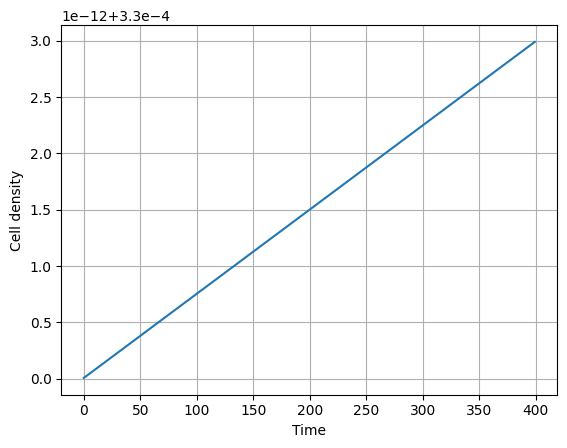

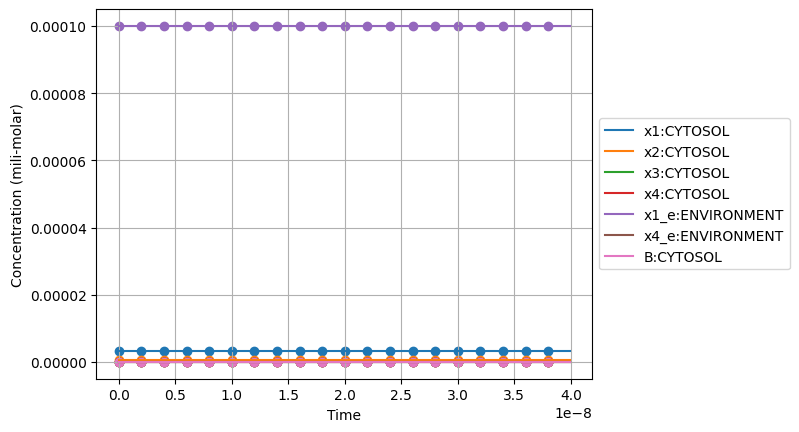

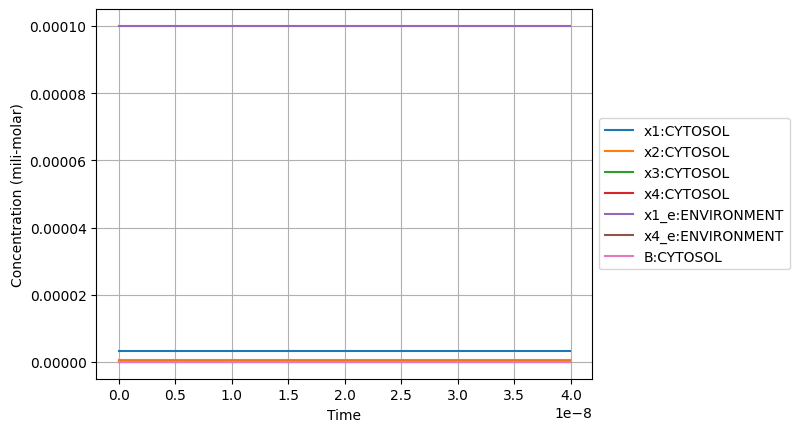

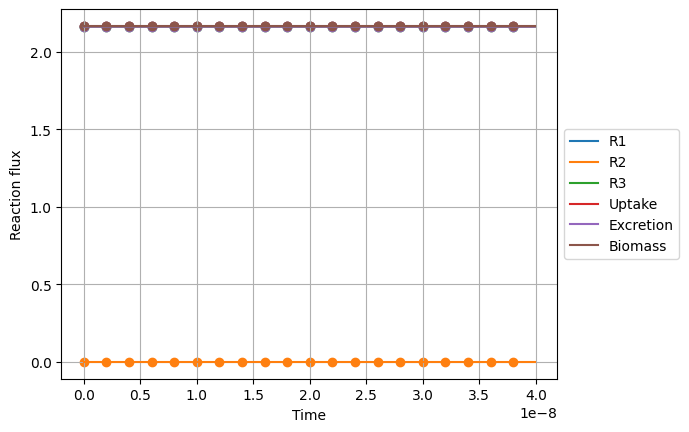

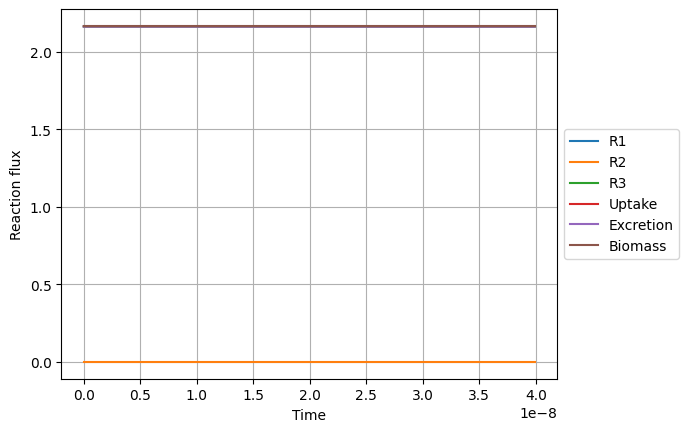

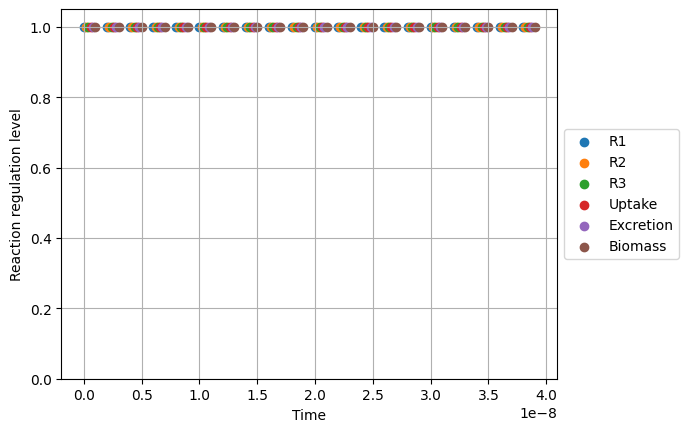

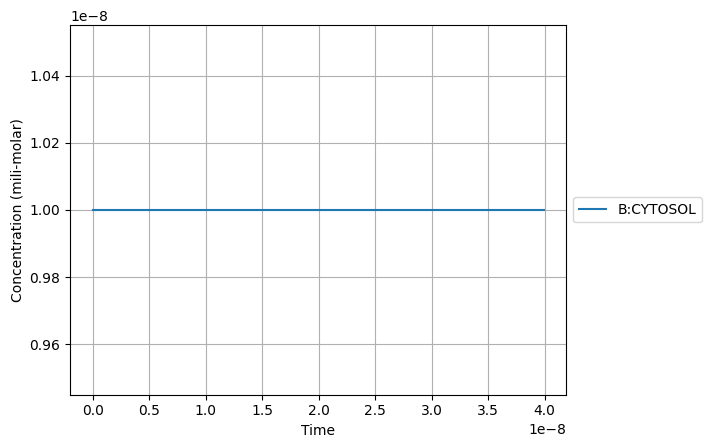

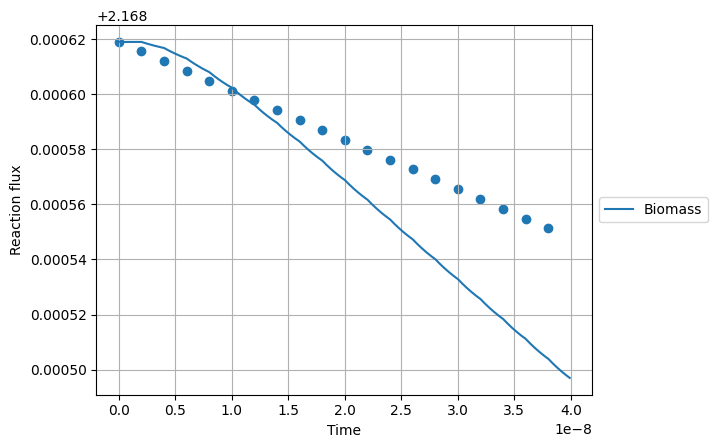

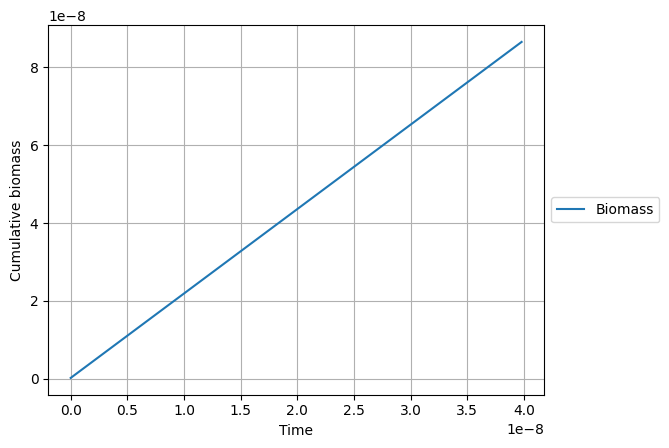

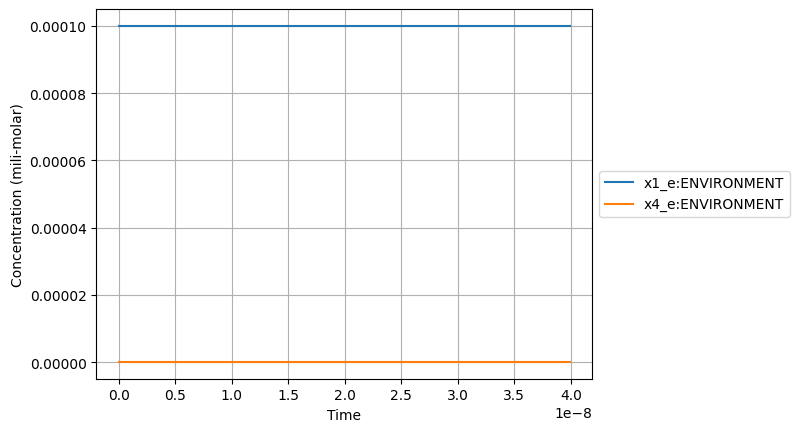

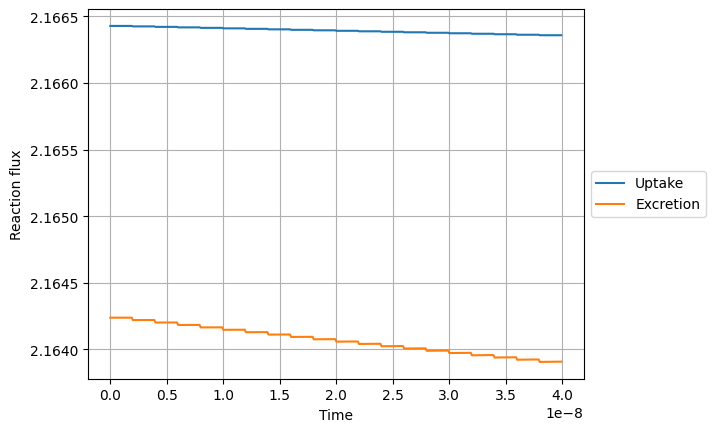

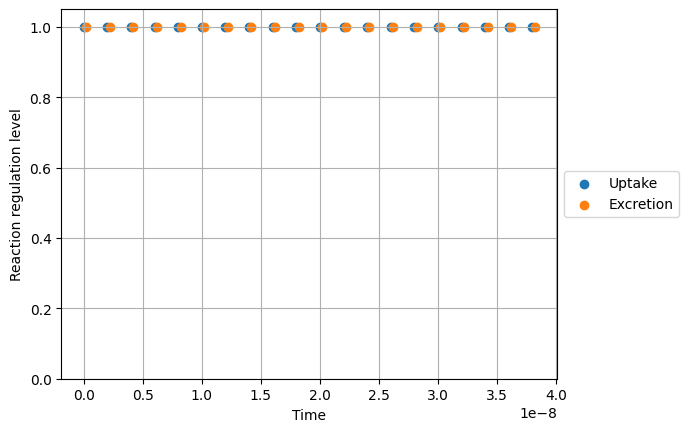

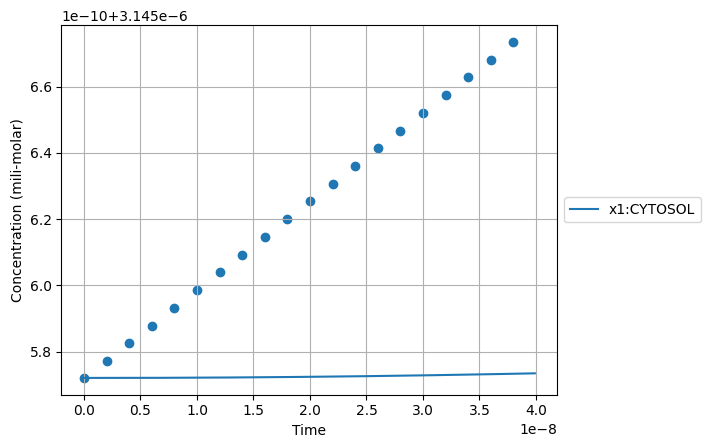

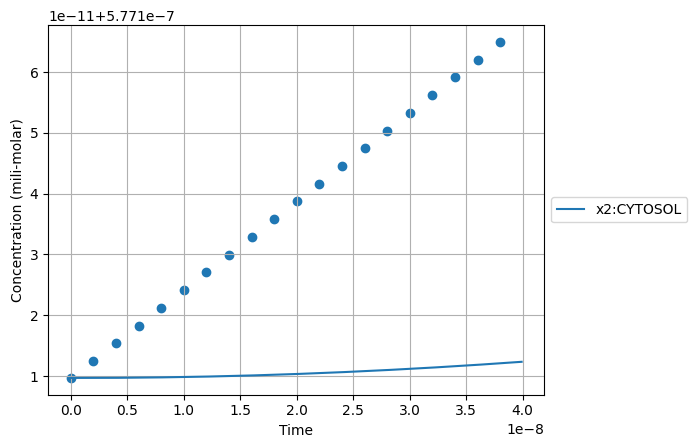

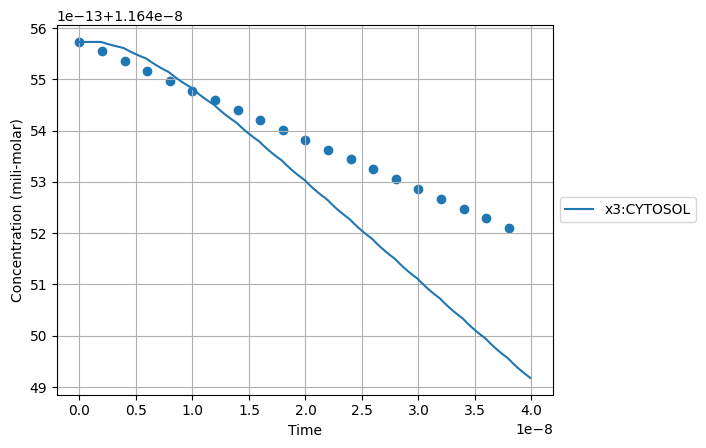

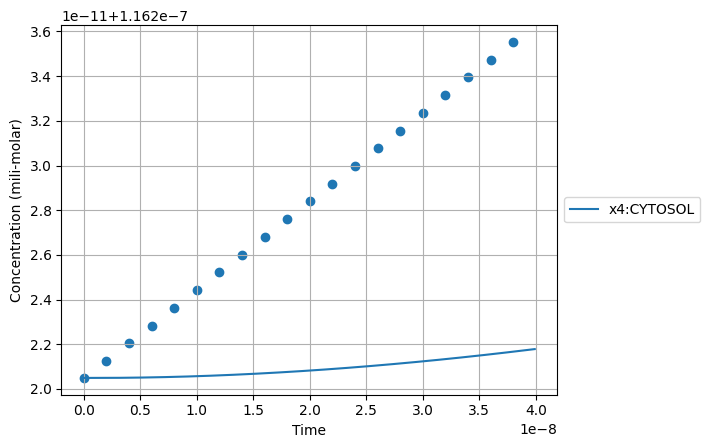

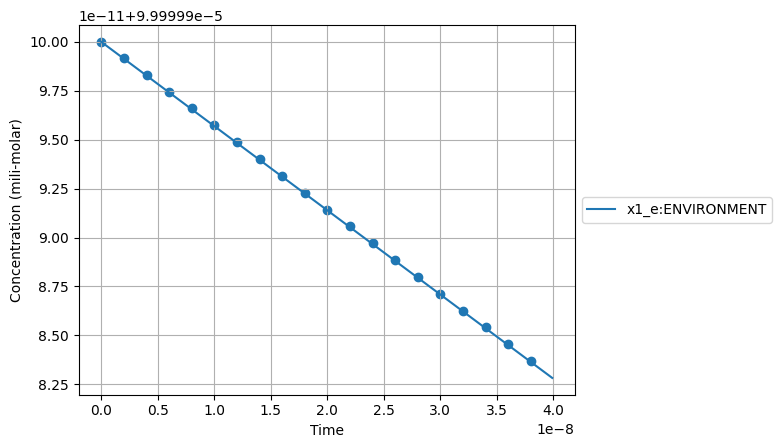

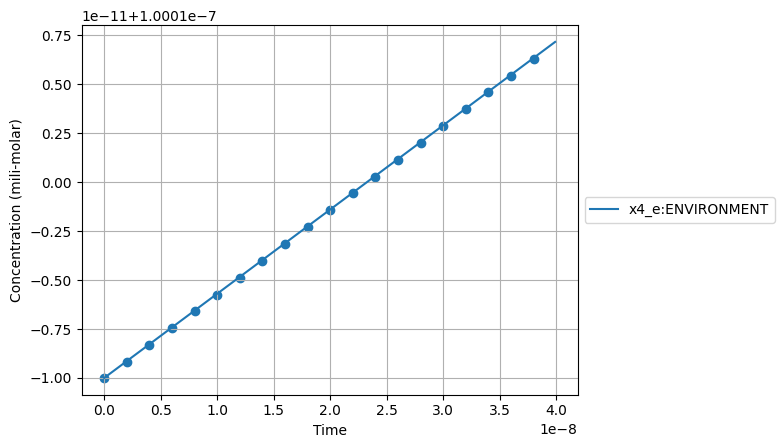

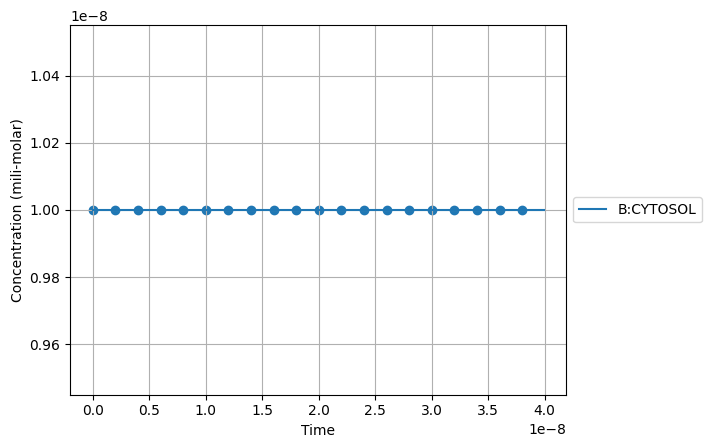

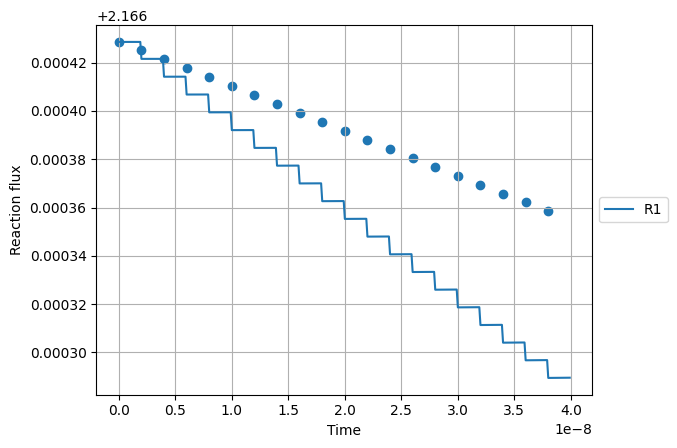

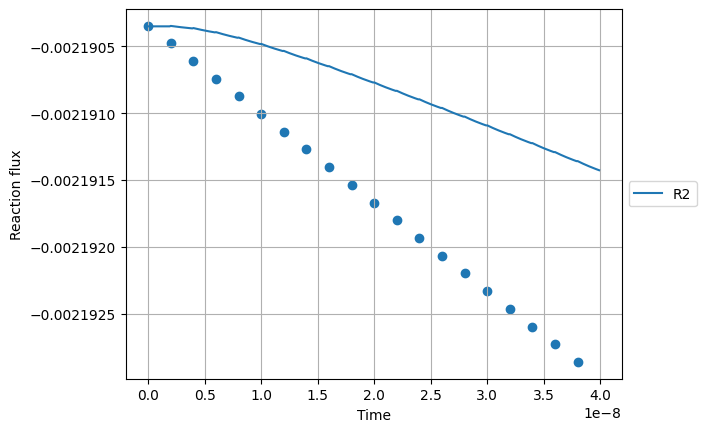

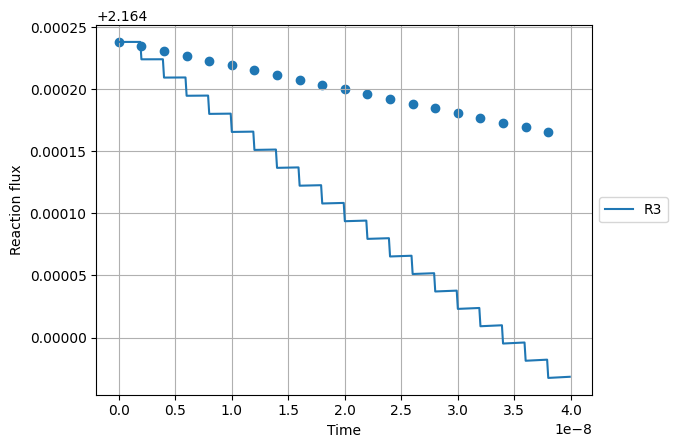

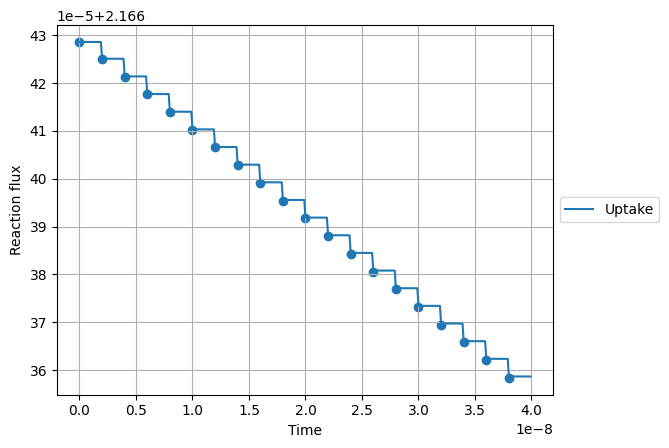

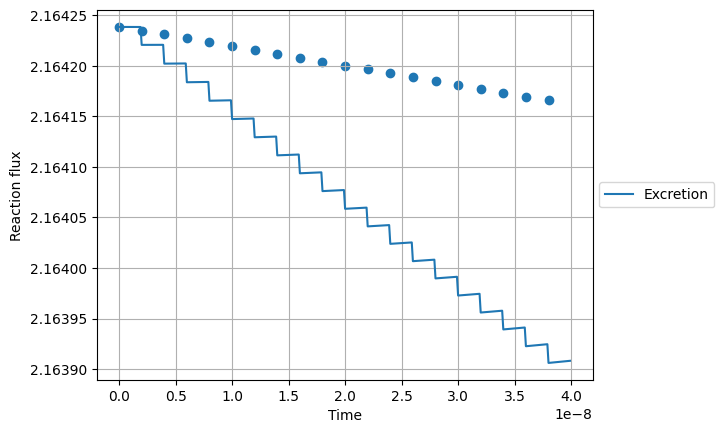

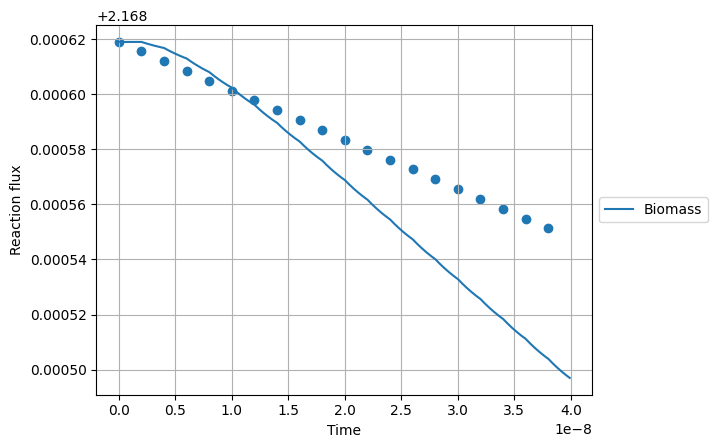

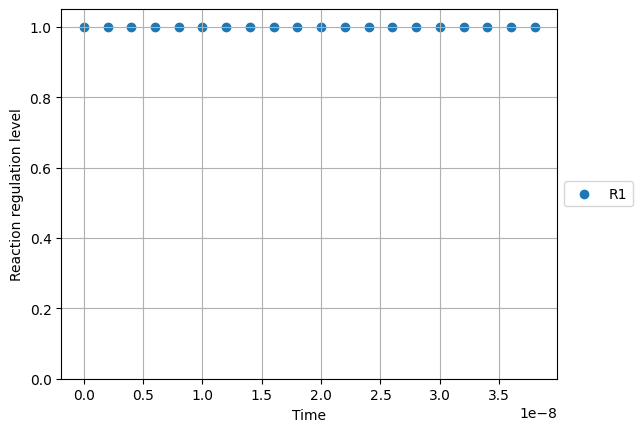

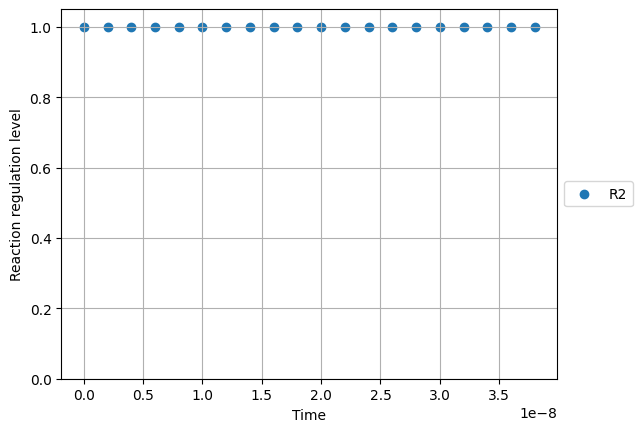

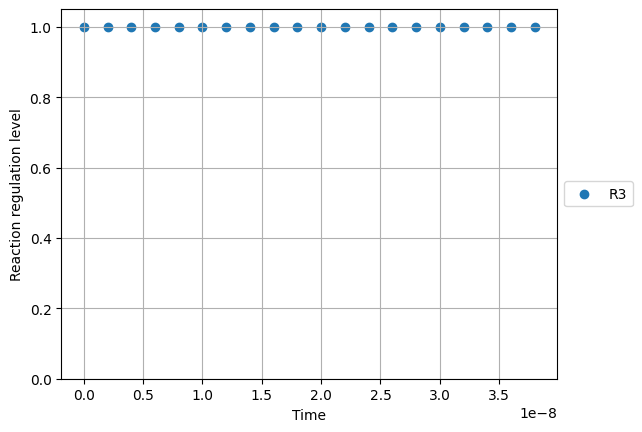

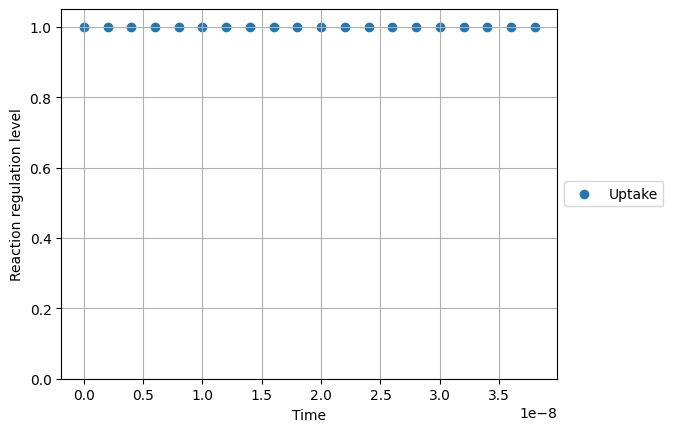

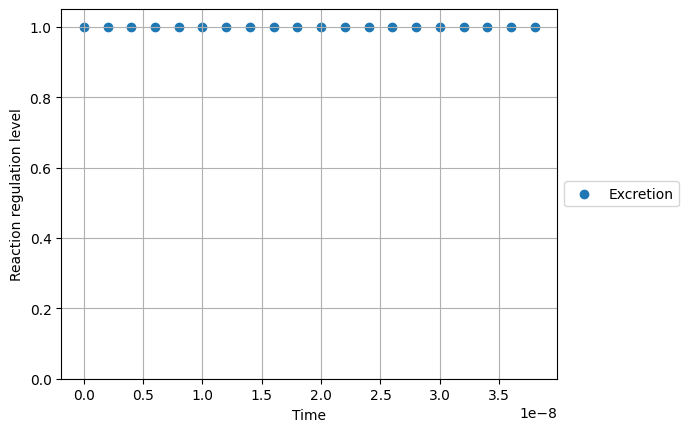

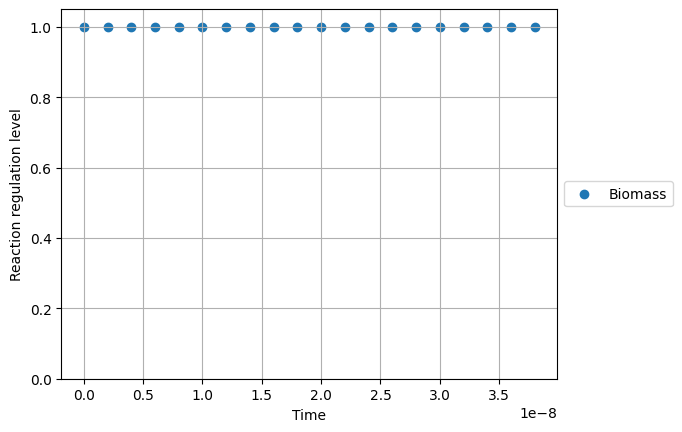

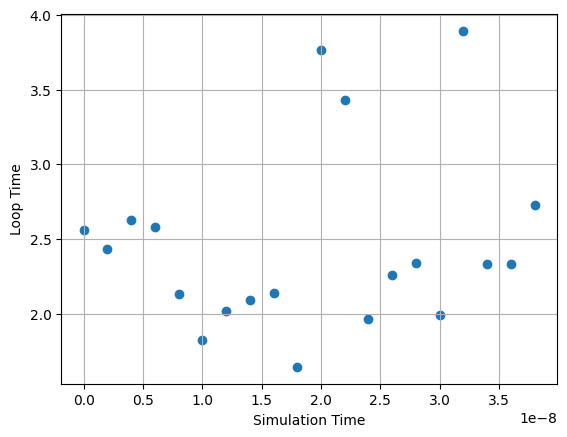

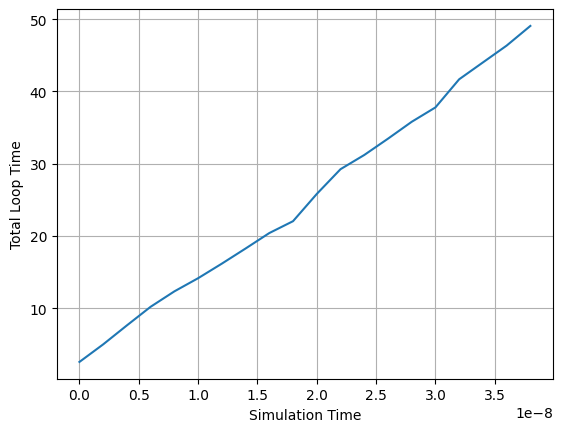

In [6]:

plot_dictionary={
    'biomass_metabolite':'B:CYTOSOL',
    'biomass_reaction':'Biomass',
    'time_limit':0,
    'metabolite_subset':[],
    'reaction_subset':[],
    'regulation_subset':[],
    'exchange_metabolite':['x1_e:ENVIRONMENT','x4_e:ENVIRONMENT'],
    'exchange_reaction':['Uptake','Excretion']
}
dyn.PlotFromPickle(control_dictionary,plot_dictionary)

Parallel:

In [7]:
reload(dyn)
# these dictionaries are treated as having global scope
control_dictionary={
    'model_file_dir':'Saved_models', # default 'Saved_models'
    'solution_file_dir':'Saved_solutions', # default 'Saved_solutions'
    'pickle_output':'parrallel_test.pkl',
    'parallel_solve':True,# boolean True/False
    'worker_count': 5,  # natural number, 0 or remove for cpu_count
    'delta_concentration':[1e-6], # list positive reals
    'delta_flux':[1], # list positive reals
    'mb':[100], # list positive naturals
    'zeta':[0.005], # list positive reals
    'swarm_size':10, # naturals, default is 2
    'linear_solver': 'ma57',
    'max_cpu_time':800000,
    'max_iter':100000,
    'acceptable_tol':1e-6,
    'solver_tol':1e-7,
    'feasibility_check':False,
    'feasibility_as_input':False,
    'annealing_check':False
#     'hsllib':'/opt/coinhsl/lib/libcoinhsl.dylib'
}

ode_system_dictionary={
    'dt':1e-10,
#     'nmax':4800000,
    'nmax':400,
    'stoichiometry_matrix':[],
    'metabolites_to_fix':['B:CYTOSOL'],
    'jump_tolerance':0.5,
    'stall_on_opt_jump':5,
#     'Opt_frequency':200000
    'Opt_frequency':20
}

environment_dictionary={
    'metabolites':['x1_e:ENVIRONMENT','x4_e:ENVIRONMENT'],
    'transport_reactions':['Uptake','Excretion'],
    'chemostat_type':[['Zero',{'Magnitude':1e-4}],['Zero',{'Magnitude':1e-6}]],
    'initial_environment_concentrations':[1.0e-4,1e-7], # molar
    'bath_volume':1.0,
    'glucose_diffusion_constant':600 # µm^2/sec
}


cell_dictionary={
    'model':'smallModel_lowK.pkl',#'smallModel_highK.pkl',
    'previous_best_model_solution':"",
    'environment_energy_name':'x1_e:ENVIRONMENT',
    'energy_import_reaction_name':'Uptake',
    'environment_compartment_name':'ENVIRONMENT',
#     'adaptation_constant':0.01,
    'initial_cell_density':3.3e-4,
    'birth_rate':1.0,
    'death_rate':0.008,
    'import_energy_metabolites':['x1_e:ENVIRONMENT','x4_e:ENVIRONMENT'],
    'import_energy_reactions':['Uptake','Excretion'],
    'import_energy_michaelis_menten':[0.04*1e-3,0.04*1e-3], # m moles
    
    'vmax':3.033e-12, # mM glucose consumed per hour per 1 micron^3 cell 
    'cell_volume':1e-15, 
    'hyphae_volume':4e3, # microns^3
    'N_avogadro':6.022140857e+23
    
}
  
# run the ThermoOpt method
metaboliteTraceDf,metabolitesOPT,fluxTraceDf,fluxOPT,regulationOPT,timesOPT,cell_density_vec,loopTimes = dyn.RunThermoOpt(control_dictionary,ode_system_dictionary,environment_dictionary,cell_dictionary)

# run the simulation output into a pickle file 'pickle_output'
dyn.SaveSimulationOutput(control_dictionary,metaboliteTraceDf,metabolitesOPT,fluxTraceDf,fluxOPT,regulationOPT,timesOPT,cell_density_vec,loopTimes)

# delete the files created during the simulation 
dyn.CleanThermoOpt(control_dictionary)

Volume of cell: 1e-15
Surface area of cell: 4.835975862049414e-10
Volume of near field element: 9.047786842338601e-10
Volume ratio of Chemostat To Cell: 904778.6842338601
Sim Name: ChemostatModel_t_0.0_swarm_0_100_0.005_1e-06_1 objective: 116.12905300541283 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_1_100_0.005_1e-06_1 objective: 116.1290530243413 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_2_100_0.005_1e-06_1 objective: 220.62495136774882 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_3_100_0.005_1e-06_1 objective: 220.6249513823286 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_4_100_0.005_1e-06_1 objective: 220.6249513585322 status: ok
exception in flux_ent_opt_hyperparameter
Sim Name: ChemostatModel_t_0.0_swarm_5_100_0.005_1e-06_1 objective: 220.62495142540928 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_6_100_0.005_1e-06_1 objective: 0 status: Fail
Sim Name: ChemostatModel_t_0.0_swarm_7_100_0.005_1e-06_1 objective: 220.62495142541388 status: ok
Sim Name: ChemostatMod

Sim Name: ChemostatModel_t_1.4000000000000001e-08_swarm_5_100_0.005_1e-06_1 objective: 220.62242652694607 status: ok
Sim Name: ChemostatModel_t_1.4000000000000001e-08_swarm_6_100_0.005_1e-06_1 objective: 220.6224265269523 status: ok
Sim Name: ChemostatModel_t_1.4000000000000001e-08_swarm_7_100_0.005_1e-06_1 objective: 220.62242660245636 status: ok
Sim Name: ChemostatModel_t_1.4000000000000001e-08_swarm_8_100_0.005_1e-06_1 objective: 116.12905163617249 status: ok
Sim Name: ChemostatModel_t_1.4000000000000001e-08_swarm_9_100_0.005_1e-06_1 objective: 220.62242653532456 status: ok
Loop Time in seconds:  0.9042818546295166
ETA in minutes:  0.19592773516972858
Sim Name: ChemostatModel_t_1.6e-08_swarm_0_100_0.005_1e-06_1 objective: 116.12905139713105 status: ok
Sim Name: ChemostatModel_t_1.6e-08_swarm_1_100_0.005_1e-06_1 objective: 220.62206336867428 status: ok
Sim Name: ChemostatModel_t_1.6e-08_swarm_2_100_0.005_1e-06_1 objective: 116.12905142797999 status: ok
Sim Name: ChemostatModel_t_1.6e

exception in flux_ent_opt_hyperparameter
Sim Name: ChemostatModel_t_2.8000000000000003e-08_swarm_0_100_0.005_1e-06_1 objective: 116.12905029997643 status: ok
Sim Name: ChemostatModel_t_2.8000000000000003e-08_swarm_1_100_0.005_1e-06_1 objective: 220.61988389660058 status: ok
Sim Name: ChemostatModel_t_2.8000000000000003e-08_swarm_2_100_0.005_1e-06_1 objective: 0 status: Fail
Sim Name: ChemostatModel_t_2.8000000000000003e-08_swarm_3_100_0.005_1e-06_1 objective: 116.12905019670947 status: ok
Sim Name: ChemostatModel_t_2.8000000000000003e-08_swarm_4_100_0.005_1e-06_1 objective: 220.61988390454528 status: ok
Sim Name: ChemostatModel_t_2.8000000000000003e-08_swarm_5_100_0.005_1e-06_1 objective: 116.12905020963443 status: ok
Sim Name: ChemostatModel_t_2.8000000000000003e-08_swarm_6_100_0.005_1e-06_1 objective: 220.6198839299954 status: ok
Sim Name: ChemostatModel_t_2.8000000000000003e-08_swarm_7_100_0.005_1e-06_1 objective: 220.6198838966046 status: ok
Sim Name: ChemostatModel_t_2.80000000000

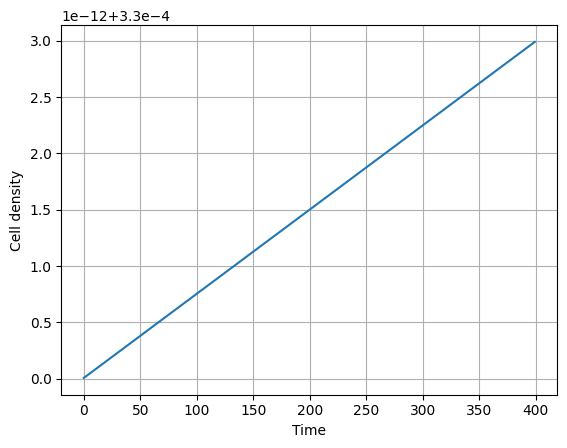

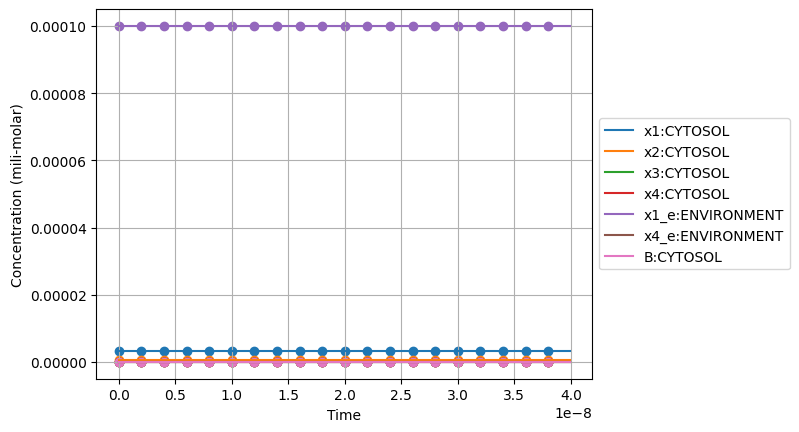

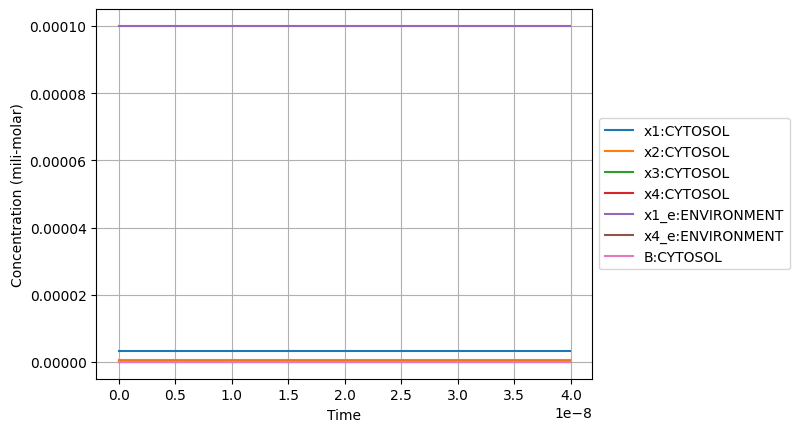

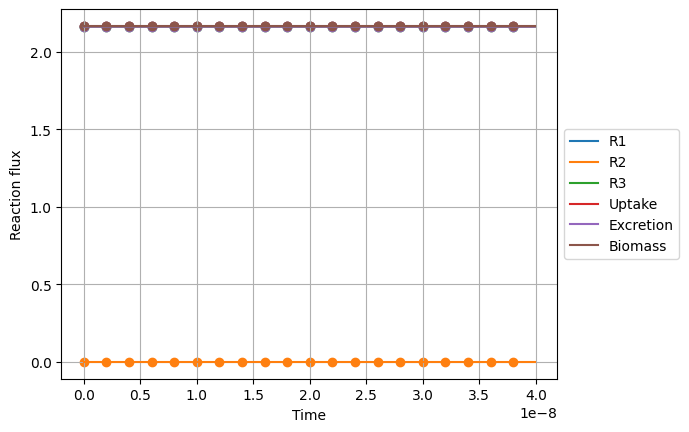

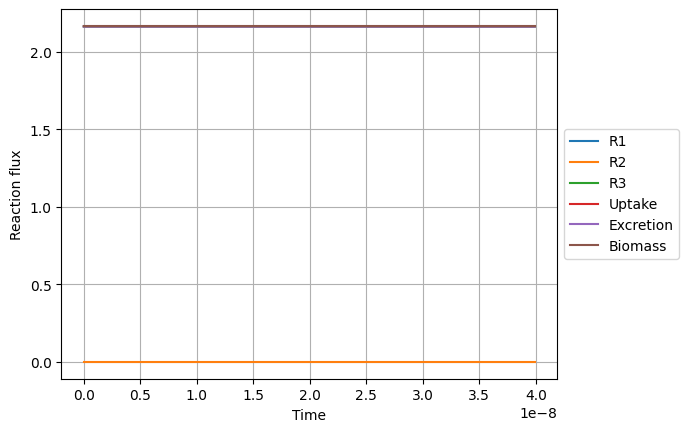

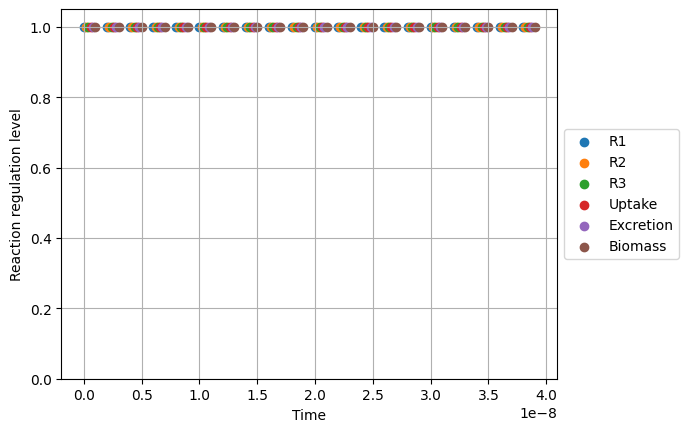

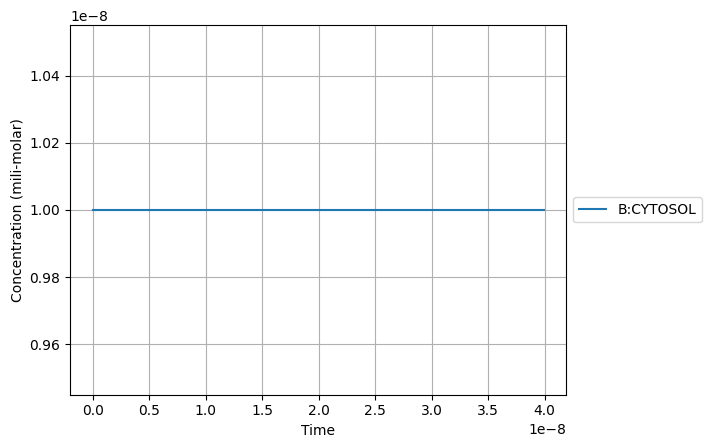

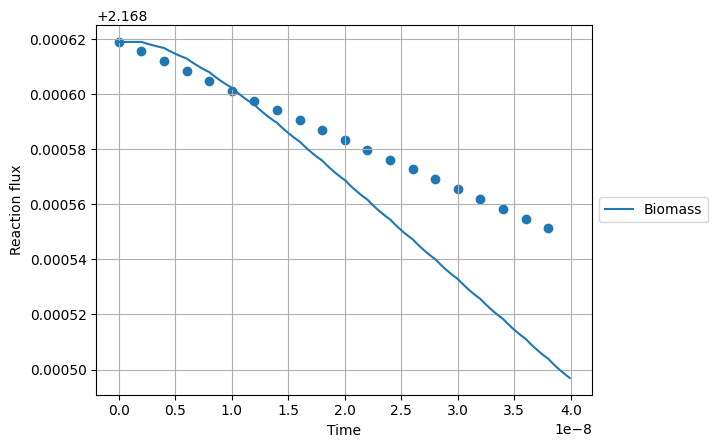

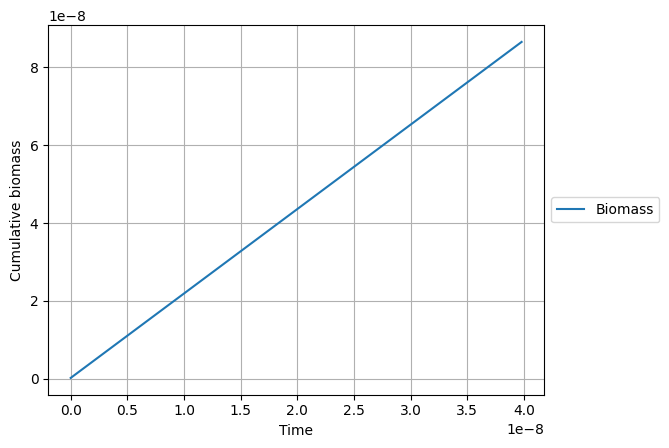

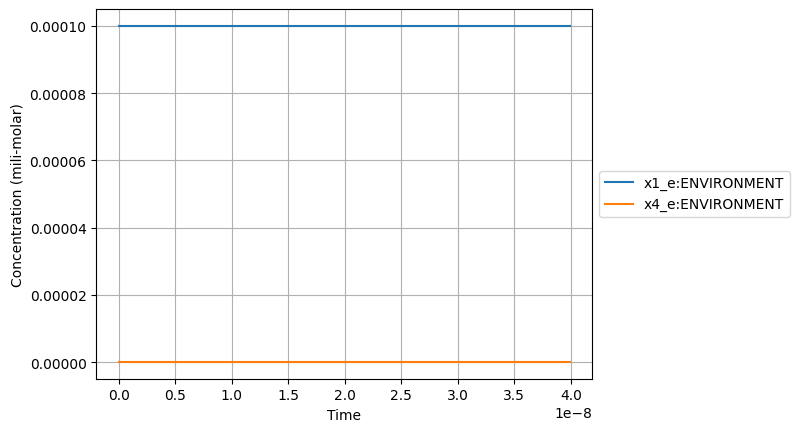

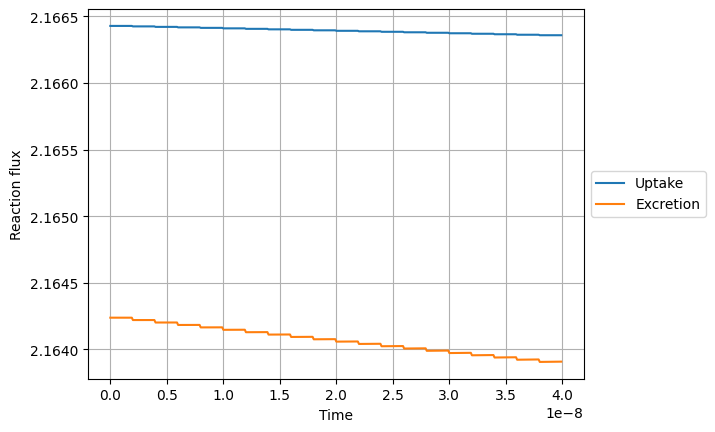

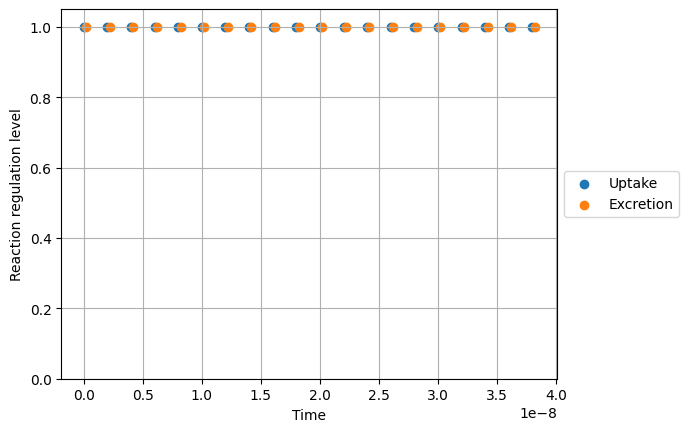

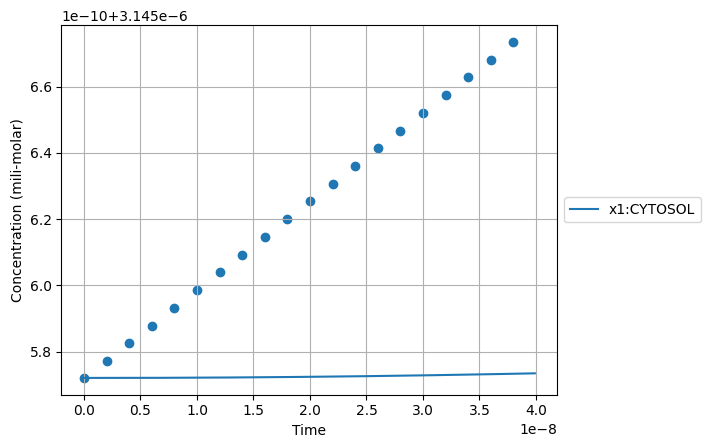

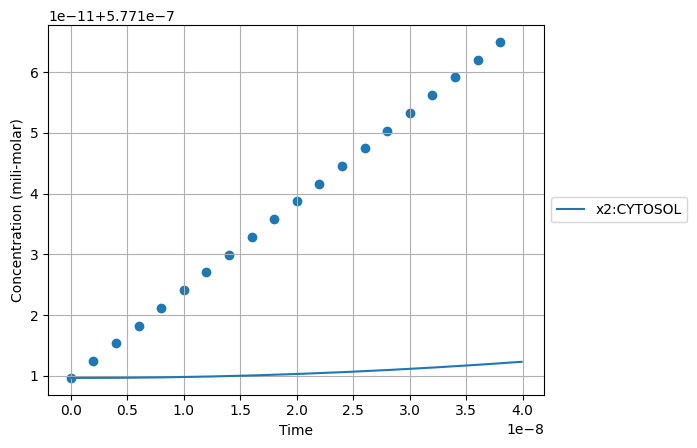

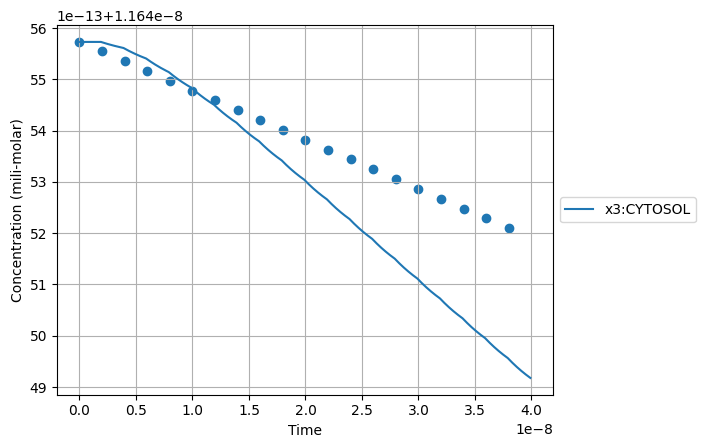

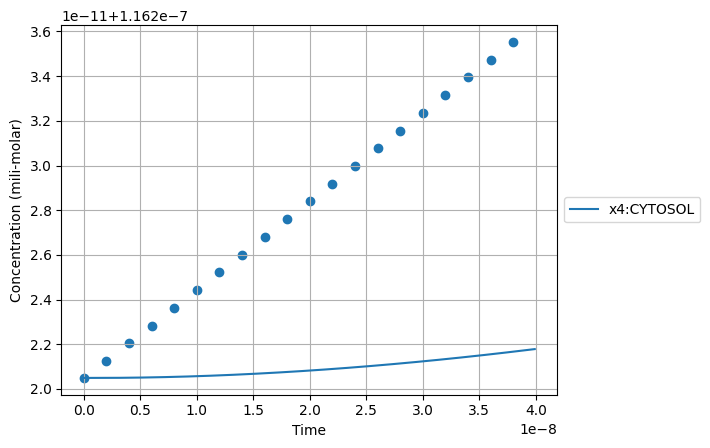

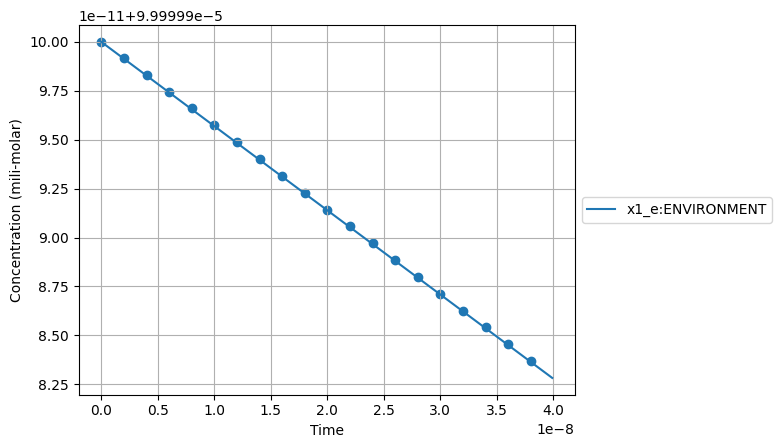

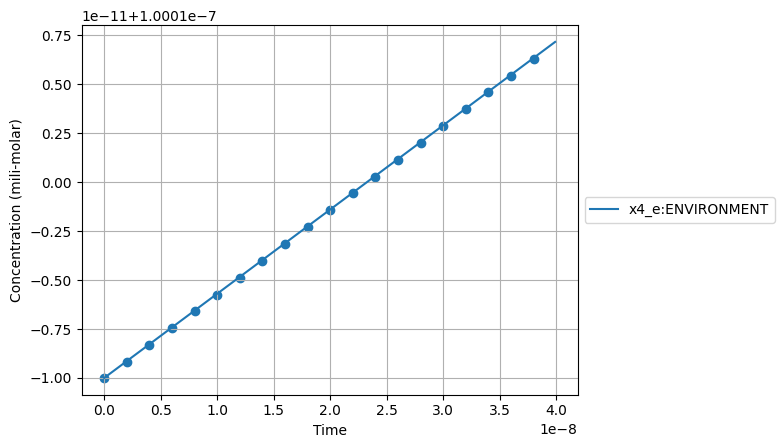

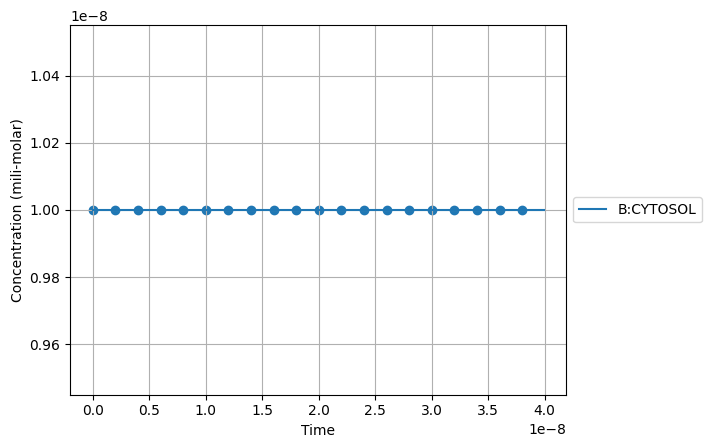

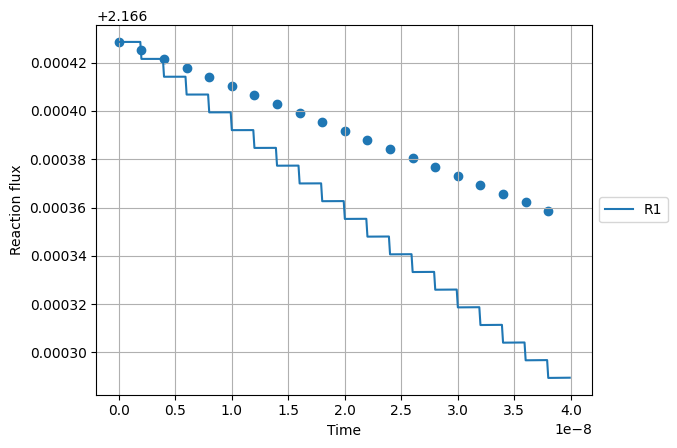

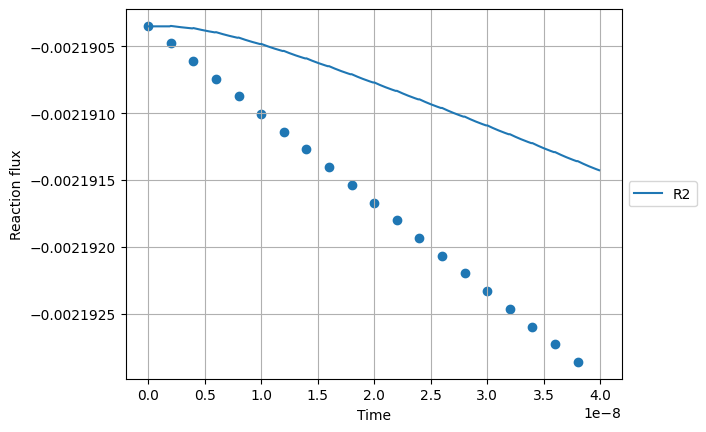

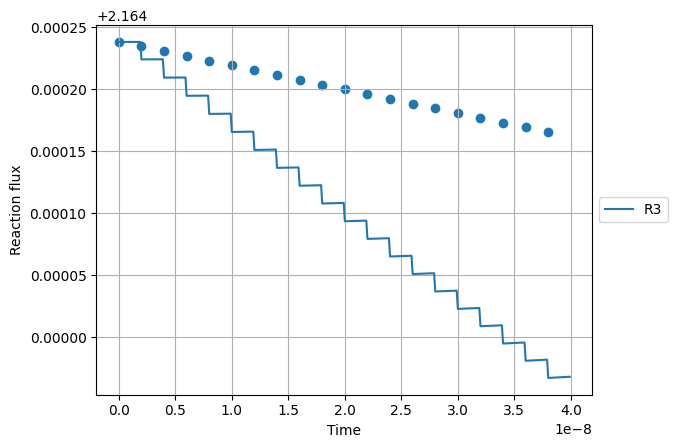

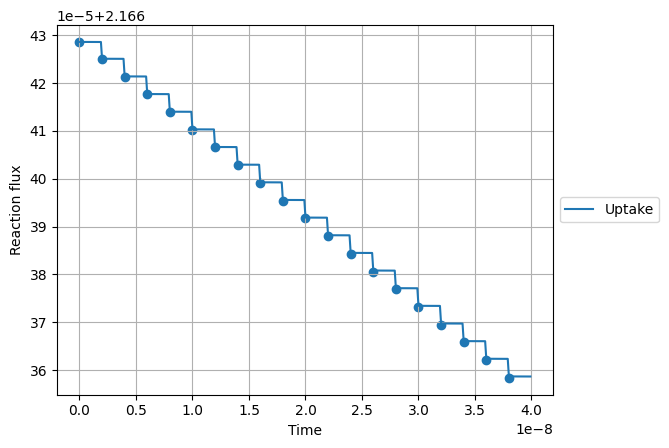

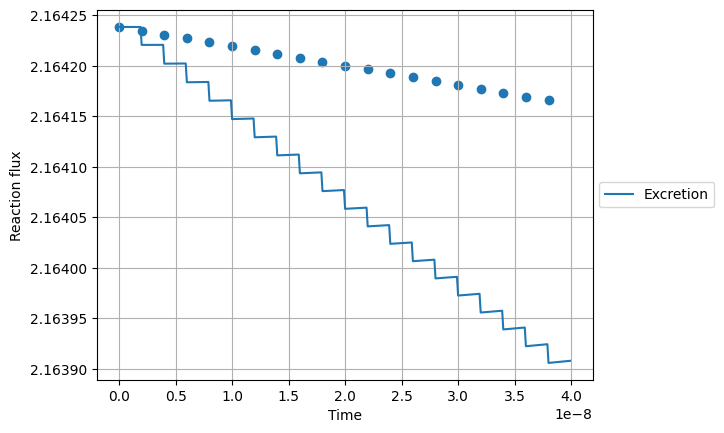

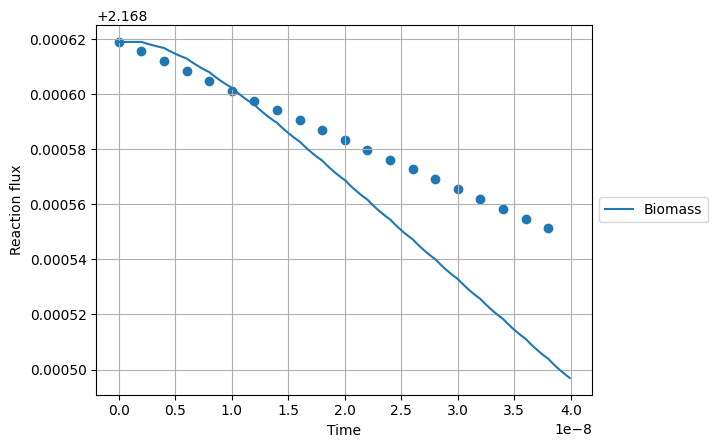

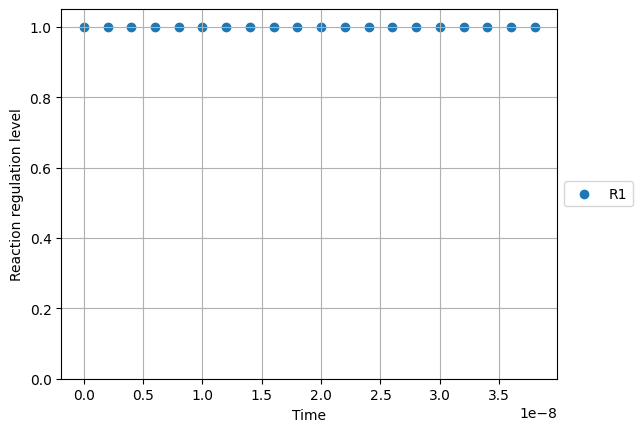

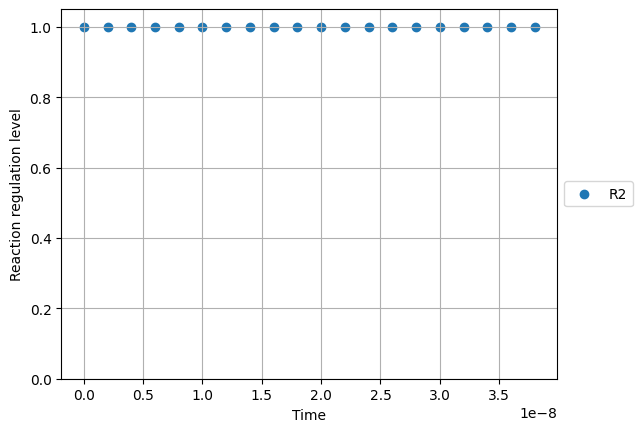

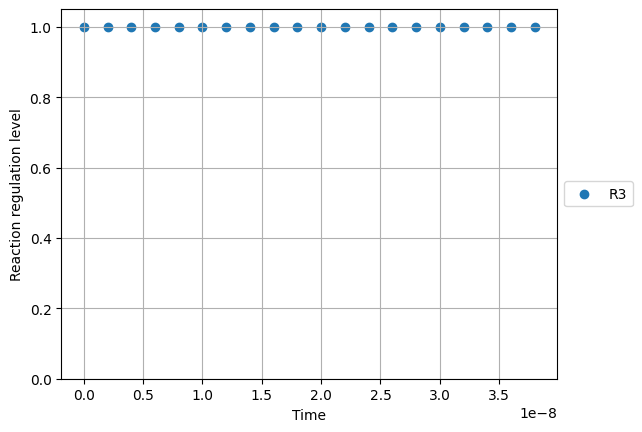

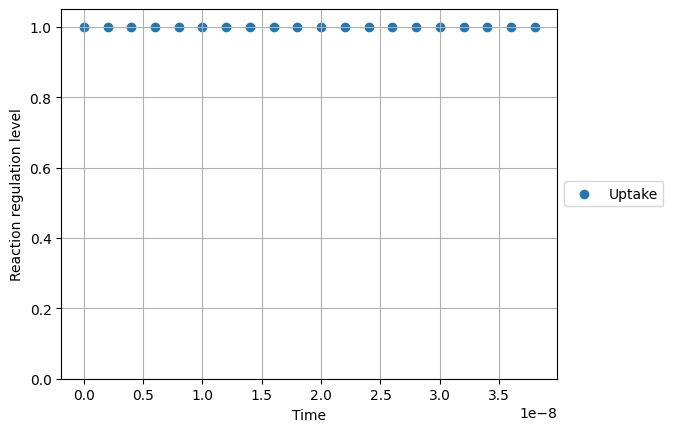

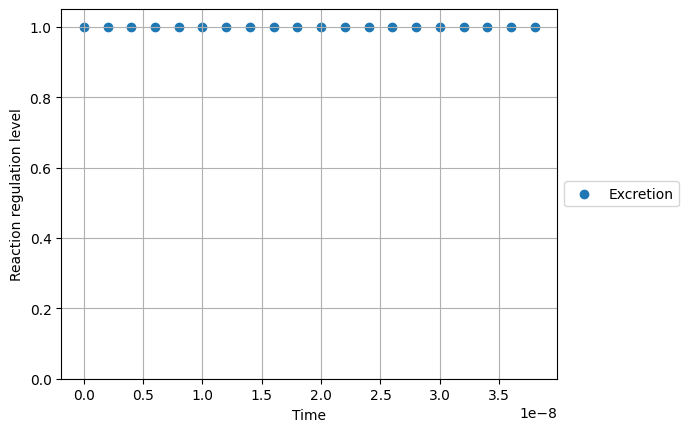

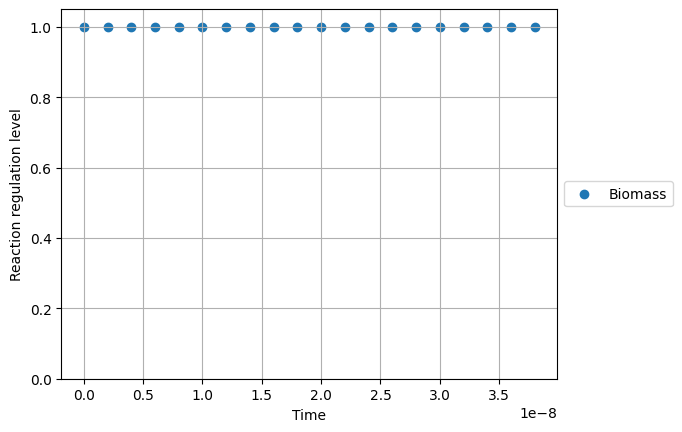

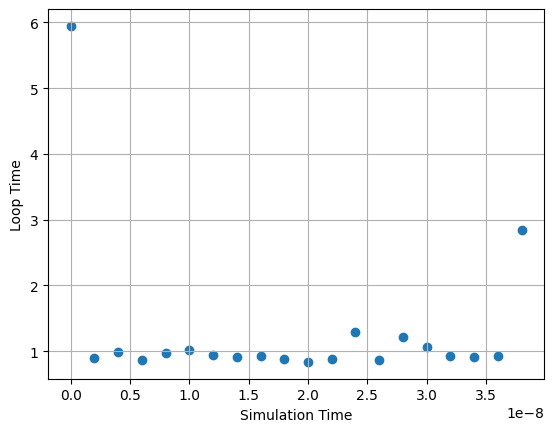

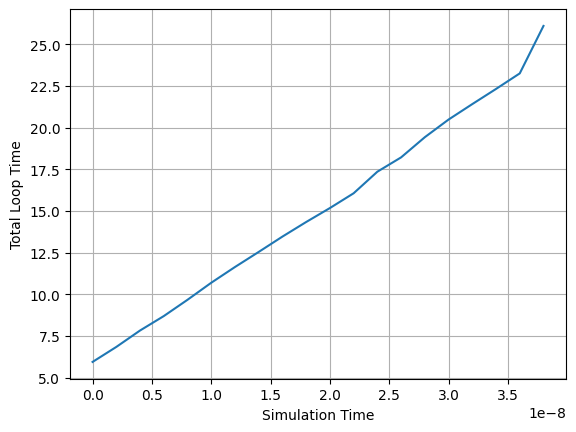

In [8]:
plot_dictionary={
    'biomass_metabolite':'B:CYTOSOL',
    'biomass_reaction':'Biomass',
    'time_limit':0,
    'metabolite_subset':[],
    'reaction_subset':[],
    'regulation_subset':[],
    'exchange_metabolite':['x1_e:ENVIRONMENT','x4_e:ENVIRONMENT'],
    'exchange_reaction':['Uptake','Excretion']
}
dyn.PlotFromPickle(control_dictionary,plot_dictionary)

# With regulation Vs Without Regulation

With regulation:

In [9]:
# these dictionaries are treated as having global scope
control_dictionary={
    'model_file_dir':'Saved_models', # default 'Saved_models'
    'solution_file_dir':'Saved_solutions', # default 'Saved_solutions'
    'pickle_output':'with_regulation.pkl',
    'parallel_solve':True,# boolean True/False
    'worker_count': 5,  # natural number, 0 or remove for cpu_count
    'delta_concentration':[1e-6], # list positive reals
    'delta_flux':[1], # list positive reals
    'mb':[100], # list positive naturals
    'zeta':[0.005], # list positive reals
    'swarm_size':10, # naturals, default is 2
    'linear_solver': 'ma57',
    'max_cpu_time':800000,
    'max_iter':100000,
    'acceptable_tol':1e-6,
    'solver_tol':1e-7,
    'feasibility_check':False,
    'feasibility_as_input':False,
    'annealing_check':False
#     'hsllib':'/opt/coinhsl/lib/libcoinhsl.dylib'
}

ode_system_dictionary={
    'dt':1e-10,
#     'nmax':4800000,
    'nmax':400,
    'stoichiometry_matrix':[],
    'metabolites_to_fix':['B:CYTOSOL'],
    'jump_tolerance':0.5,
    'stall_on_opt_jump':5,
#     'Opt_frequency':200000
    'Opt_frequency':20
}

environment_dictionary={
    'metabolites':['x1_e:ENVIRONMENT','x4_e:ENVIRONMENT'],
    'transport_reactions':['Uptake','Excretion'],
    'chemostat_type':[['Zero',{'Magnitude':1e-4}],['Zero',{'Magnitude':1e-6}]],
    'initial_environment_concentrations':[1.0e-4,1e-7], # molar
    'bath_volume':1.0,
    'glucose_diffusion_constant':600 # µm^2/sec
}


cell_dictionary={
    'model':'smallModel_lowK.pkl',#'smallModel_highK.pkl',
    'previous_best_model_solution':"",
    'environment_energy_name':'x1_e:ENVIRONMENT',
    'energy_import_reaction_name':'Uptake',
    'environment_compartment_name':'ENVIRONMENT',
    'biomass_reaction':'Biomass',
#     'adaptation_constant':0.01,
    'initial_cell_density':3.3e-4,
    'birth_rate':1.0,
    'death_rate':0.008,
    'import_energy_metabolites':['x1_e:ENVIRONMENT','x4_e:ENVIRONMENT'],
    'import_energy_reactions':['Uptake','Excretion'],
    'import_energy_michaelis_menten':[0.04*1e-3,0.04*1e-3], # m moles
    
    'vmax':3.033e-12, # mM glucose consumed per hour per 1 micron^3 cell 
    'cell_volume':1e-15, 
    'hyphae_volume':4e3, # microns^3
    'N_avogadro':6.022140857e+23
    
}
  
# run the ThermoOpt method
metaboliteTraceDf,metabolitesOPT,fluxTraceDf,fluxOPT,regulationOPT,timesOPT,cell_density_vec,loopTimes = dyn.RunThermoOpt(control_dictionary,ode_system_dictionary,environment_dictionary,cell_dictionary)

# run the simulation output into a pickle file 'pickle_output'
dyn.SaveSimulationOutput(control_dictionary,metaboliteTraceDf,metabolitesOPT,fluxTraceDf,fluxOPT,regulationOPT,timesOPT,cell_density_vec,loopTimes)

# delete the files created during the simulation 
dyn.CleanThermoOpt(control_dictionary)



Volume of cell: 1e-15
Surface area of cell: 4.835975862049414e-10
Volume of near field element: 9.047786842338601e-10
Volume ratio of Chemostat To Cell: 904778.6842338601
Sim Name: ChemostatModel_t_0.0_swarm_0_100_0.005_1e-06_1 objective: 116.12905298770897 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_1_100_0.005_1e-06_1 objective: 220.62495135349604 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_2_100_0.005_1e-06_1 objective: 116.12905303995299 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_3_100_0.005_1e-06_1 objective: 220.62495138967228 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_4_100_0.005_1e-06_1 objective: 220.62495139725507 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_5_100_0.005_1e-06_1 objective: 116.12905299983206 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_6_100_0.005_1e-06_1 objective: 220.62495132390765 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_7_100_0.005_1e-06_1 objective: 116.12905301311953 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_8_100_0.

Sim Name: ChemostatModel_t_1.4000000000000001e-08_swarm_5_100_0.005_1e-06_1 objective: 220.62242656853 status: ok
Sim Name: ChemostatModel_t_1.4000000000000001e-08_swarm_6_100_0.005_1e-06_1 objective: 116.12905159515412 status: ok
Sim Name: ChemostatModel_t_1.4000000000000001e-08_swarm_7_100_0.005_1e-06_1 objective: 116.12905159720454 status: ok
Sim Name: ChemostatModel_t_1.4000000000000001e-08_swarm_8_100_0.005_1e-06_1 objective: 220.62242656870652 status: ok
Sim Name: ChemostatModel_t_1.4000000000000001e-08_swarm_9_100_0.005_1e-06_1 objective: 116.1290516312635 status: ok
Loop Time in seconds:  0.9816217422485352
ETA in minutes:  0.21268471082051596
Sim Name: ChemostatModel_t_1.6e-08_swarm_0_100_0.005_1e-06_1 objective: 116.12905145987324 status: ok
Sim Name: ChemostatModel_t_1.6e-08_swarm_1_100_0.005_1e-06_1 objective: 220.62206327385252 status: ok
Sim Name: ChemostatModel_t_1.6e-08_swarm_2_100_0.005_1e-06_1 objective: 116.12905143163553 status: ok
Sim Name: ChemostatModel_t_1.6e-08

Sim Name: ChemostatModel_t_3.0000000000000004e-08_swarm_0_100_0.005_1e-06_1 objective: 116.12905004921794 status: ok
Sim Name: ChemostatModel_t_3.0000000000000004e-08_swarm_1_100_0.005_1e-06_1 objective: 220.61952069925204 status: ok
Sim Name: ChemostatModel_t_3.0000000000000004e-08_swarm_2_100_0.005_1e-06_1 objective: 220.619520698764 status: ok
Sim Name: ChemostatModel_t_3.0000000000000004e-08_swarm_3_100_0.005_1e-06_1 objective: 220.6195206913572 status: ok
Sim Name: ChemostatModel_t_3.0000000000000004e-08_swarm_4_100_0.005_1e-06_1 objective: 116.12905012814775 status: ok
Sim Name: ChemostatModel_t_3.0000000000000004e-08_swarm_5_100_0.005_1e-06_1 objective: 220.619520766226 status: ok
Sim Name: ChemostatModel_t_3.0000000000000004e-08_swarm_6_100_0.005_1e-06_1 objective: 220.61952078858008 status: ok
Sim Name: ChemostatModel_t_3.0000000000000004e-08_swarm_7_100_0.005_1e-06_1 objective: 220.6195207455034 status: ok
Sim Name: ChemostatModel_t_3.0000000000000004e-08_swarm_8_100_0.005_1e

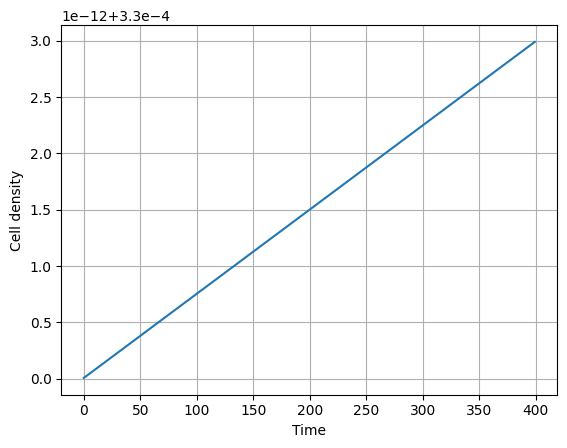

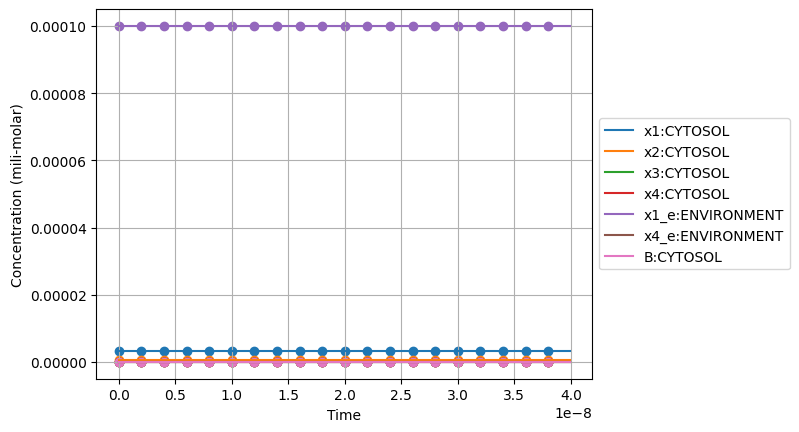

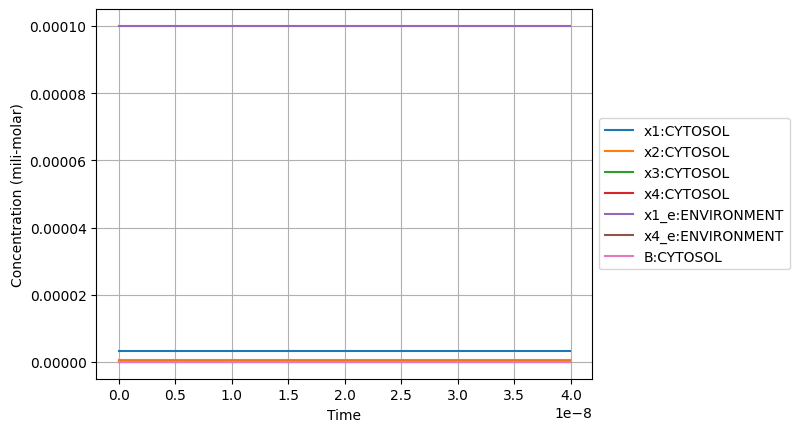

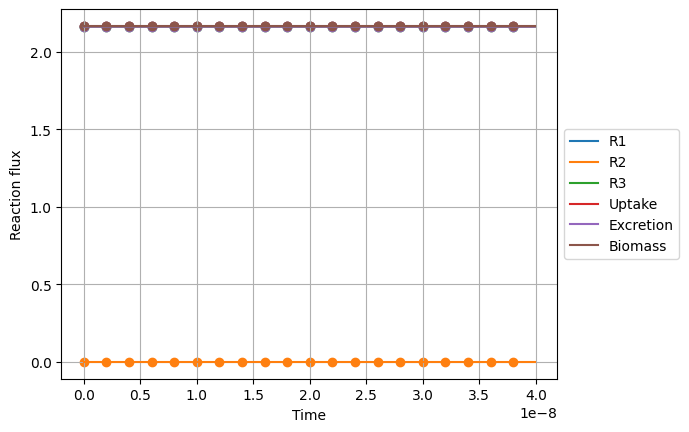

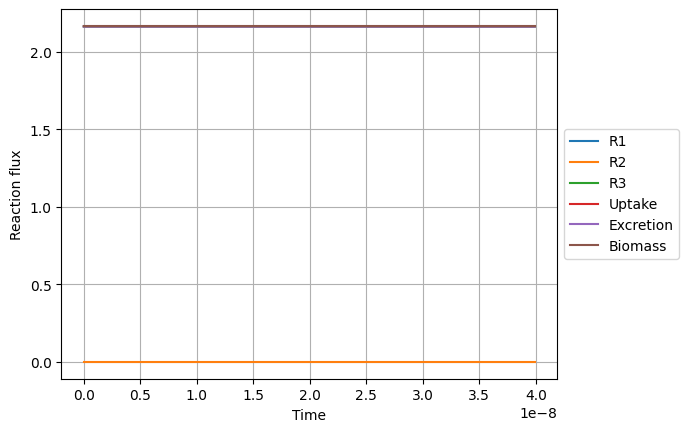

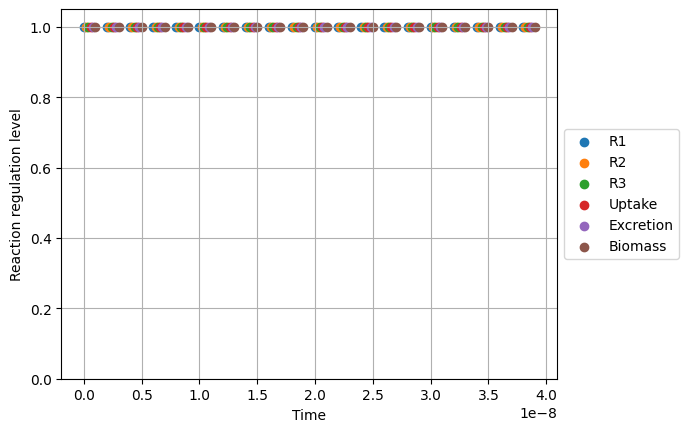

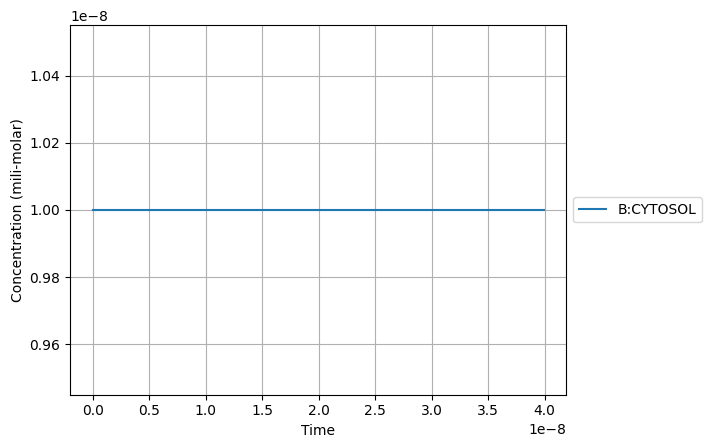

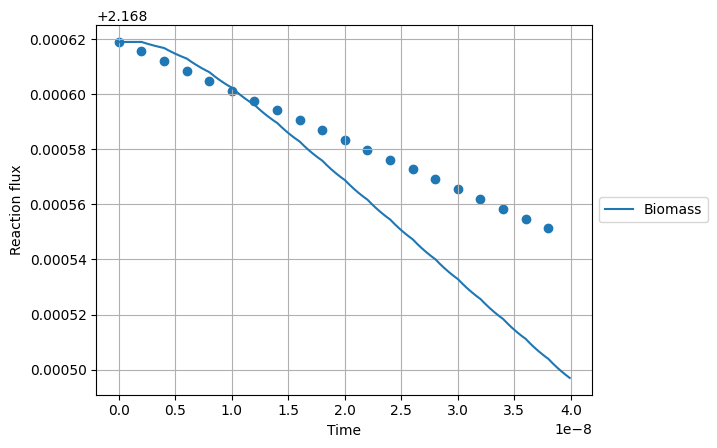

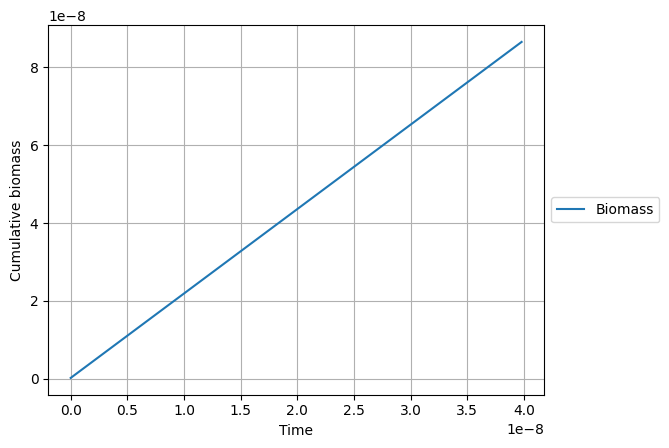

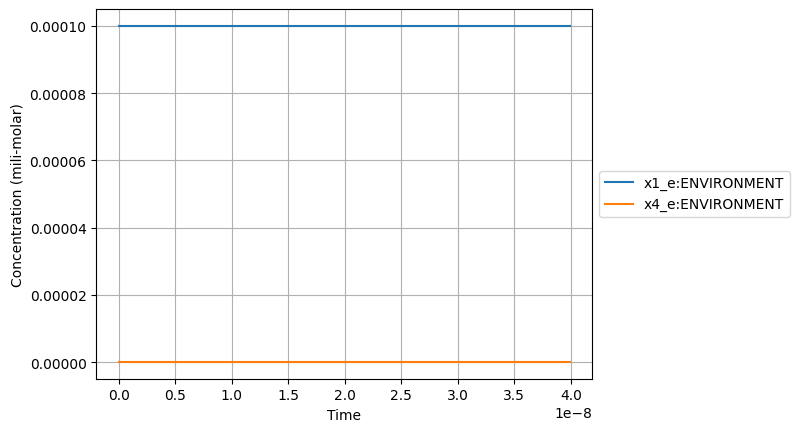

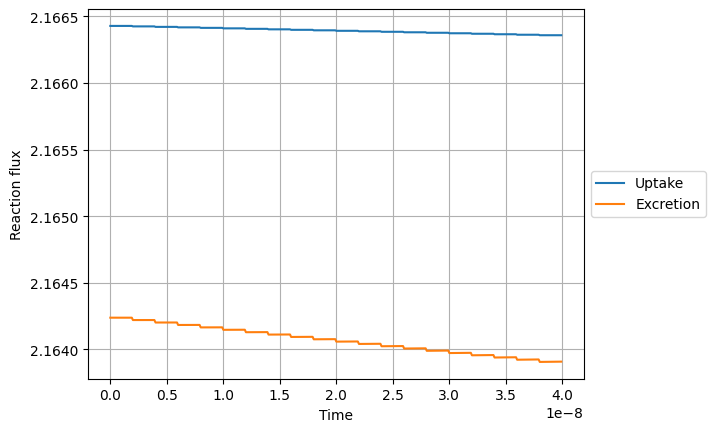

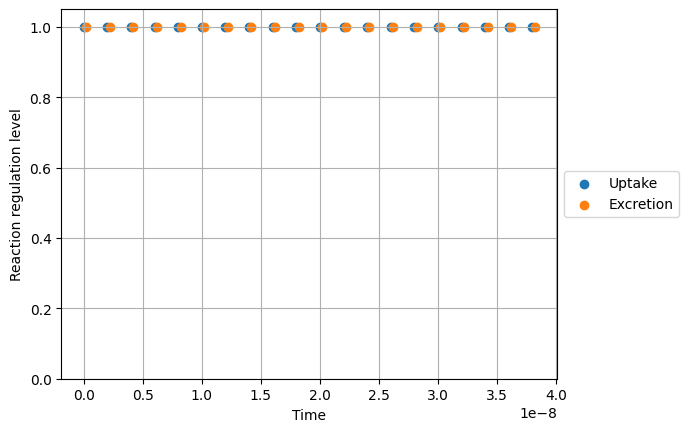

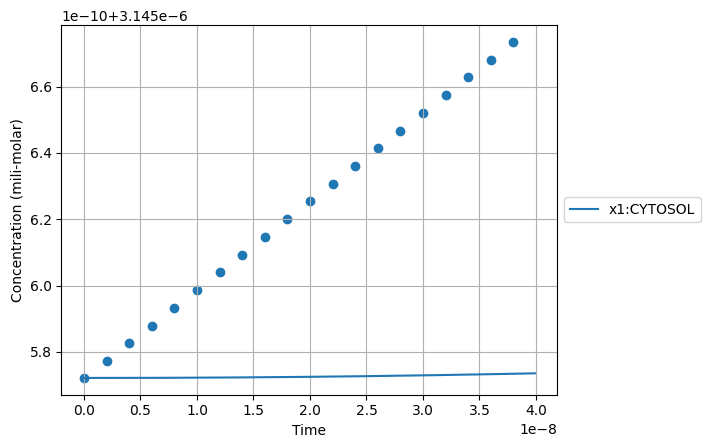

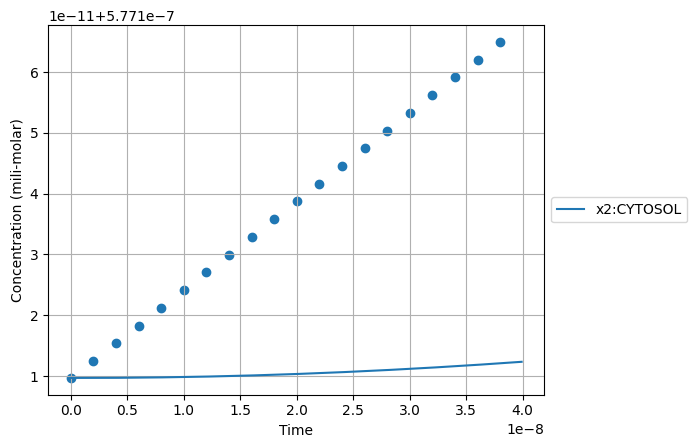

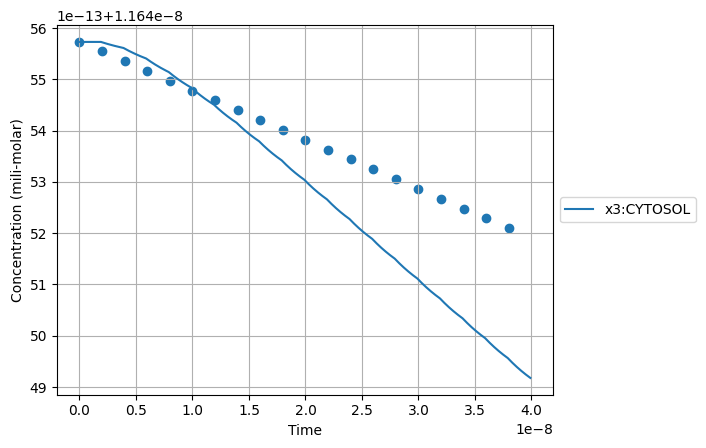

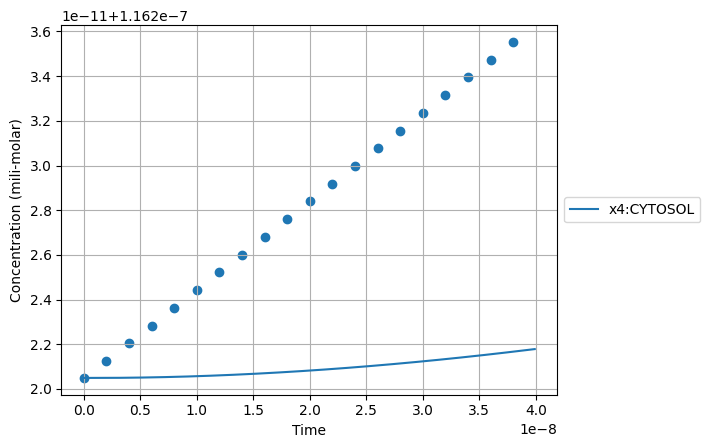

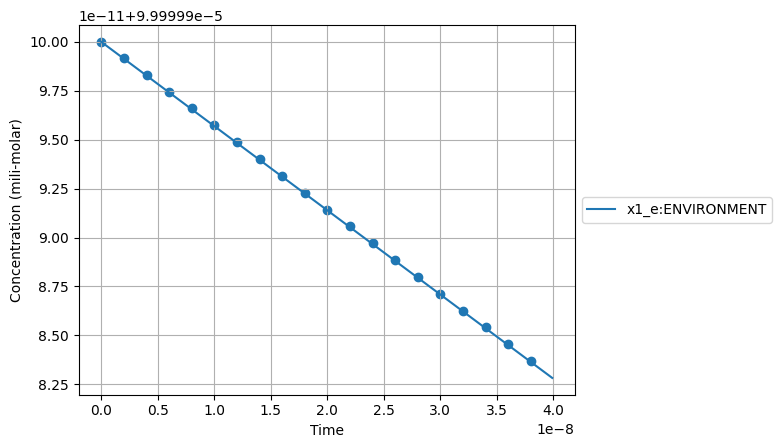

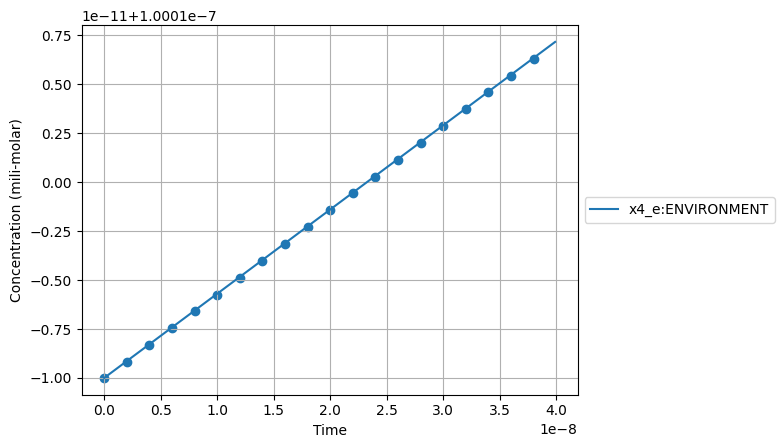

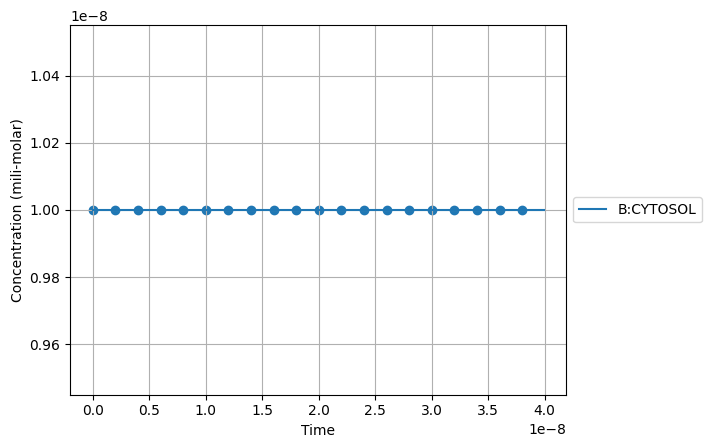

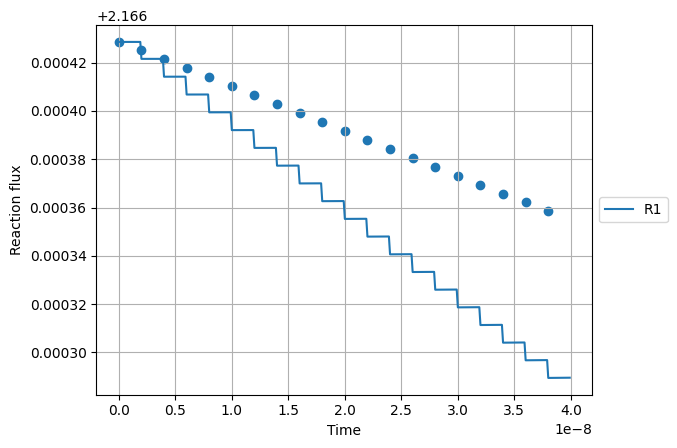

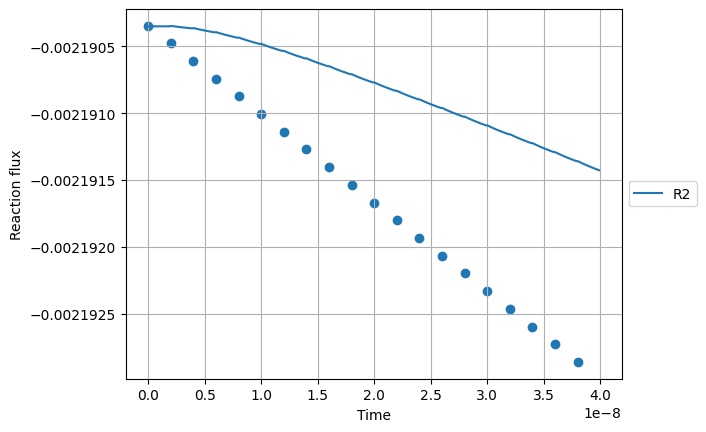

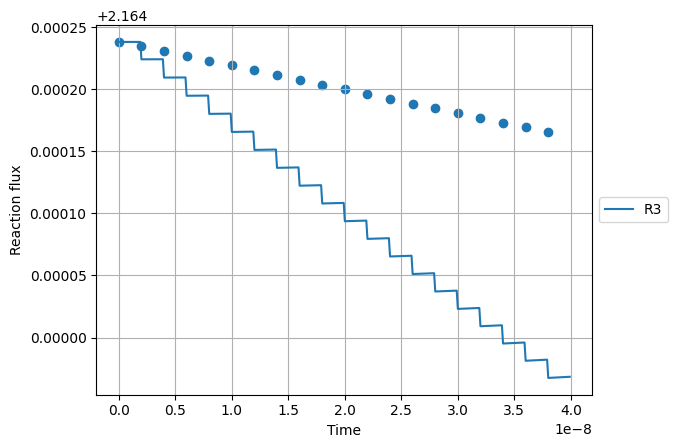

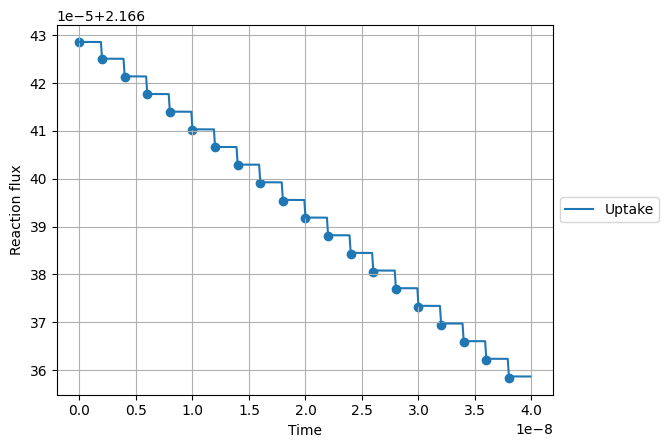

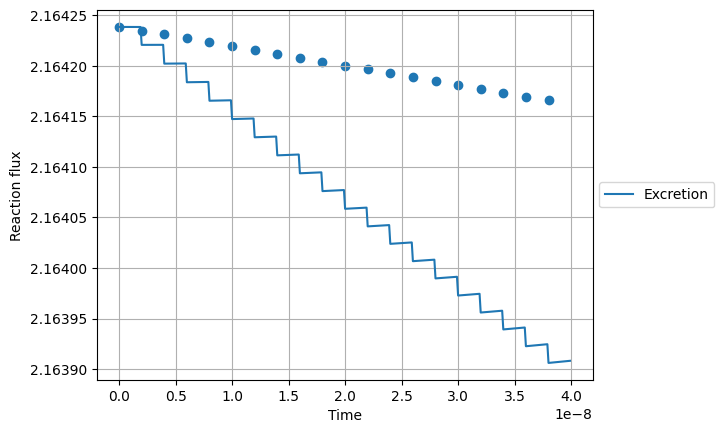

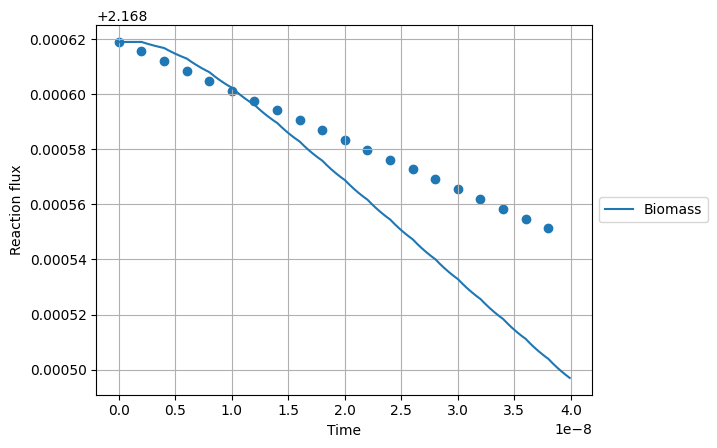

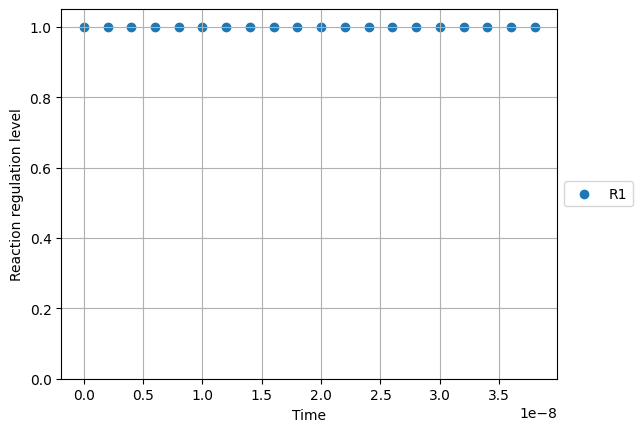

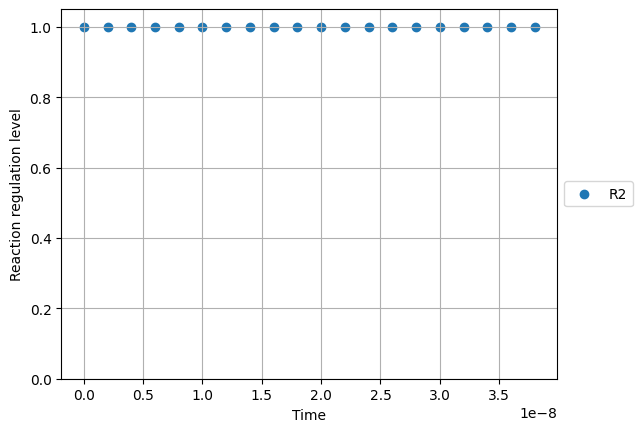

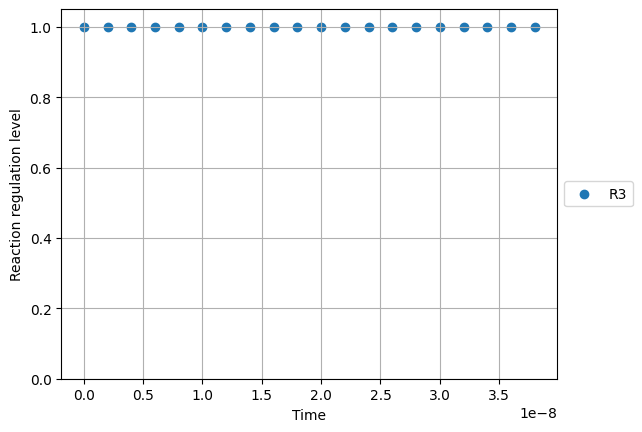

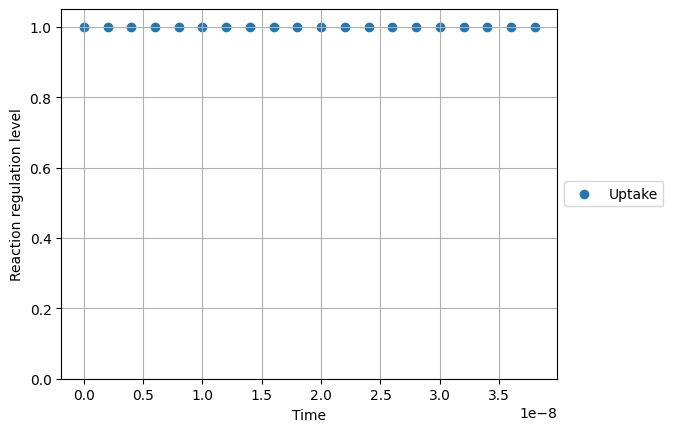

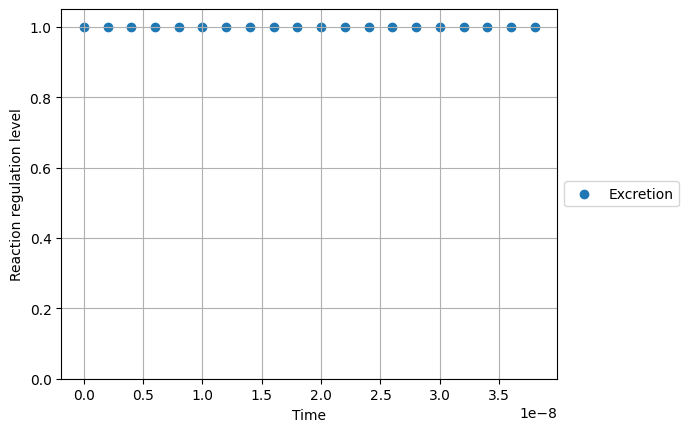

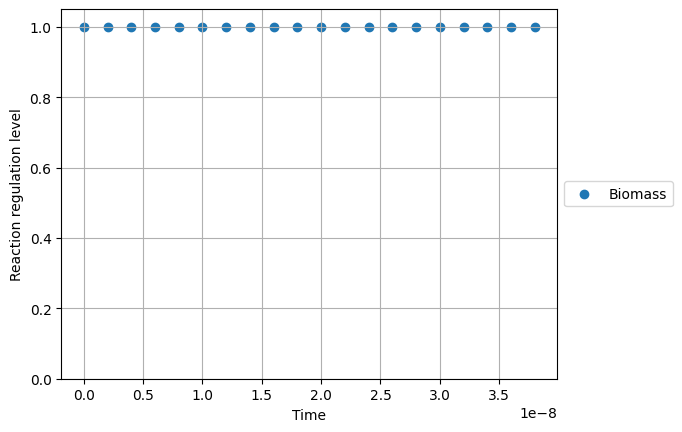

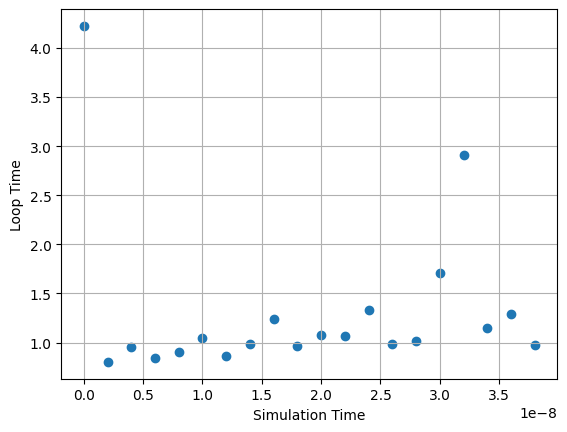

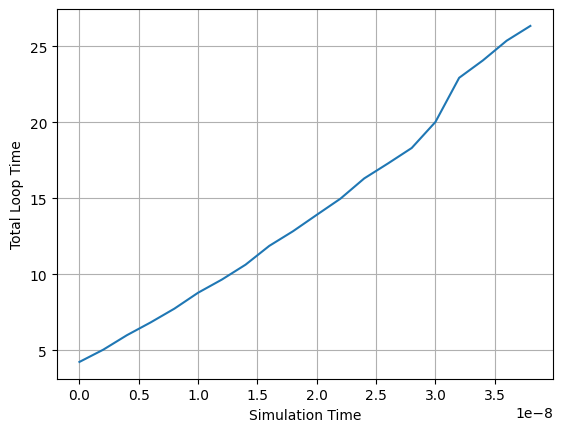

In [10]:
plot_dictionary={
    'biomass_metabolite':'B:CYTOSOL',
    'biomass_reaction':'Biomass',
    'time_limit':0,
    'metabolite_subset':[],
    'reaction_subset':[],
    'regulation_subset':[],
    'exchange_metabolite':['x1_e:ENVIRONMENT','x4_e:ENVIRONMENT'],
    'exchange_reaction':['Uptake','Excretion']
}
dyn.PlotFromPickle(control_dictionary,plot_dictionary)

Without regulation:

In [11]:
# these dictionaries are treated as having global scope
control_dictionary={
    'model_file_dir':'Saved_models', # default 'Saved_models'
    'solution_file_dir':'Saved_solutions', # default 'Saved_solutions'
    'pickle_output':'without_regulation.pkl',
    'parallel_solve':True,# boolean True/False
    'worker_count': 5,  # natural number, 0 or remove for cpu_count
    'delta_concentration':[1e-6], # list positive reals
    'delta_flux':[1], # list positive reals
    'mb':[100], # list positive naturals
    'zeta':[0.005], # list positive reals
    'swarm_size':10, # naturals, default is 2
    'linear_solver': 'ma57',
    'max_cpu_time':800000,
    'max_iter':100000,
    'acceptable_tol':1e-6,
    'solver_tol':1e-7,
    'feasibility_check':False,
    'feasibility_as_input':False,
    'annealing_check':False
#     'hsllib':'/opt/coinhsl/lib/libcoinhsl.dylib'
}

ode_system_dictionary={
    'dt':1e-10,
#     'nmax':4800000,
    'nmax':400,
    'stoichiometry_matrix':[],
    'metabolites_to_fix':['B:CYTOSOL'],
    'jump_tolerance':0.5,
    'stall_on_opt_jump':5,
#     'Opt_frequency':200000
    'Opt_frequency':20
}

environment_dictionary={
    'metabolites':['x1_e:ENVIRONMENT','x4_e:ENVIRONMENT'],
    'transport_reactions':['Uptake','Excretion'],
    'chemostat_type':[['Zero',{'Magnitude':1e-4}],['Zero',{'Magnitude':1e-6}]],
    'initial_environment_concentrations':[1.0e-4,1e-7], # molar
    'bath_volume':1.0,
    'glucose_diffusion_constant':600 # µm^2/sec
}


cell_dictionary={
    'model':'smallModel_lowK.pkl',#'smallModel_highK.pkl',
    'previous_best_model_solution':"",
    'environment_energy_name':'x1_e:ENVIRONMENT',
    'energy_import_reaction_name':'Uptake',
    'environment_compartment_name':'ENVIRONMENT',
#     'adaptation_constant':0.01,
    'initial_cell_density':3.3e-4,
    'birth_rate':1.0,
    'death_rate':0.008,
    'import_energy_metabolites':['x1_e:ENVIRONMENT','x4_e:ENVIRONMENT'],
    'import_energy_reactions':['Uptake','Excretion'],
    'import_energy_michaelis_menten':[0.04*1e-3,0.04*1e-3], # m moles
    
    'vmax':3.033e-12, # mM glucose consumed per hour per 1 micron^3 cell 
    'cell_volume':1e-15, 
    'hyphae_volume':4e3, # microns^3
    'N_avogadro':6.022140857e+23
    
}
  
# run the ThermoOpt method
metaboliteTraceDf,metabolitesOPT,fluxTraceDf,fluxOPT,regulationOPT,timesOPT,cell_density_vec,loopTimes = dyn.RunThermoOptNoRegulation(control_dictionary,ode_system_dictionary,environment_dictionary,cell_dictionary)

# run the simulation output into a pickle file 'pickle_output'
dyn.SaveSimulationOutput(control_dictionary,metaboliteTraceDf,metabolitesOPT,fluxTraceDf,fluxOPT,regulationOPT,timesOPT,cell_density_vec,loopTimes)

# delete the files created during the simulation 
dyn.CleanThermoOpt(control_dictionary)



Volume of cell: 1e-15
Surface area of cell: 4.835975862049414e-10
Volume of near field element: 9.047786842338601e-10
Volume ratio of Chemostat To Cell: 904778.6842338601
Sim Name: ChemostatModel_t_0.0_swarm_0_100_0.005_1e-06_1 objective: 116.12905298770934 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_1_100_0.005_1e-06_1 objective: 220.6249513454971 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_2_100_0.005_1e-06_1 objective: 220.62495136533104 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_3_100_0.005_1e-06_1 objective: 220.62495135647407 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_4_100_0.005_1e-06_1 objective: 220.62495134549044 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_5_100_0.005_1e-06_1 objective: 220.62495134548905 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_6_100_0.005_1e-06_1 objective: 220.62495133288644 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_7_100_0.005_1e-06_1 objective: 220.62495134056758 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_8_100_0.0

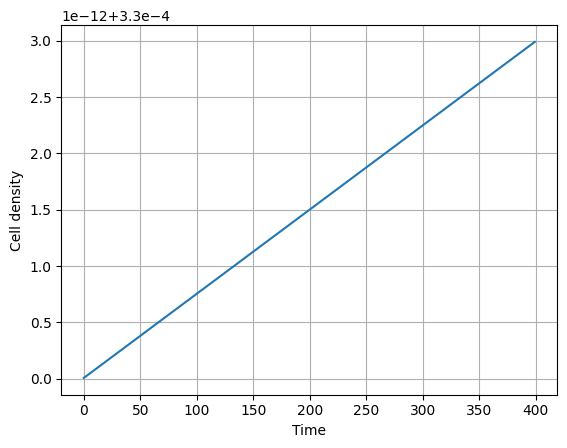

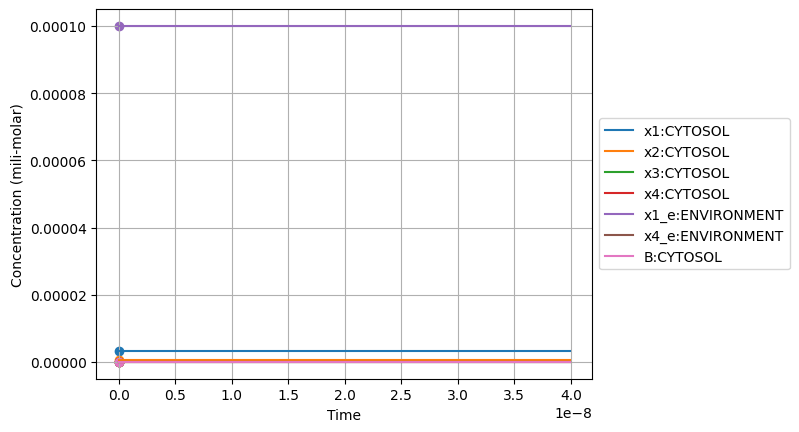

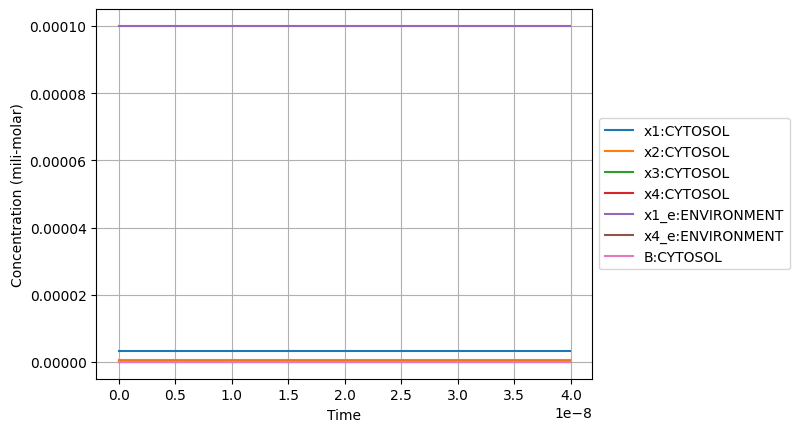

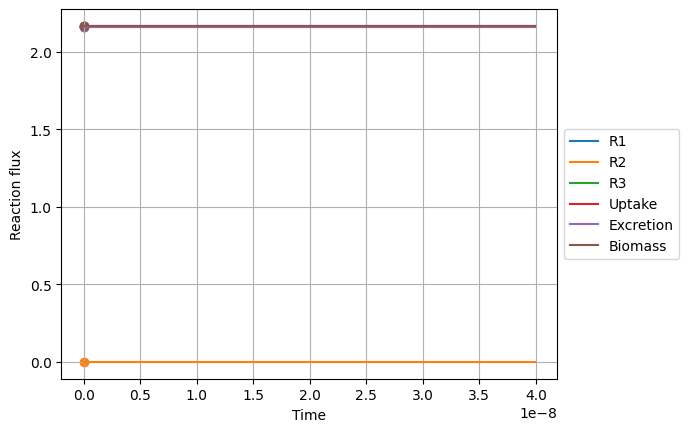

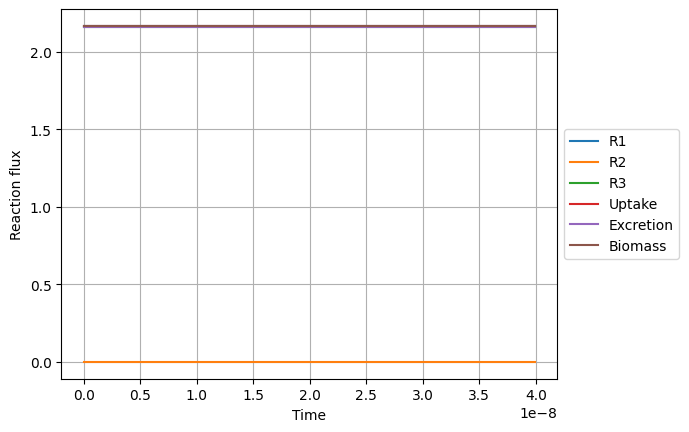

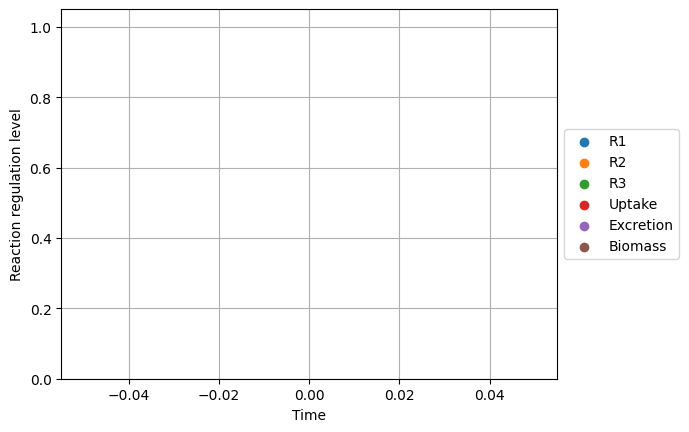

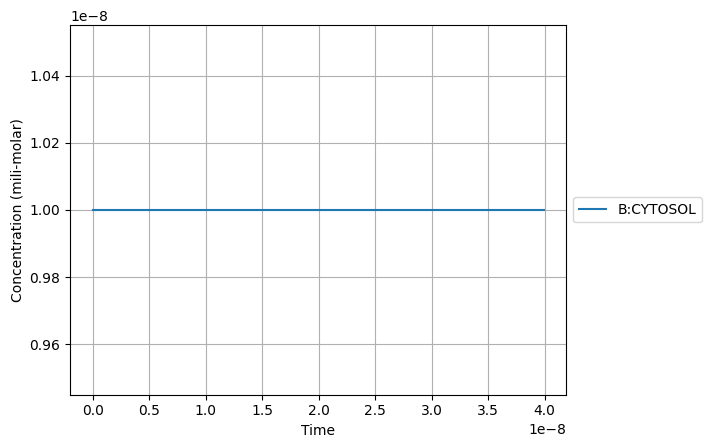

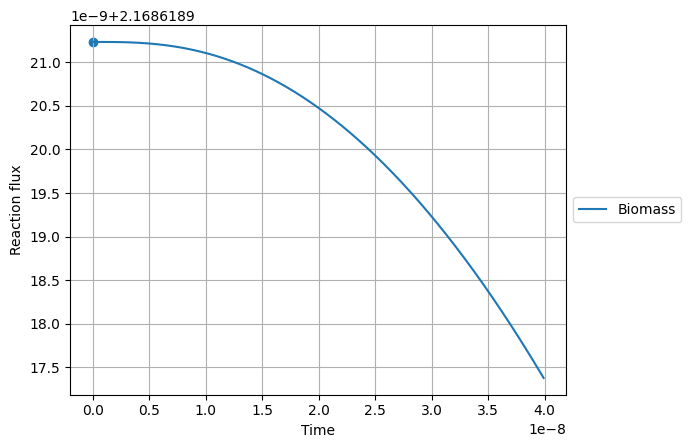

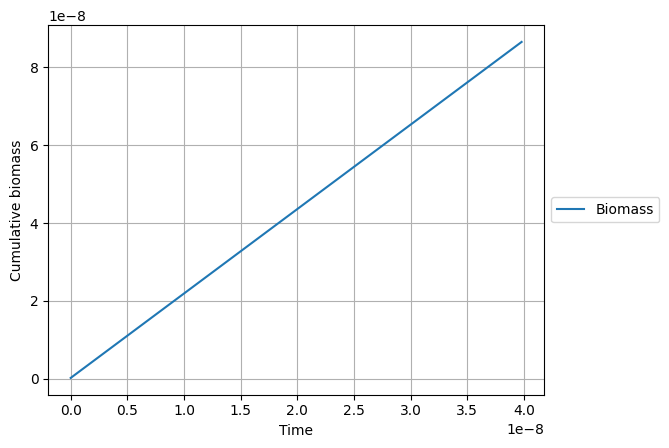

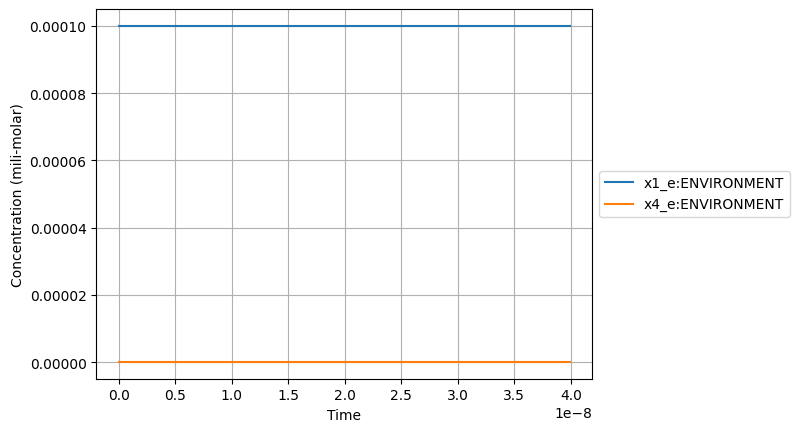

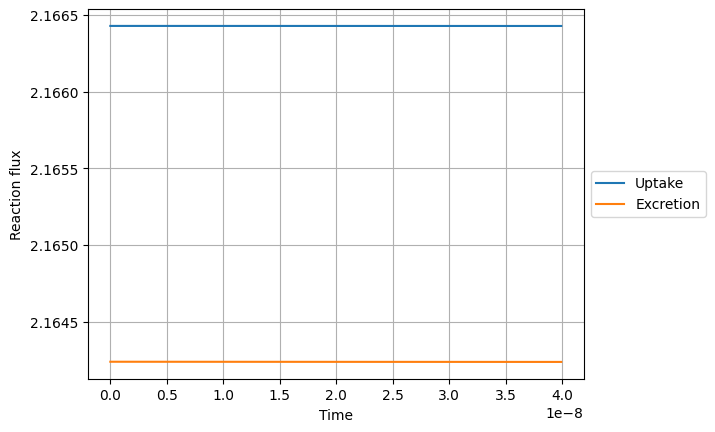

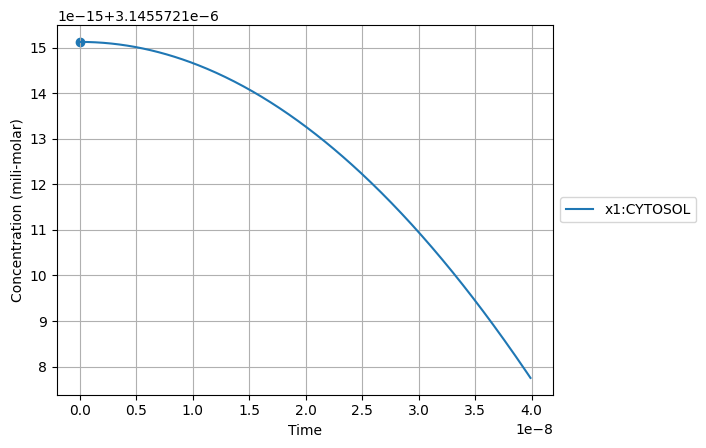

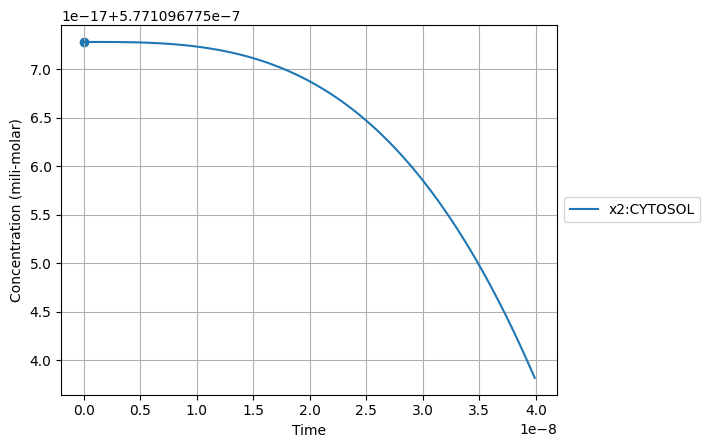

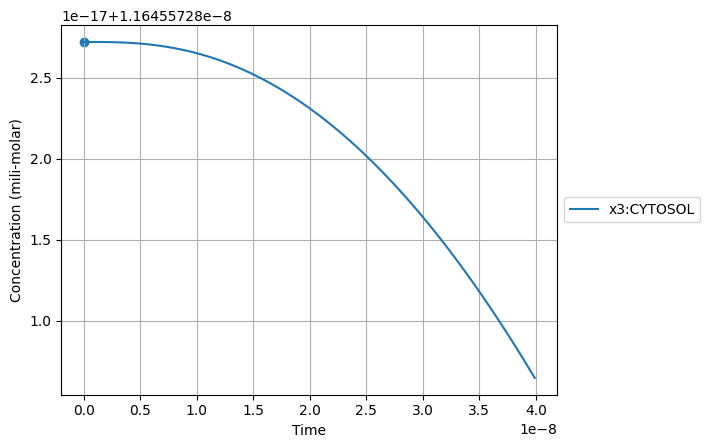

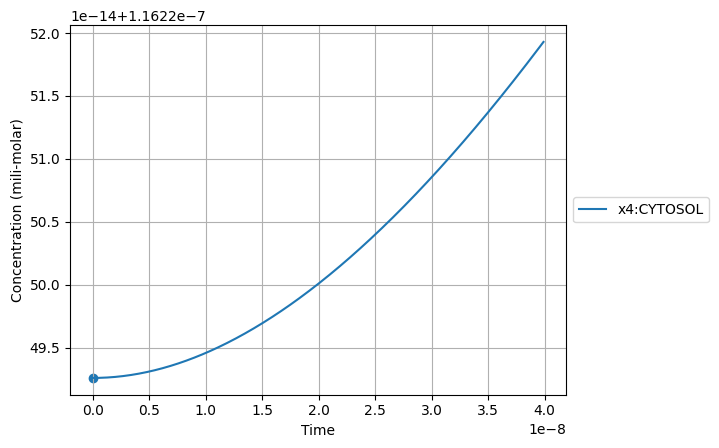

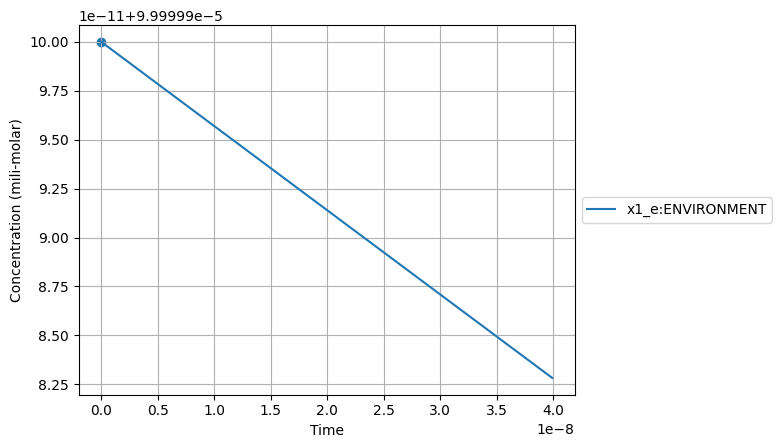

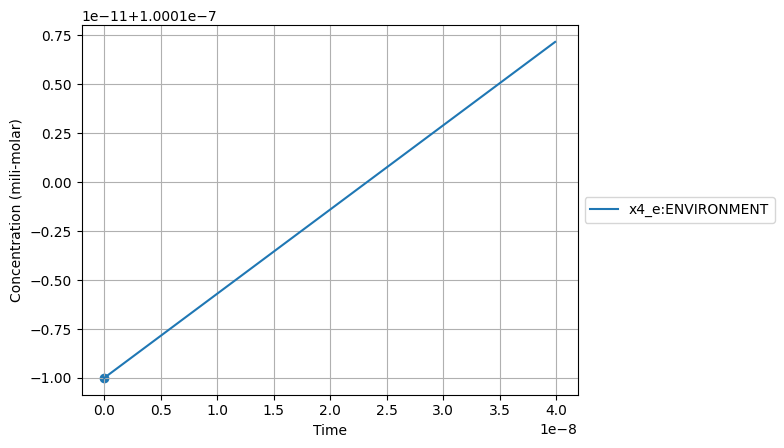

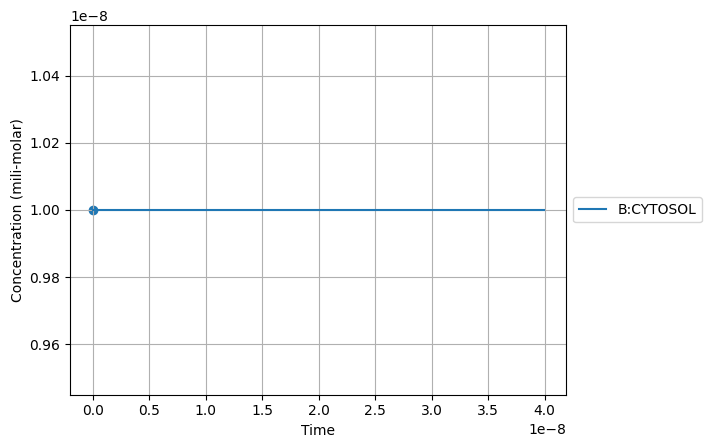

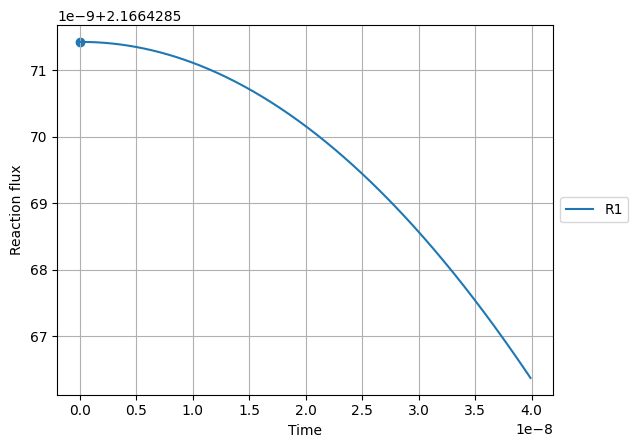

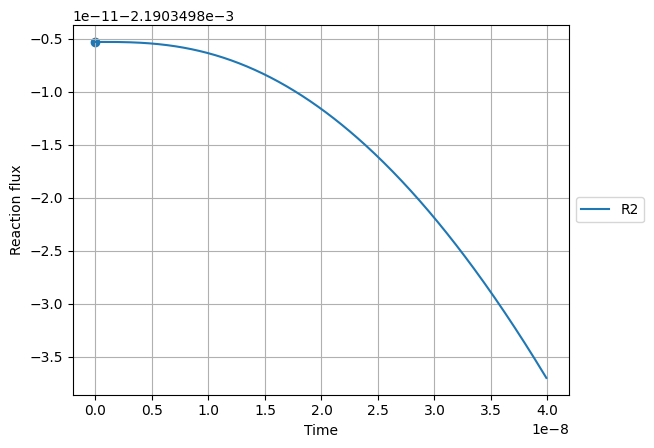

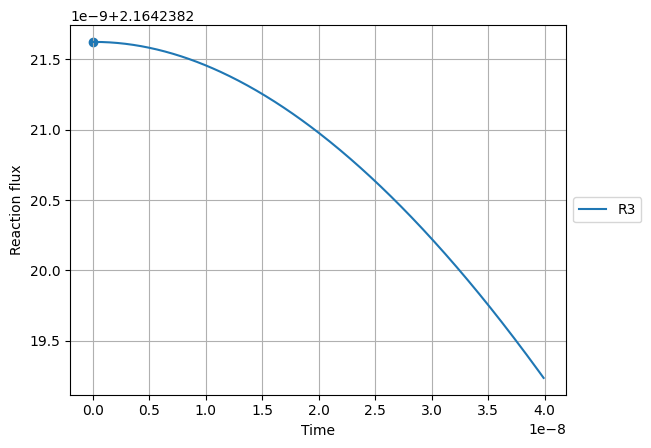

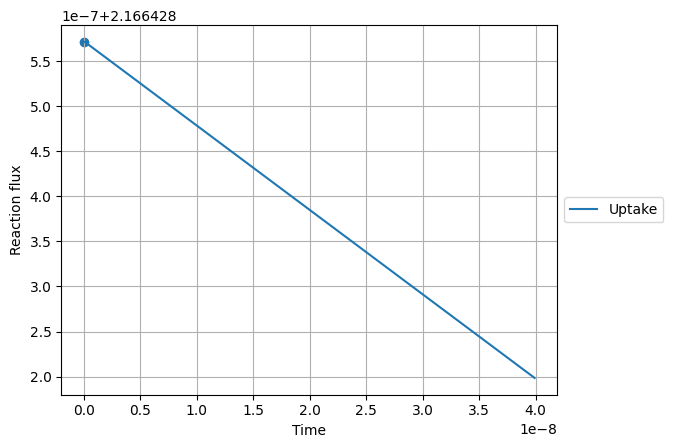

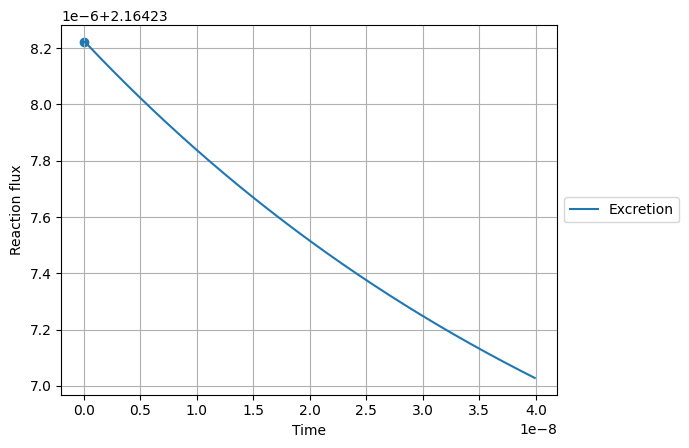

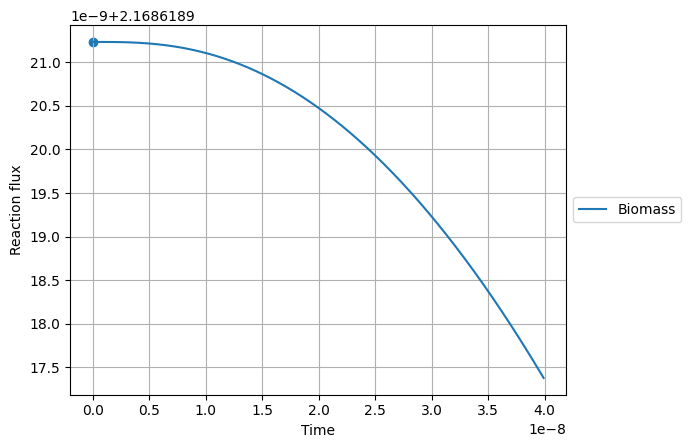

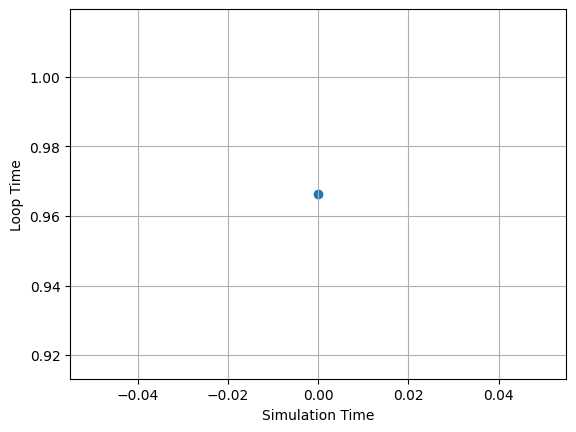

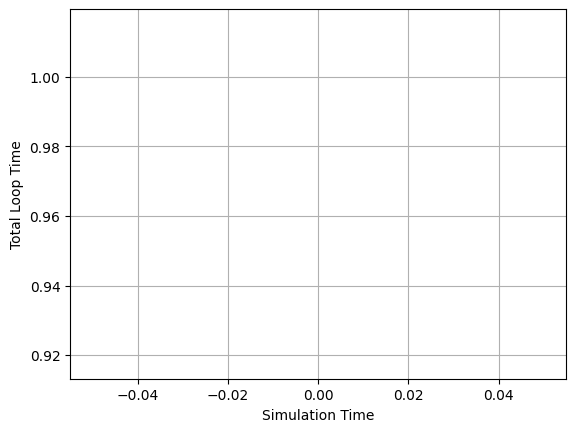

In [12]:
plot_dictionary={
    'biomass_metabolite':'B:CYTOSOL',
    'biomass_reaction':'Biomass',
    'time_limit':0,
    'metabolite_subset':[],
    'reaction_subset':[],
    'regulation_subset':[],
    'exchange_metabolite':['x1_e:ENVIRONMENT','x4_e:ENVIRONMENT'],
    'exchange_reaction':['Uptake','Excretion']
}
dyn.PlotFromPickle(control_dictionary,plot_dictionary)

In [13]:
dyn.CleanThermoOpt(control_dictionary)

# Large Scale: Population Model

In [ ]:
reload(dyn)
# these dictionaries are treated as having global scope
control_dictionary={
    'model_file_dir':'Saved_models', # default 'Saved_models'
    'solution_file_dir':'Saved_solutions', # default 'Saved_solutions'
    'pickle_output':'Population_model.pkl',
    'parallel_solve':True,# boolean True/False
    'worker_count': 5,  # natural number, 0 or remove for cpu_count
    'delta_concentration':[1e-6], # list positive reals
    'delta_flux':[1], # list positive reals
    'mb':[100], # list positive naturals
    'zeta':[0.005], # list positive reals
    'swarm_size':10, # naturals, default is 2
    'linear_solver': 'ma57',
    'max_cpu_time':800000,
    'max_iter':100000,
    'acceptable_tol':1e-6,
    'solver_tol':1e-7,
    'feasibility_check':False,
    'feasibility_as_input':False,
    'annealing_check':False
#     'hsllib':'/opt/coinhsl/lib/libcoinhsl.dylib'
}

ode_system_dictionary={
    'dt':1e-7,
#     'nmax':4800000,
    'nmax':10000000,
    'stoichiometry_matrix':[],
    'metabolites_to_fix':['B:CYTOSOL'], # now only for fixing external metabolites (empty or biomass ends up as 0)
    'jump_tolerance':0.5,
    'stall_on_opt_jump':5,
#     'Opt_frequency':200000
    'Opt_frequency':1000
}

environment_dictionary={
    'metabolites':['x1_e:ENVIRONMENT','x4_e:ENVIRONMENT'],
    'transport_reactions':['Uptake','Excretion'],
    'chemostat_type':[['Zero',{'Magnitude':1e-4}],['Zero',{'Magnitude':1e-6}]],
    'initial_environment_concentrations':[1.0e-4,1e-7], # molar
    'bath_volume':1.0,
    'glucose_diffusion_constant':600 # µm^2/sec
}


cell_dictionary={
    'model':'smallModel_lowK.pkl',#'smallModel_highK.pkl',
    'previous_best_model_solution':"",
    'environment_energy_name':'x1_e:ENVIRONMENT',
    'energy_import_reaction_name':'Uptake',
    'environment_compartment_name':'ENVIRONMENT',
    'biomass_reaction':'Biomass',
#     'adaptation_constant':0.01,
    'initial_cell_density':3.3e-4,
    'birth_rate':1.0,
    'death_rate':0.008,
    'import_energy_metabolites':['x1_e:ENVIRONMENT','x4_e:ENVIRONMENT'],
    'import_energy_reactions':['Uptake','Excretion'],
    'import_energy_michaelis_menten':[0.04*1e-3,0.04*1e-3], # m moles
    
    'vmax':3.033e-12, # mM glucose consumed per hour per 1 micron^3 cell 
    'cell_volume':1e-15, 
    'hyphae_volume':4e3, # microns^3
    'N_avogadro':6.022140857e+23
    
}
  
# run the ThermoOpt method
metaboliteTraceDf,metabolitesOPT,fluxTraceDf,fluxOPT,regulationOPT,timesOPT,cell_density_vec,loopTimes = dyn.RunThermoOptPopulationModel(control_dictionary,ode_system_dictionary,environment_dictionary,cell_dictionary)

# run the simulation output into a pickle file 'pickle_output'
dyn.SaveSimulationOutput(control_dictionary,metaboliteTraceDf,metabolitesOPT,fluxTraceDf,fluxOPT,regulationOPT,timesOPT,cell_density_vec,loopTimes)

# delete the files created during the simulation 
dyn.CleanThermoOpt(control_dictionary)



Volume of cell: 1e-15
Surface area of cell: 4.835975862049414e-10
Volume of near field element: 2.861161420549277e-05
Volume ratio of Chemostat To Cell: 28611614205.492767
Sim Name: ChemostatModel_t_0.0_swarm_0_100_0.005_1e-06_1 objective: 116.12905312708077 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_1_100_0.005_1e-06_1 objective: 220.62495137568197 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_2_100_0.005_1e-06_1 objective: 220.62495145354058 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_3_100_0.005_1e-06_1 objective: 116.12905299710587 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_4_100_0.005_1e-06_1 objective: 220.6249514284811 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_5_100_0.005_1e-06_1 objective: 220.62495132390745 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_6_100_0.005_1e-06_1 objective: 220.62495136641016 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_7_100_0.005_1e-06_1 objective: 116.12905298770873 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_8_100_0.

Sim Name: ChemostatModel_t_0.00019999999999999998_swarm_0_100_0.005_1e-06_1 objective: 196.74064811228206 status: ok
Sim Name: ChemostatModel_t_0.00019999999999999998_swarm_1_100_0.005_1e-06_1 objective: 196.74064811280883 status: ok
Sim Name: ChemostatModel_t_0.00019999999999999998_swarm_2_100_0.005_1e-06_1 objective: 116.10973788125305 status: ok
Sim Name: ChemostatModel_t_0.00019999999999999998_swarm_3_100_0.005_1e-06_1 objective: 116.10973788077918 status: ok
Sim Name: ChemostatModel_t_0.00019999999999999998_swarm_4_100_0.005_1e-06_1 objective: 196.74064805070935 status: ok
Sim Name: ChemostatModel_t_0.00019999999999999998_swarm_5_100_0.005_1e-06_1 objective: 116.10973788077919 status: ok
Sim Name: ChemostatModel_t_0.00019999999999999998_swarm_6_100_0.005_1e-06_1 objective: 116.10973788077767 status: ok
Sim Name: ChemostatModel_t_0.00019999999999999998_swarm_7_100_0.005_1e-06_1 objective: 116.10973788077891 status: ok
Sim Name: ChemostatModel_t_0.00019999999999999998_swarm_8_100_0.

Sim Name: ChemostatModel_t_0.0003_swarm_5_100_0.005_1e-06_1 objective: 116.10085766545286 status: ok
Sim Name: ChemostatModel_t_0.0003_swarm_6_100_0.005_1e-06_1 objective: 116.10085766545403 status: ok
Sim Name: ChemostatModel_t_0.0003_swarm_7_100_0.005_1e-06_1 objective: 116.1008576832431 status: ok
Sim Name: ChemostatModel_t_0.0003_swarm_8_100_0.005_1e-06_1 objective: -3.56841747723601e-09 status: ok
Sim Name: ChemostatModel_t_0.0003_swarm_9_100_0.005_1e-06_1 objective: 189.9262293517575 status: ok
Loop Time in seconds:  3.704568386077881
ETA in minutes:  617.4276938894749
Sim Name: ChemostatModel_t_0.00039999999999999996_swarm_0_100_0.005_1e-06_1 objective: 116.09230025384254 status: ok
Sim Name: ChemostatModel_t_0.00039999999999999996_swarm_1_100_0.005_1e-06_1 objective: 184.6226786129089 status: ok
Sim Name: ChemostatModel_t_0.00039999999999999996_swarm_2_100_0.005_1e-06_1 objective: 116.0923002279246 status: ok
Sim Name: ChemostatModel_t_0.00039999999999999996_swarm_3_100_0.005_1

Sim Name: ChemostatModel_t_0.001_swarm_0_100_0.005_1e-06_1 objective: 166.4315077354228 status: ok
Sim Name: ChemostatModel_t_0.001_swarm_1_100_0.005_1e-06_1 objective: 166.43150764827013 status: ok
Sim Name: ChemostatModel_t_0.001_swarm_2_100_0.005_1e-06_1 objective: 116.04501621426616 status: ok
Sim Name: ChemostatModel_t_0.001_swarm_3_100_0.005_1e-06_1 objective: 166.43150766603154 status: ok
Sim Name: ChemostatModel_t_0.001_swarm_4_100_0.005_1e-06_1 objective: 116.04501621165157 status: ok
Sim Name: ChemostatModel_t_0.001_swarm_5_100_0.005_1e-06_1 objective: 116.04501628220804 status: ok
Sim Name: ChemostatModel_t_0.001_swarm_6_100_0.005_1e-06_1 objective: 166.43150759744975 status: ok
Sim Name: ChemostatModel_t_0.001_swarm_7_100_0.005_1e-06_1 objective: 116.04501622270018 status: ok
Sim Name: ChemostatModel_t_0.001_swarm_8_100_0.005_1e-06_1 objective: 166.43150764217683 status: ok
Sim Name: ChemostatModel_t_0.001_swarm_9_100_0.005_1e-06_1 objective: 166.43150771052225 status: ok
L

Sim Name: ChemostatModel_t_0.0017_swarm_5_100_0.005_1e-06_1 objective: 155.98520542949603 status: ok
Sim Name: ChemostatModel_t_0.0017_swarm_6_100_0.005_1e-06_1 objective: 115.9947403195127 status: ok
Sim Name: ChemostatModel_t_0.0017_swarm_7_100_0.005_1e-06_1 objective: 155.9852054329378 status: ok
Sim Name: ChemostatModel_t_0.0017_swarm_8_100_0.005_1e-06_1 objective: 115.99474026083934 status: ok
Sim Name: ChemostatModel_t_0.0017_swarm_9_100_0.005_1e-06_1 objective: 155.98520544702228 status: ok
Loop Time in seconds:  1.912865161895752
ETA in minutes:  318.8106690294425
Sim Name: ChemostatModel_t_0.0018_swarm_0_100_0.005_1e-06_1 objective: 115.98783044003987 status: ok
Sim Name: ChemostatModel_t_0.0018_swarm_1_100_0.005_1e-06_1 objective: 115.98783034809225 status: ok
Sim Name: ChemostatModel_t_0.0018_swarm_2_100_0.005_1e-06_1 objective: 115.98783037322288 status: ok
Sim Name: ChemostatModel_t_0.0018_swarm_3_100_0.005_1e-06_1 objective: 115.98783049804518 status: ok
Sim Name: Chemost

Sim Name: ChemostatModel_t_0.0025_swarm_0_100_0.005_1e-06_1 objective: 115.94083486075363 status: ok
Sim Name: ChemostatModel_t_0.0025_swarm_1_100_0.005_1e-06_1 objective: 115.94083486075354 status: ok
Sim Name: ChemostatModel_t_0.0025_swarm_2_100_0.005_1e-06_1 objective: 148.8343347911417 status: ok
Sim Name: ChemostatModel_t_0.0025_swarm_3_100_0.005_1e-06_1 objective: 148.83433480125763 status: ok
Sim Name: ChemostatModel_t_0.0025_swarm_4_100_0.005_1e-06_1 objective: 148.83433480125763 status: ok
Sim Name: ChemostatModel_t_0.0025_swarm_5_100_0.005_1e-06_1 objective: 148.8343348012577 status: ok
Sim Name: ChemostatModel_t_0.0025_swarm_6_100_0.005_1e-06_1 objective: 115.94083486075338 status: ok
Sim Name: ChemostatModel_t_0.0025_swarm_7_100_0.005_1e-06_1 objective: 115.94083486075358 status: ok
Sim Name: ChemostatModel_t_0.0025_swarm_8_100_0.005_1e-06_1 objective: 148.83433483276994 status: ok
Sim Name: ChemostatModel_t_0.0025_swarm_9_100_0.005_1e-06_1 objective: 148.8343348012572 stat

Sim Name: ChemostatModel_t_0.0031999999999999997_swarm_5_100_0.005_1e-06_1 objective: 144.53168167697757 status: ok
Sim Name: ChemostatModel_t_0.0031999999999999997_swarm_6_100_0.005_1e-06_1 objective: 144.53168177354442 status: ok
Sim Name: ChemostatModel_t_0.0031999999999999997_swarm_7_100_0.005_1e-06_1 objective: 115.89571649882585 status: ok
Sim Name: ChemostatModel_t_0.0031999999999999997_swarm_8_100_0.005_1e-06_1 objective: 115.89571648930541 status: ok
Sim Name: ChemostatModel_t_0.0031999999999999997_swarm_9_100_0.005_1e-06_1 objective: 115.89571649388351 status: ok
Loop Time in seconds:  2.1667888164520264
ETA in minutes:  361.1312527297894
Sim Name: ChemostatModel_t_0.0033_swarm_0_100_0.005_1e-06_1 objective: 115.88939360926754 status: ok
Sim Name: ChemostatModel_t_0.0033_swarm_1_100_0.005_1e-06_1 objective: 115.88939358765927 status: ok
Sim Name: ChemostatModel_t_0.0033_swarm_2_100_0.005_1e-06_1 objective: 115.88939370049437 status: ok
Sim Name: ChemostatModel_t_0.0033_swarm_

Sim Name: ChemostatModel_t_0.004_swarm_0_100_0.005_1e-06_1 objective: 115.84584809858293 status: ok
Sim Name: ChemostatModel_t_0.004_swarm_1_100_0.005_1e-06_1 objective: 140.8546442152051 status: ok
Sim Name: ChemostatModel_t_0.004_swarm_2_100_0.005_1e-06_1 objective: 115.84584811871723 status: ok
Sim Name: ChemostatModel_t_0.004_swarm_3_100_0.005_1e-06_1 objective: 115.84584811648996 status: ok
Sim Name: ChemostatModel_t_0.004_swarm_4_100_0.005_1e-06_1 objective: 140.8546442995244 status: ok
Sim Name: ChemostatModel_t_0.004_swarm_5_100_0.005_1e-06_1 objective: 140.85464415824526 status: ok
Sim Name: ChemostatModel_t_0.004_swarm_6_100_0.005_1e-06_1 objective: 115.84584807900984 status: ok
Sim Name: ChemostatModel_t_0.004_swarm_7_100_0.005_1e-06_1 objective: 115.84584809904784 status: ok
Sim Name: ChemostatModel_t_0.004_swarm_8_100_0.005_1e-06_1 objective: 115.84584807387279 status: ok
Sim Name: ChemostatModel_t_0.004_swarm_9_100_0.005_1e-06_1 objective: 115.84584810742355 status: ok
Lo

Sim Name: ChemostatModel_t_0.0047_swarm_5_100_0.005_1e-06_1 objective: 138.33126946174616 status: ok
Sim Name: ChemostatModel_t_0.0047_swarm_6_100_0.005_1e-06_1 objective: 138.33126950400498 status: ok
Sim Name: ChemostatModel_t_0.0047_swarm_7_100_0.005_1e-06_1 objective: 138.33126947603301 status: ok
Sim Name: ChemostatModel_t_0.0047_swarm_8_100_0.005_1e-06_1 objective: 115.80337292853237 status: ok
Sim Name: ChemostatModel_t_0.0047_swarm_9_100_0.005_1e-06_1 objective: 115.80337288907992 status: ok
Loop Time in seconds:  3.46807861328125
ETA in minutes:  578.0127554056803
Sim Name: ChemostatModel_t_0.0048_swarm_0_100_0.005_1e-06_1 objective: 138.01040029700508 status: ok
Sim Name: ChemostatModel_t_0.0048_swarm_1_100_0.005_1e-06_1 objective: 115.79738048748854 status: ok
Sim Name: ChemostatModel_t_0.0048_swarm_2_100_0.005_1e-06_1 objective: 115.79738048748811 status: ok
Sim Name: ChemostatModel_t_0.0048_swarm_3_100_0.005_1e-06_1 objective: 138.01040029702224 status: ok
Sim Name: Chemos

Sim Name: ChemostatModel_t_0.0055_swarm_0_100_0.005_1e-06_1 objective: 135.98414244197235 status: ok
Sim Name: ChemostatModel_t_0.0055_swarm_1_100_0.005_1e-06_1 objective: 115.75589833813683 status: ok
Sim Name: ChemostatModel_t_0.0055_swarm_2_100_0.005_1e-06_1 objective: 115.75589828486156 status: ok
Sim Name: ChemostatModel_t_0.0055_swarm_3_100_0.005_1e-06_1 objective: 135.98414243023026 status: ok
Sim Name: ChemostatModel_t_0.0055_swarm_4_100_0.005_1e-06_1 objective: 115.75589828486169 status: ok
Sim Name: ChemostatModel_t_0.0055_swarm_5_100_0.005_1e-06_1 objective: 135.98414247304558 status: ok
Sim Name: ChemostatModel_t_0.0055_swarm_6_100_0.005_1e-06_1 objective: 135.9841424302311 status: ok
Sim Name: ChemostatModel_t_0.0055_swarm_7_100_0.005_1e-06_1 objective: 115.75589833797999 status: ok
Sim Name: ChemostatModel_t_0.0055_swarm_8_100_0.005_1e-06_1 objective: 135.98414243022967 status: ok
Sim Name: ChemostatModel_t_0.0055_swarm_9_100_0.005_1e-06_1 objective: 115.75589828486252 st

Sim Name: ChemostatModel_t_0.0062_swarm_5_100_0.005_1e-06_1 objective: 115.71514083664997 status: ok
Sim Name: ChemostatModel_t_0.0062_swarm_6_100_0.005_1e-06_1 objective: 115.71514090756688 status: ok
Sim Name: ChemostatModel_t_0.0062_swarm_7_100_0.005_1e-06_1 objective: 115.71514083664991 status: ok
Sim Name: ChemostatModel_t_0.0062_swarm_8_100_0.005_1e-06_1 objective: 115.71514083664975 status: ok
Sim Name: ChemostatModel_t_0.0062_swarm_9_100_0.005_1e-06_1 objective: 115.71514090756772 status: ok
Loop Time in seconds:  1.6345562934875488
ETA in minutes:  272.42588545896217
Sim Name: ChemostatModel_t_0.0063_swarm_0_100_0.005_1e-06_1 objective: 115.70937134387249 status: ok
Sim Name: ChemostatModel_t_0.0063_swarm_1_100_0.005_1e-06_1 objective: 115.70937136160119 status: ok
Sim Name: ChemostatModel_t_0.0063_swarm_2_100_0.005_1e-06_1 objective: 115.70937138819254 status: ok
Sim Name: ChemostatModel_t_0.0063_swarm_3_100_0.005_1e-06_1 objective: 115.70937134387026 status: ok
Sim Name: Che

Sim Name: ChemostatModel_t_0.006999999999999999_swarm_0_100_0.005_1e-06_1 objective: 115.66932062524454 status: ok
Sim Name: ChemostatModel_t_0.006999999999999999_swarm_1_100_0.005_1e-06_1 objective: 132.6033848573088 status: ok
Sim Name: ChemostatModel_t_0.006999999999999999_swarm_2_100_0.005_1e-06_1 objective: 115.66932059433773 status: ok
Sim Name: ChemostatModel_t_0.006999999999999999_swarm_3_100_0.005_1e-06_1 objective: 132.6033848360233 status: ok
Sim Name: ChemostatModel_t_0.006999999999999999_swarm_4_100_0.005_1e-06_1 objective: 132.60338488137373 status: ok
Sim Name: ChemostatModel_t_0.006999999999999999_swarm_5_100_0.005_1e-06_1 objective: 132.60338482536704 status: ok
Sim Name: ChemostatModel_t_0.006999999999999999_swarm_6_100_0.005_1e-06_1 objective: 115.66932060243869 status: ok
Sim Name: ChemostatModel_t_0.006999999999999999_swarm_7_100_0.005_1e-06_1 objective: 115.66932059433825 status: ok
Sim Name: ChemostatModel_t_0.006999999999999999_swarm_8_100_0.005_1e-06_1 objectiv

Sim Name: ChemostatModel_t_0.007699999999999999_swarm_5_100_0.005_1e-06_1 objective: 131.34135182070477 status: ok
Sim Name: ChemostatModel_t_0.007699999999999999_swarm_6_100_0.005_1e-06_1 objective: 115.629805826089 status: ok
Sim Name: ChemostatModel_t_0.007699999999999999_swarm_7_100_0.005_1e-06_1 objective: 131.34135182847524 status: ok
Sim Name: ChemostatModel_t_0.007699999999999999_swarm_8_100_0.005_1e-06_1 objective: 131.3413518485642 status: ok
Sim Name: ChemostatModel_t_0.007699999999999999_swarm_9_100_0.005_1e-06_1 objective: 115.62980580456781 status: ok
Loop Time in seconds:  1.726623296737671
ETA in minutes:  287.77037679394886
Sim Name: ChemostatModel_t_0.0078_swarm_0_100_0.005_1e-06_1 objective: 115.62420085962098 status: ok
Sim Name: ChemostatModel_t_0.0078_swarm_1_100_0.005_1e-06_1 objective: 115.62420085962287 status: ok
Sim Name: ChemostatModel_t_0.0078_swarm_2_100_0.005_1e-06_1 objective: 115.62420085962121 status: ok
Sim Name: ChemostatModel_t_0.0078_swarm_3_100_0.

Sim Name: ChemostatModel_t_0.008499999999999999_swarm_0_100_0.005_1e-06_1 objective: 115.58522441086585 status: ok
Sim Name: ChemostatModel_t_0.008499999999999999_swarm_1_100_0.005_1e-06_1 objective: 130.07672616130395 status: ok
Sim Name: ChemostatModel_t_0.008499999999999999_swarm_2_100_0.005_1e-06_1 objective: 130.0767261613046 status: ok
Sim Name: ChemostatModel_t_0.008499999999999999_swarm_3_100_0.005_1e-06_1 objective: 115.58522441086507 status: ok
Sim Name: ChemostatModel_t_0.008499999999999999_swarm_4_100_0.005_1e-06_1 objective: 115.58522441086463 status: ok
Sim Name: ChemostatModel_t_0.008499999999999999_swarm_5_100_0.005_1e-06_1 objective: 130.0767261527626 status: ok
Sim Name: ChemostatModel_t_0.008499999999999999_swarm_6_100_0.005_1e-06_1 objective: 115.58522441086552 status: ok
Sim Name: ChemostatModel_t_0.008499999999999999_swarm_7_100_0.005_1e-06_1 objective: 115.5852244329312 status: ok
Sim Name: ChemostatModel_t_0.008499999999999999_swarm_8_100_0.005_1e-06_1 objective

Sim Name: ChemostatModel_t_0.0092_swarm_5_100_0.005_1e-06_1 objective: 115.54666624083502 status: ok
Sim Name: ChemostatModel_t_0.0092_swarm_6_100_0.005_1e-06_1 objective: 115.5466662410291 status: ok
Sim Name: ChemostatModel_t_0.0092_swarm_7_100_0.005_1e-06_1 objective: 115.54666627029756 status: ok
Sim Name: ChemostatModel_t_0.0092_swarm_8_100_0.005_1e-06_1 objective: 115.54666624083376 status: ok
Sim Name: ChemostatModel_t_0.0092_swarm_9_100_0.005_1e-06_1 objective: 115.54666624083322 status: ok
Loop Time in seconds:  1.4522945880889893
ETA in minutes:  242.04895278537276
Sim Name: ChemostatModel_t_0.0093_swarm_0_100_0.005_1e-06_1 objective: 115.541189632758 status: ok
Sim Name: ChemostatModel_t_0.0093_swarm_1_100_0.005_1e-06_1 objective: 128.96480719211047 status: ok
Sim Name: ChemostatModel_t_0.0093_swarm_2_100_0.005_1e-06_1 objective: 115.54118961505431 status: ok
Sim Name: ChemostatModel_t_0.0093_swarm_3_100_0.005_1e-06_1 objective: 115.54118961505583 status: ok
Sim Name: Chemos

Sim Name: ChemostatModel_t_0.01_swarm_0_100_0.005_1e-06_1 objective: 115.50305996689582 status: ok
Sim Name: ChemostatModel_t_0.01_swarm_1_100_0.005_1e-06_1 objective: 115.50305996689613 status: ok
Sim Name: ChemostatModel_t_0.01_swarm_2_100_0.005_1e-06_1 objective: 115.5030599668968 status: ok
Sim Name: ChemostatModel_t_0.01_swarm_3_100_0.005_1e-06_1 objective: 115.5030599668958 status: ok
Sim Name: ChemostatModel_t_0.01_swarm_4_100_0.005_1e-06_1 objective: 128.0944524816755 status: ok
Sim Name: ChemostatModel_t_0.01_swarm_5_100_0.005_1e-06_1 objective: 128.0944524816749 status: ok
Sim Name: ChemostatModel_t_0.01_swarm_6_100_0.005_1e-06_1 objective: 115.50305996689505 status: ok
Sim Name: ChemostatModel_t_0.01_swarm_7_100_0.005_1e-06_1 objective: 115.50305996689622 status: ok
Sim Name: ChemostatModel_t_0.01_swarm_8_100_0.005_1e-06_1 objective: 115.50305999343948 status: ok
Sim Name: ChemostatModel_t_0.01_swarm_9_100_0.005_1e-06_1 objective: 115.50305996689586 status: ok
Loop Time in s

Sim Name: ChemostatModel_t_0.0107_swarm_5_100_0.005_1e-06_1 objective: 127.3042947713646 status: ok
Sim Name: ChemostatModel_t_0.0107_swarm_6_100_0.005_1e-06_1 objective: 127.30429473489532 status: ok
Sim Name: ChemostatModel_t_0.0107_swarm_7_100_0.005_1e-06_1 objective: 115.46526886296736 status: ok
Sim Name: ChemostatModel_t_0.0107_swarm_8_100_0.005_1e-06_1 objective: 127.30429475833893 status: ok
Sim Name: ChemostatModel_t_0.0107_swarm_9_100_0.005_1e-06_1 objective: 127.3042947441151 status: ok
Loop Time in seconds:  1.4573843479156494
ETA in minutes:  242.89724558084012
Sim Name: ChemostatModel_t_0.010799999999999999_swarm_0_100_0.005_1e-06_1 objective: 115.45989607138335 status: ok
Sim Name: ChemostatModel_t_0.010799999999999999_swarm_1_100_0.005_1e-06_1 objective: 115.45989603680607 status: ok
Sim Name: ChemostatModel_t_0.010799999999999999_swarm_2_100_0.005_1e-06_1 objective: 115.4598960661904 status: ok
Sim Name: ChemostatModel_t_0.010799999999999999_swarm_3_100_0.005_1e-06_1 o

Sim Name: ChemostatModel_t_0.0115_swarm_0_100_0.005_1e-06_1 objective: 115.42245666918198 status: ok
Sim Name: ChemostatModel_t_0.0115_swarm_1_100_0.005_1e-06_1 objective: 126.4845645751764 status: ok
Sim Name: ChemostatModel_t_0.0115_swarm_2_100_0.005_1e-06_1 objective: 115.422456669182 status: ok
Sim Name: ChemostatModel_t_0.0115_swarm_3_100_0.005_1e-06_1 objective: 115.42245666918181 status: ok
Sim Name: ChemostatModel_t_0.0115_swarm_4_100_0.005_1e-06_1 objective: 115.42245667346431 status: ok
Sim Name: ChemostatModel_t_0.0115_swarm_5_100_0.005_1e-06_1 objective: 126.48456457517403 status: ok
Sim Name: ChemostatModel_t_0.0115_swarm_6_100_0.005_1e-06_1 objective: 126.4845645751739 status: ok
Sim Name: ChemostatModel_t_0.0115_swarm_7_100_0.005_1e-06_1 objective: 126.48456457517423 status: ok
Sim Name: ChemostatModel_t_0.0115_swarm_8_100_0.005_1e-06_1 objective: 115.42245669114826 status: ok
Sim Name: ChemostatModel_t_0.0115_swarm_9_100_0.005_1e-06_1 objective: 115.42245669570833 statu

Sim Name: ChemostatModel_t_0.012199999999999999_swarm_5_100_0.005_1e-06_1 objective: 125.82974618462964 status: ok
Sim Name: ChemostatModel_t_0.012199999999999999_swarm_6_100_0.005_1e-06_1 objective: 125.8297461412874 status: ok
Sim Name: ChemostatModel_t_0.012199999999999999_swarm_7_100_0.005_1e-06_1 objective: 125.82974614128719 status: ok
Sim Name: ChemostatModel_t_0.012199999999999999_swarm_8_100_0.005_1e-06_1 objective: 115.3852985939382 status: ok
Sim Name: ChemostatModel_t_0.012199999999999999_swarm_9_100_0.005_1e-06_1 objective: 115.38529859394025 status: ok
Loop Time in seconds:  1.5063962936401367
ETA in minutes:  251.06589830039346
Sim Name: ChemostatModel_t_0.0123_swarm_0_100_0.005_1e-06_1 objective: 115.38001197783635 status: ok
Sim Name: ChemostatModel_t_0.0123_swarm_1_100_0.005_1e-06_1 objective: 115.38001197379724 status: ok
Sim Name: ChemostatModel_t_0.0123_swarm_2_100_0.005_1e-06_1 objective: 115.38001197408182 status: ok
Sim Name: ChemostatModel_t_0.0123_swarm_3_100_

Sim Name: ChemostatModel_t_0.0129_swarm_0_100_0.005_1e-06_1 objective: 115.34840033577339 status: ok
Sim Name: ChemostatModel_t_0.0129_swarm_1_100_0.005_1e-06_1 objective: 115.3484003357741 status: ok
Sim Name: ChemostatModel_t_0.0129_swarm_2_100_0.005_1e-06_1 objective: 125.22528913996788 status: ok
Sim Name: ChemostatModel_t_0.0129_swarm_3_100_0.005_1e-06_1 objective: 125.22528914213736 status: ok
Sim Name: ChemostatModel_t_0.0129_swarm_4_100_0.005_1e-06_1 objective: 125.22528913996831 status: ok
Sim Name: ChemostatModel_t_0.0129_swarm_5_100_0.005_1e-06_1 objective: 125.22528913996867 status: ok
Sim Name: ChemostatModel_t_0.0129_swarm_6_100_0.005_1e-06_1 objective: 115.34840033577326 status: ok
Sim Name: ChemostatModel_t_0.0129_swarm_7_100_0.005_1e-06_1 objective: 125.22528913996834 status: ok
Sim Name: ChemostatModel_t_0.0129_swarm_8_100_0.005_1e-06_1 objective: 115.3484003357752 status: ok
Sim Name: ChemostatModel_t_0.0129_swarm_9_100_0.005_1e-06_1 objective: 125.22528913996744 sta

Sim Name: ChemostatModel_t_0.0136_swarm_5_100_0.005_1e-06_1 objective: 124.66498103310657 status: ok
Sim Name: ChemostatModel_t_0.0136_swarm_6_100_0.005_1e-06_1 objective: 115.31174298650595 status: ok
Sim Name: ChemostatModel_t_0.0136_swarm_7_100_0.005_1e-06_1 objective: 115.31174298322449 status: ok
Sim Name: ChemostatModel_t_0.0136_swarm_8_100_0.005_1e-06_1 objective: 115.31174297439176 status: ok
Sim Name: ChemostatModel_t_0.0136_swarm_9_100_0.005_1e-06_1 objective: 115.31174297439199 status: ok
Loop Time in seconds:  1.5129172801971436
ETA in minutes:  252.15272874112924
Sim Name: ChemostatModel_t_0.013699999999999999_swarm_0_100_0.005_1e-06_1 objective: 115.30652490570421 status: ok
Sim Name: ChemostatModel_t_0.013699999999999999_swarm_1_100_0.005_1e-06_1 objective: 115.3065248713644 status: ok
Sim Name: ChemostatModel_t_0.013699999999999999_swarm_2_100_0.005_1e-06_1 objective: 124.5882271873713 status: ok
Sim Name: ChemostatModel_t_0.013699999999999999_swarm_3_100_0.005_1e-06_1 

Sim Name: ChemostatModel_t_0.0144_swarm_0_100_0.005_1e-06_1 objective: 115.27012241974126 status: ok
Sim Name: ChemostatModel_t_0.0144_swarm_1_100_0.005_1e-06_1 objective: 124.0720649192853 status: ok
Sim Name: ChemostatModel_t_0.0144_swarm_2_100_0.005_1e-06_1 objective: 124.0720649192962 status: ok
Sim Name: ChemostatModel_t_0.0144_swarm_3_100_0.005_1e-06_1 objective: 115.27012238772238 status: ok
Sim Name: ChemostatModel_t_0.0144_swarm_4_100_0.005_1e-06_1 objective: 115.27012240975337 status: ok
Sim Name: ChemostatModel_t_0.0144_swarm_5_100_0.005_1e-06_1 objective: 124.07206491928622 status: ok
Sim Name: ChemostatModel_t_0.0144_swarm_6_100_0.005_1e-06_1 objective: 115.27012237559201 status: ok
Sim Name: ChemostatModel_t_0.0144_swarm_7_100_0.005_1e-06_1 objective: 115.27012237559012 status: ok
Sim Name: ChemostatModel_t_0.0144_swarm_8_100_0.005_1e-06_1 objective: 124.07206492391107 status: ok
Sim Name: ChemostatModel_t_0.0144_swarm_9_100_0.005_1e-06_1 objective: 115.27012237559082 sta

Sim Name: ChemostatModel_t_0.015099999999999999_swarm_5_100_0.005_1e-06_1 objective: 115.2339270236385 status: ok
Sim Name: ChemostatModel_t_0.015099999999999999_swarm_6_100_0.005_1e-06_1 objective: 115.2339270015509 status: ok
Sim Name: ChemostatModel_t_0.015099999999999999_swarm_7_100_0.005_1e-06_1 objective: 115.2339270015519 status: ok
Sim Name: ChemostatModel_t_0.015099999999999999_swarm_8_100_0.005_1e-06_1 objective: 115.23392700990323 status: ok
Sim Name: ChemostatModel_t_0.015099999999999999_swarm_9_100_0.005_1e-06_1 objective: 123.589908526191 status: ok
Loop Time in seconds:  1.724825143814087
ETA in minutes:  287.4706848198335
Sim Name: ChemostatModel_t_0.0152_swarm_0_100_0.005_1e-06_1 objective: 123.52358576031544 status: ok
Sim Name: ChemostatModel_t_0.0152_swarm_1_100_0.005_1e-06_1 objective: 123.52358576031668 status: ok
Sim Name: ChemostatModel_t_0.0152_swarm_2_100_0.005_1e-06_1 objective: 115.22877235246436 status: ok
Sim Name: ChemostatModel_t_0.0152_swarm_3_100_0.005

Sim Name: ChemostatModel_t_0.0159_swarm_0_100_0.005_1e-06_1 objective: 115.19279754979735 status: ok
Sim Name: ChemostatModel_t_0.0159_swarm_1_100_0.005_1e-06_1 objective: 115.19279754979688 status: ok
Sim Name: ChemostatModel_t_0.0159_swarm_2_100_0.005_1e-06_1 objective: 123.07586676386765 status: ok
Sim Name: ChemostatModel_t_0.0159_swarm_3_100_0.005_1e-06_1 objective: 115.19279755382945 status: ok
Sim Name: ChemostatModel_t_0.0159_swarm_4_100_0.005_1e-06_1 objective: 115.19279754979509 status: ok
Sim Name: ChemostatModel_t_0.0159_swarm_5_100_0.005_1e-06_1 objective: 123.07586676386555 status: ok
Sim Name: ChemostatModel_t_0.0159_swarm_6_100_0.005_1e-06_1 objective: 115.19279754979317 status: ok
Sim Name: ChemostatModel_t_0.0159_swarm_7_100_0.005_1e-06_1 objective: 123.07586680437137 status: ok
Sim Name: ChemostatModel_t_0.0159_swarm_8_100_0.005_1e-06_1 objective: 115.19279761547978 status: ok
Sim Name: ChemostatModel_t_0.0159_swarm_9_100_0.005_1e-06_1 objective: 123.075866763867 sta

Sim Name: ChemostatModel_t_0.0165_swarm_5_100_0.005_1e-06_1 objective: 115.16210610178403 status: ok
Sim Name: ChemostatModel_t_0.0165_swarm_6_100_0.005_1e-06_1 objective: 115.16210594387697 status: ok
Sim Name: ChemostatModel_t_0.0165_swarm_7_100_0.005_1e-06_1 objective: 122.71357055399015 status: ok
Sim Name: ChemostatModel_t_0.0165_swarm_8_100_0.005_1e-06_1 objective: 115.1621059358139 status: ok
Sim Name: ChemostatModel_t_0.0165_swarm_9_100_0.005_1e-06_1 objective: 115.16210605878722 status: ok
Loop Time in seconds:  2.754866123199463
ETA in minutes:  459.1440783799648
Sim Name: ChemostatModel_t_0.0166_swarm_0_100_0.005_1e-06_1 objective: 122.65498333899693 status: ok
Sim Name: ChemostatModel_t_0.0166_swarm_1_100_0.005_1e-06_1 objective: 122.6549833482715 status: ok
Sim Name: ChemostatModel_t_0.0166_swarm_2_100_0.005_1e-06_1 objective: 115.15700306109046 status: ok
Sim Name: ChemostatModel_t_0.0166_swarm_3_100_0.005_1e-06_1 objective: 115.1570030610908 status: ok
Sim Name: Chemosta

Sim Name: ChemostatModel_t_0.0173_swarm_0_100_0.005_1e-06_1 objective: 122.25829803119441 status: ok
Sim Name: ChemostatModel_t_0.0173_swarm_1_100_0.005_1e-06_1 objective: 122.25829813003213 status: ok
Sim Name: ChemostatModel_t_0.0173_swarm_2_100_0.005_1e-06_1 objective: 122.25829803166384 status: ok
Sim Name: ChemostatModel_t_0.0173_swarm_3_100_0.005_1e-06_1 objective: 115.12137819969281 status: ok
Sim Name: ChemostatModel_t_0.0173_swarm_4_100_0.005_1e-06_1 objective: 122.25829804450107 status: ok
Sim Name: ChemostatModel_t_0.0173_swarm_5_100_0.005_1e-06_1 objective: 122.25829810315405 status: ok
Sim Name: ChemostatModel_t_0.0173_swarm_6_100_0.005_1e-06_1 objective: 115.12137820814796 status: ok
Sim Name: ChemostatModel_t_0.0173_swarm_7_100_0.005_1e-06_1 objective: 122.25829803929918 status: ok
Sim Name: ChemostatModel_t_0.0173_swarm_8_100_0.005_1e-06_1 objective: 115.12137819969261 status: ok
Sim Name: ChemostatModel_t_0.0173_swarm_9_100_0.005_1e-06_1 objective: 115.12137821095307 s

Sim Name: ChemostatModel_t_0.018_swarm_5_100_0.005_1e-06_1 objective: 121.88351974942755 status: ok
Sim Name: ChemostatModel_t_0.018_swarm_6_100_0.005_1e-06_1 objective: 115.08591325046649 status: ok
Sim Name: ChemostatModel_t_0.018_swarm_7_100_0.005_1e-06_1 objective: 121.88351983340453 status: ok
Sim Name: ChemostatModel_t_0.018_swarm_8_100_0.005_1e-06_1 objective: 115.08591323319766 status: ok
Sim Name: ChemostatModel_t_0.018_swarm_9_100_0.005_1e-06_1 objective: 121.8835199113922 status: ok
Loop Time in seconds:  1.5100791454315186
ETA in minutes:  251.67970656400524
Sim Name: ChemostatModel_t_0.018099999999999998_swarm_0_100_0.005_1e-06_1 objective: 115.08085933369857 status: ok
Sim Name: ChemostatModel_t_0.018099999999999998_swarm_1_100_0.005_1e-06_1 objective: 121.83164860592952 status: ok
Sim Name: ChemostatModel_t_0.018099999999999998_swarm_2_100_0.005_1e-06_1 objective: 121.8316486280227 status: ok
Sim Name: ChemostatModel_t_0.018099999999999998_swarm_3_100_0.005_1e-06_1 objec

Sim Name: ChemostatModel_t_0.0188_swarm_0_100_0.005_1e-06_1 objective: 115.04556625488186 status: ok
Sim Name: ChemostatModel_t_0.0188_swarm_1_100_0.005_1e-06_1 objective: 115.04556625487977 status: ok
Sim Name: ChemostatModel_t_0.0188_swarm_2_100_0.005_1e-06_1 objective: 115.04556625488017 status: ok
Sim Name: ChemostatModel_t_0.0188_swarm_3_100_0.005_1e-06_1 objective: 115.04556627162995 status: ok
Sim Name: ChemostatModel_t_0.0188_swarm_4_100_0.005_1e-06_1 objective: 121.479472008767 status: ok
Sim Name: ChemostatModel_t_0.0188_swarm_5_100_0.005_1e-06_1 objective: 121.47947200678594 status: ok
Sim Name: ChemostatModel_t_0.0188_swarm_6_100_0.005_1e-06_1 objective: 115.04556626369356 status: ok
Sim Name: ChemostatModel_t_0.0188_swarm_7_100_0.005_1e-06_1 objective: 115.04556625890895 status: ok
Sim Name: ChemostatModel_t_0.0188_swarm_8_100_0.005_1e-06_1 objective: 115.04556625487812 status: ok
Sim Name: ChemostatModel_t_0.0188_swarm_9_100_0.005_1e-06_1 objective: 115.04556625488021 sta

    model.name="unknown";
      - termination condition: infeasible
      - message from solver: Ipopt 3.14.10\x3a Converged to a locally
        infeasible point. Problem may be infeasible.
Sim Name: ChemostatModel_t_0.0195_swarm_5_100_0.005_1e-06_1 objective: 115.01041492453732 status: ok
Sim Name: ChemostatModel_t_0.0195_swarm_6_100_0.005_1e-06_1 objective: 60.3833755636877 status: 
Problem: 
- Name: <undefined>
  Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 80
  Number of variables: 36
  Number of binary variables: <undefined>
  Number of integer variables: <undefined>
  Number of continuous variables: <undefined>
  Number of nonzeros: <undefined>
  Sense: unknown
Solver: 
- Name: <undefined>
  Status: warning
  Return code: <undefined>
  Message: Ipopt 3.14.10\x3a Converged to a locally infeasible point. Problem may be infeasible.
  User time: <undefined>
  System time: <undefined>
  Wallclock time: <undefined>
  Termination condition: in

Sim Name: ChemostatModel_t_0.0201_swarm_0_100_0.005_1e-06_1 objective: 120.87180609749622 status: ok
Sim Name: ChemostatModel_t_0.0201_swarm_1_100_0.005_1e-06_1 objective: 114.98039233713169 status: ok
Sim Name: ChemostatModel_t_0.0201_swarm_2_100_0.005_1e-06_1 objective: 114.98039233713163 status: ok
Sim Name: ChemostatModel_t_0.0201_swarm_3_100_0.005_1e-06_1 objective: 120.87180609937111 status: ok
Sim Name: ChemostatModel_t_0.0201_swarm_4_100_0.005_1e-06_1 objective: 120.8718061267908 status: ok
Sim Name: ChemostatModel_t_0.0201_swarm_5_100_0.005_1e-06_1 objective: 114.9803923459393 status: ok
Sim Name: ChemostatModel_t_0.0201_swarm_6_100_0.005_1e-06_1 objective: 114.98039233713288 status: ok
Sim Name: ChemostatModel_t_0.0201_swarm_7_100_0.005_1e-06_1 objective: 114.98039233713368 status: ok
Sim Name: ChemostatModel_t_0.0201_swarm_8_100_0.005_1e-06_1 objective: 120.87180609746386 status: ok
Sim Name: ChemostatModel_t_0.0201_swarm_9_100_0.005_1e-06_1 objective: 120.87180609746541 sta

Sim Name: ChemostatModel_t_0.0208_swarm_5_100_0.005_1e-06_1 objective: 120.56691543495444 status: ok
Sim Name: ChemostatModel_t_0.0208_swarm_6_100_0.005_1e-06_1 objective: 120.56691543496287 status: ok
Sim Name: ChemostatModel_t_0.0208_swarm_7_100_0.005_1e-06_1 objective: 114.94548493916908 status: ok
Sim Name: ChemostatModel_t_0.0208_swarm_8_100_0.005_1e-06_1 objective: 114.94548493916936 status: ok
Sim Name: ChemostatModel_t_0.0208_swarm_9_100_0.005_1e-06_1 objective: 114.94548496558508 status: ok
Loop Time in seconds:  1.8098654747009277
ETA in minutes:  301.6440647969405
Sim Name: ChemostatModel_t_0.0209_swarm_0_100_0.005_1e-06_1 objective: 120.5245300160252 status: ok
Sim Name: ChemostatModel_t_0.0209_swarm_1_100_0.005_1e-06_1 objective: 114.94050826982763 status: ok
Sim Name: ChemostatModel_t_0.0209_swarm_2_100_0.005_1e-06_1 objective: 120.52453001791865 status: ok
Sim Name: ChemostatModel_t_0.0209_swarm_3_100_0.005_1e-06_1 objective: 120.52453003757236 status: ok
Sim Name: Chemo

Sim Name: ChemostatModel_t_0.0217_swarm_0_100_0.005_1e-06_1 objective: 114.90078024832512 status: ok
Sim Name: ChemostatModel_t_0.0217_swarm_1_100_0.005_1e-06_1 objective: 114.90078025043903 status: ok
Sim Name: ChemostatModel_t_0.0217_swarm_2_100_0.005_1e-06_1 objective: 114.90078024998127 status: ok
Sim Name: ChemostatModel_t_0.0217_swarm_3_100_0.005_1e-06_1 objective: 114.90078029358676 status: ok
Sim Name: ChemostatModel_t_0.0217_swarm_4_100_0.005_1e-06_1 objective: 114.90078027648873 status: ok
Sim Name: ChemostatModel_t_0.0217_swarm_5_100_0.005_1e-06_1 objective: 114.90078024796284 status: ok
Sim Name: ChemostatModel_t_0.0217_swarm_6_100_0.005_1e-06_1 objective: 114.90078024121492 status: ok
Sim Name: ChemostatModel_t_0.0217_swarm_7_100_0.005_1e-06_1 objective: 114.90078025282865 status: ok
Sim Name: ChemostatModel_t_0.0217_swarm_8_100_0.005_1e-06_1 objective: 120.19530456904933 status: ok
Sim Name: ChemostatModel_t_0.0217_swarm_9_100_0.005_1e-06_1 objective: 120.19530450896187 s

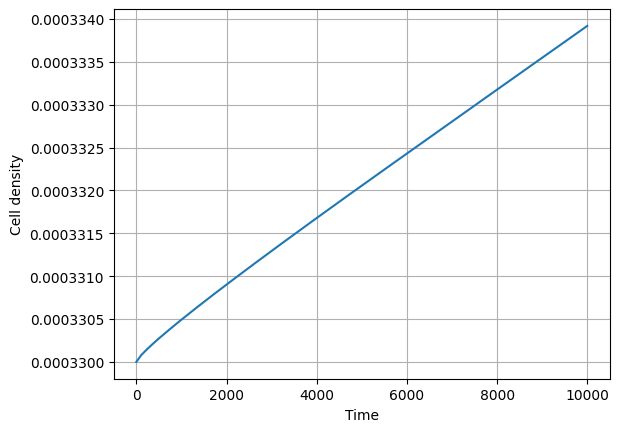

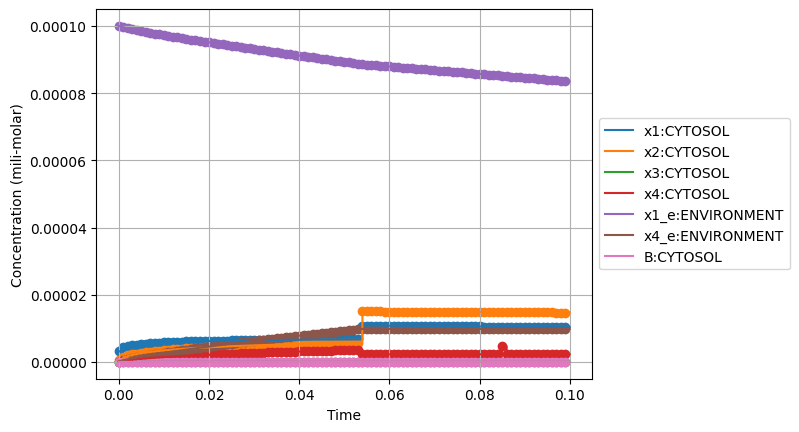

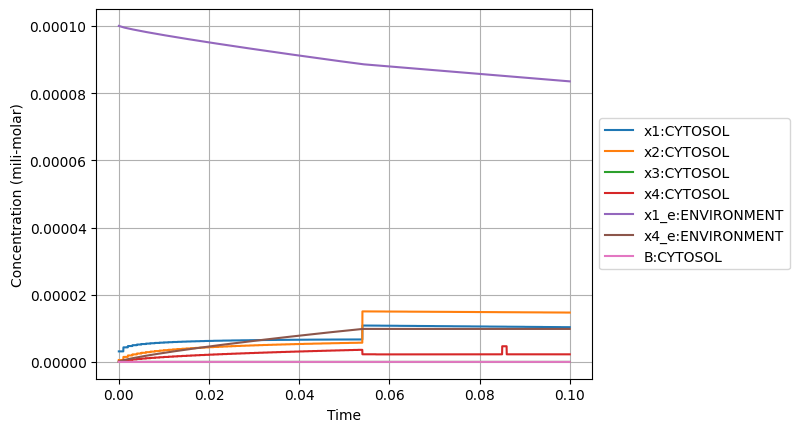

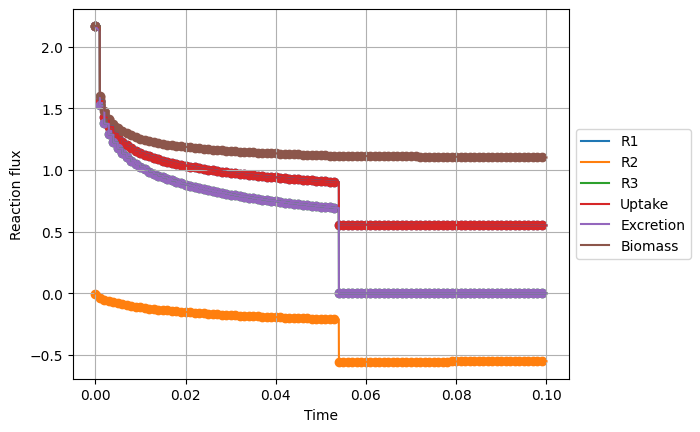

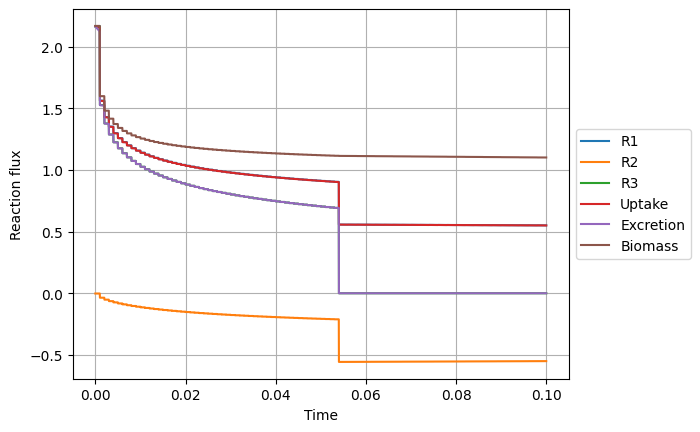

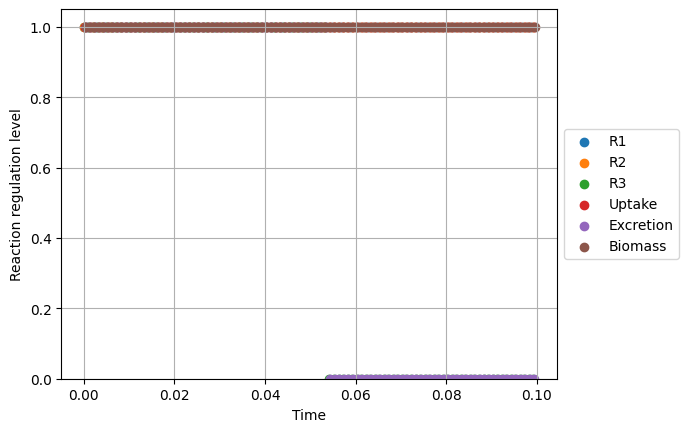

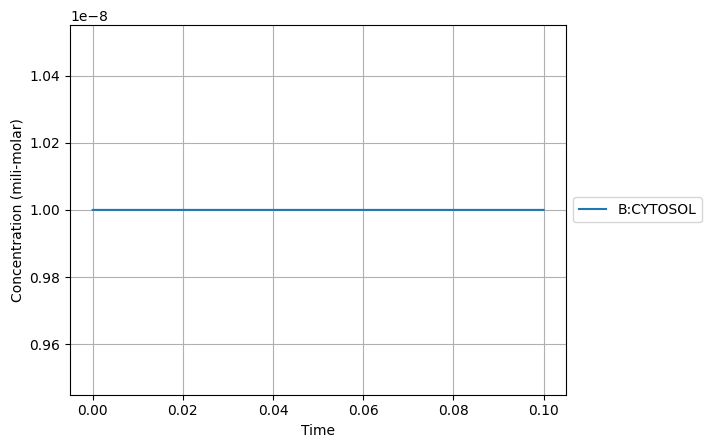

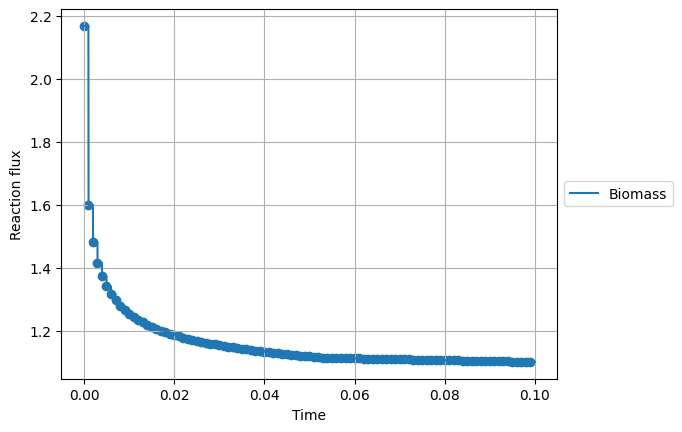

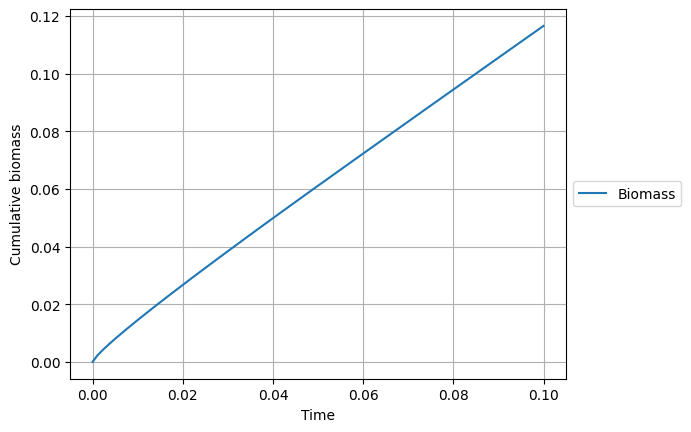

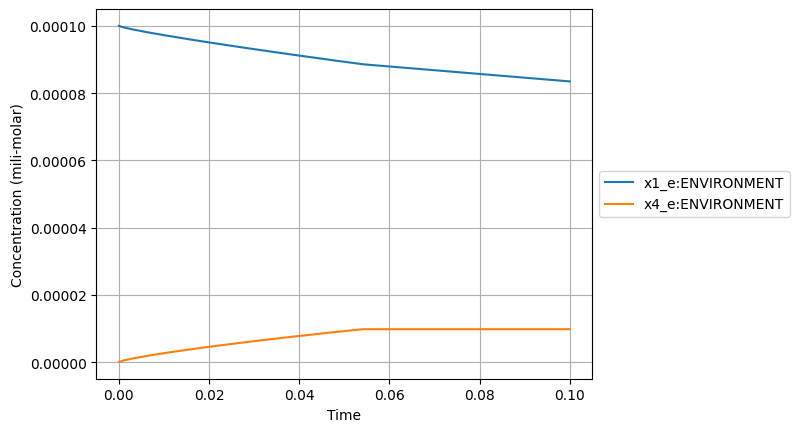

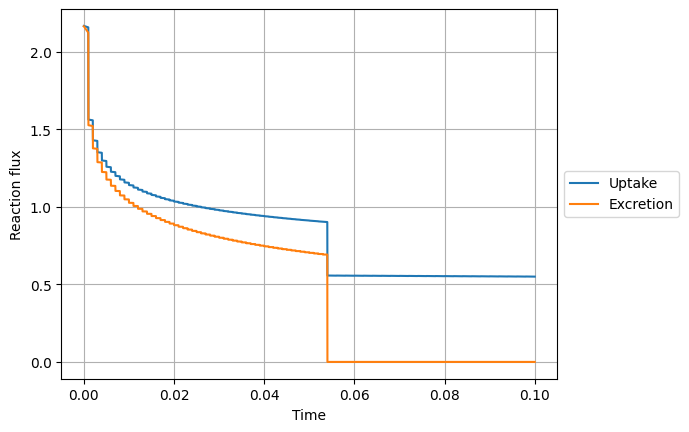

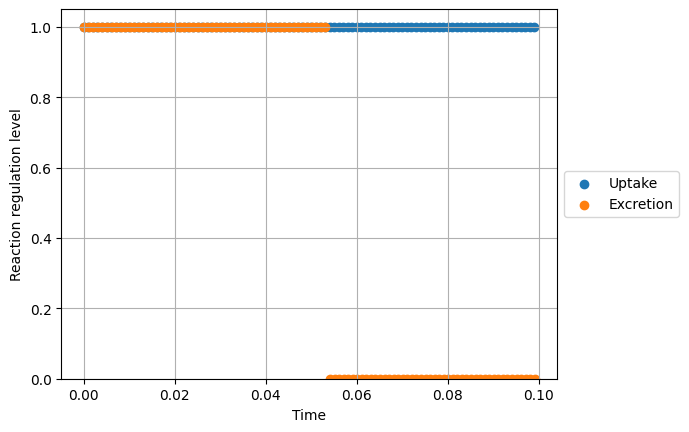

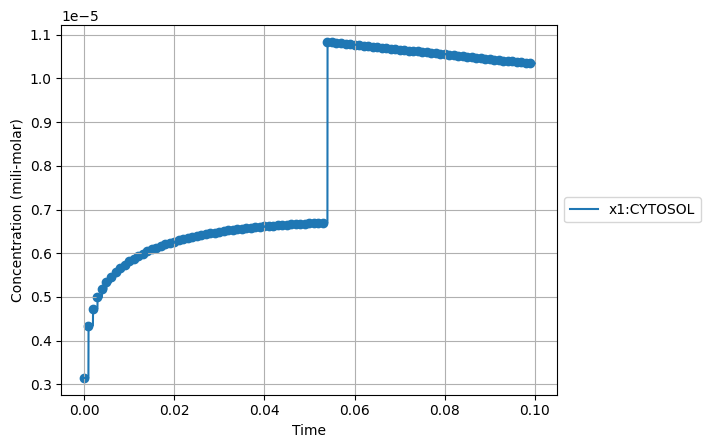

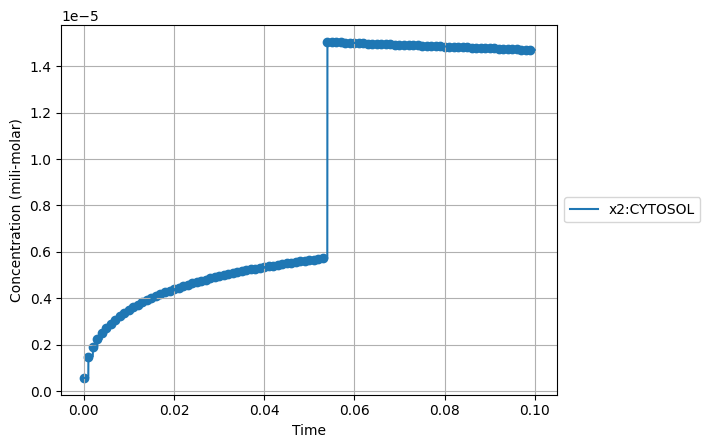

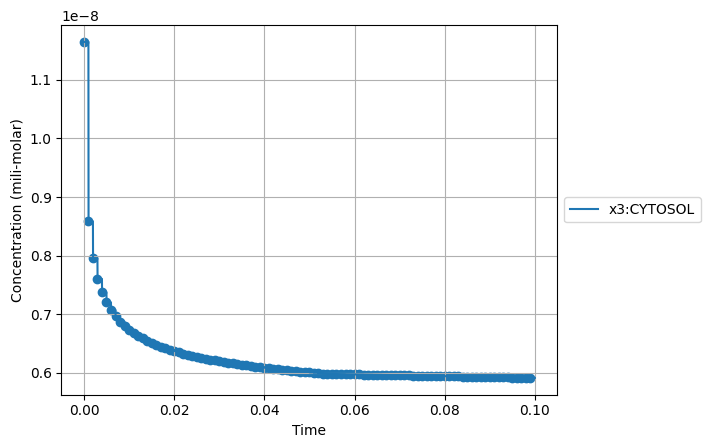

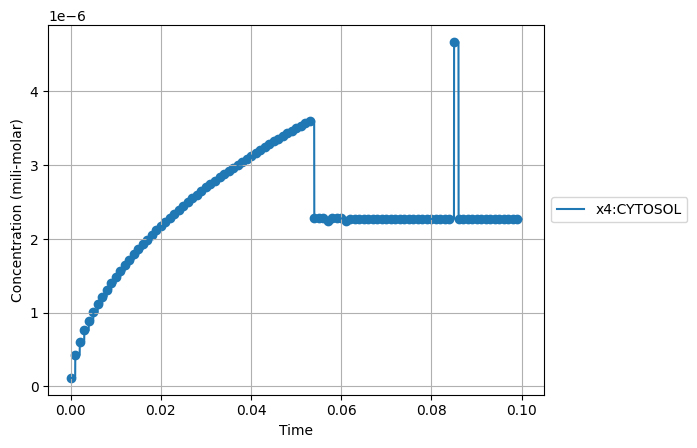

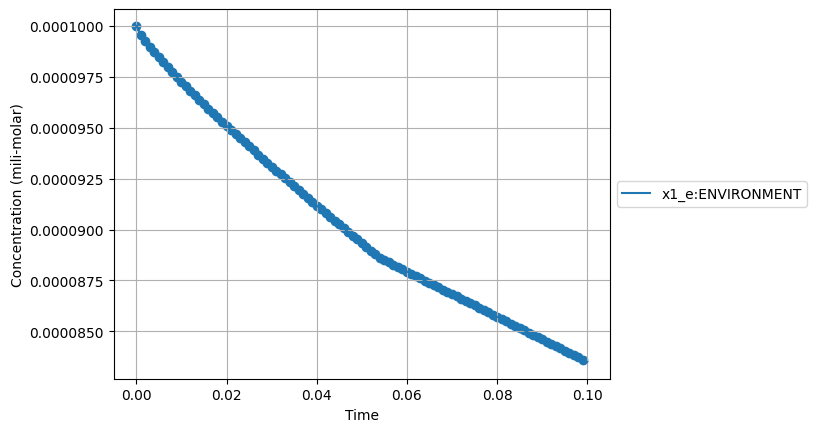

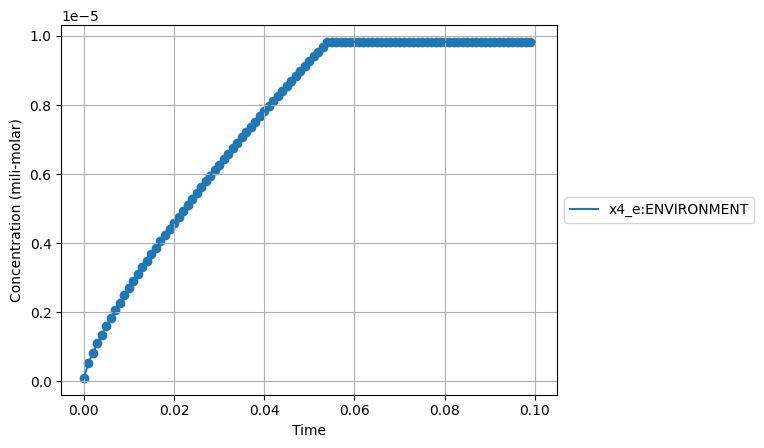

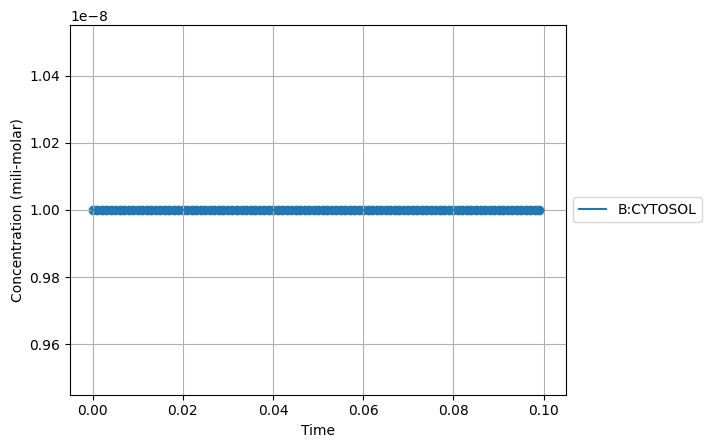

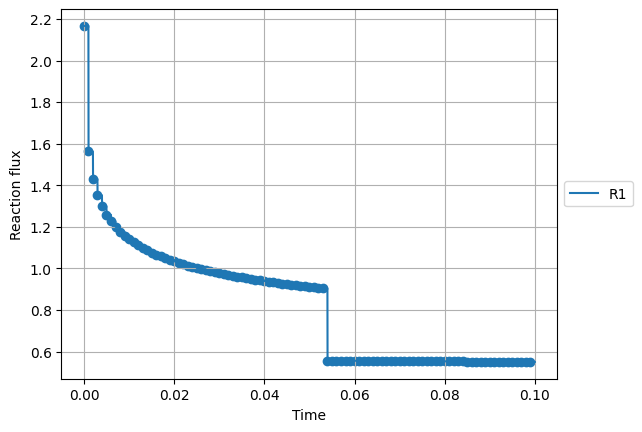

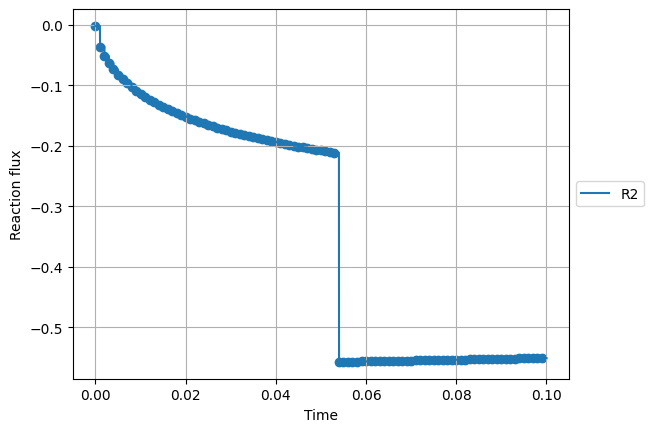

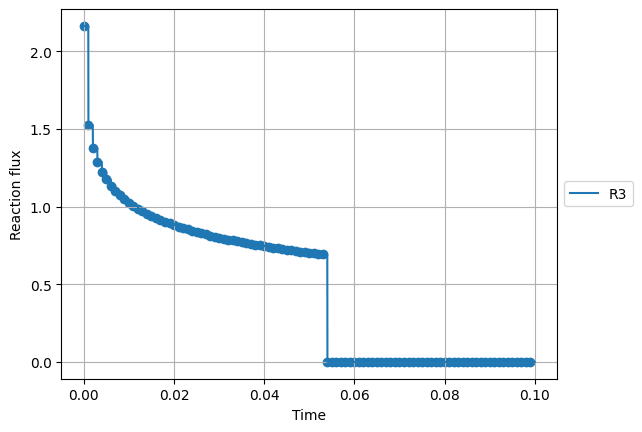

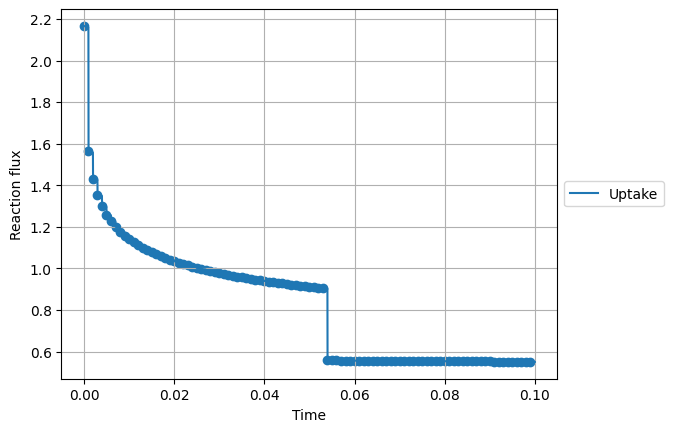

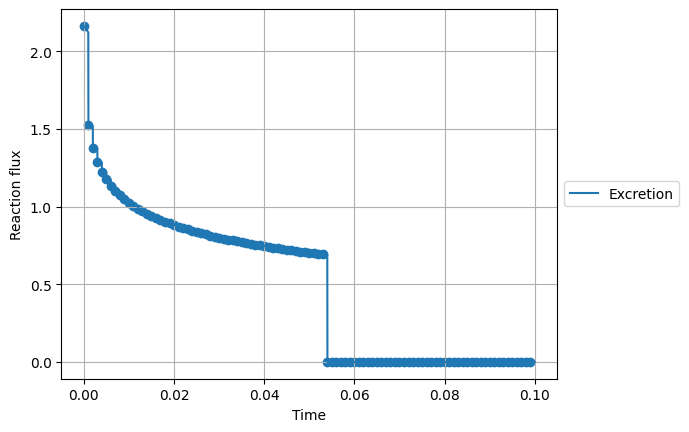

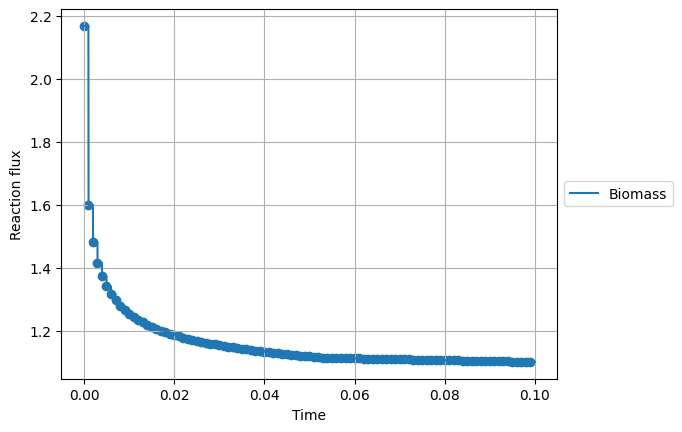

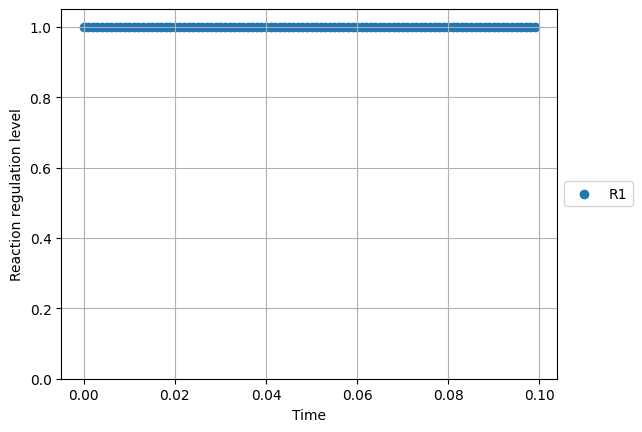

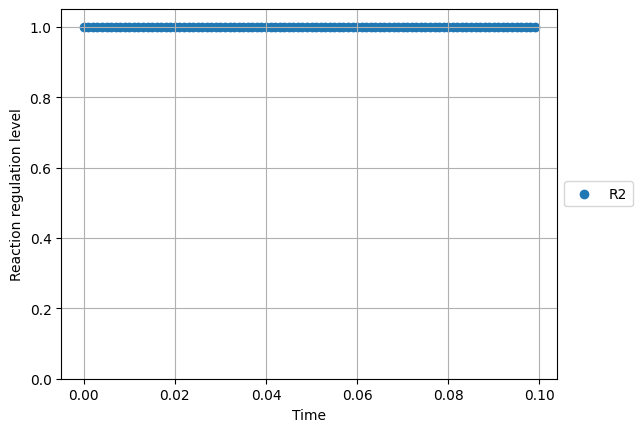

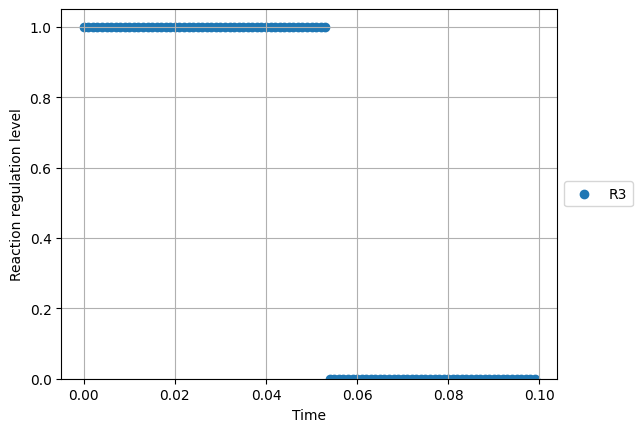

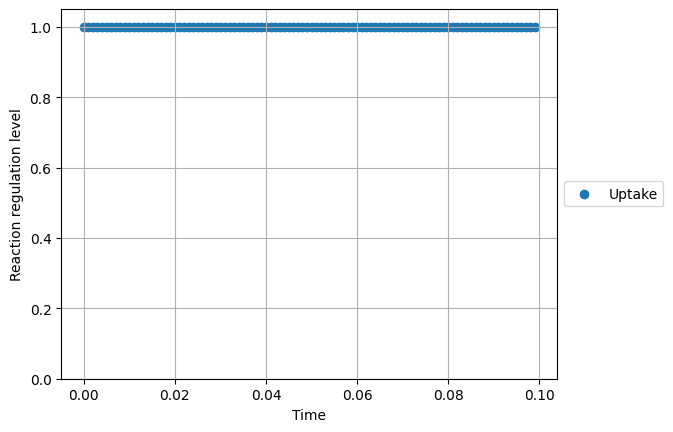

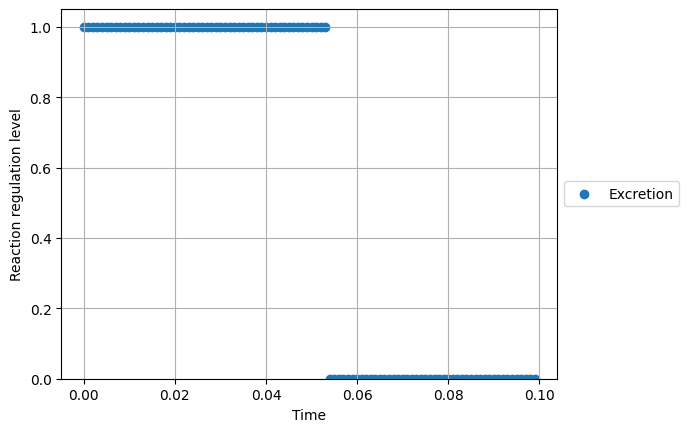

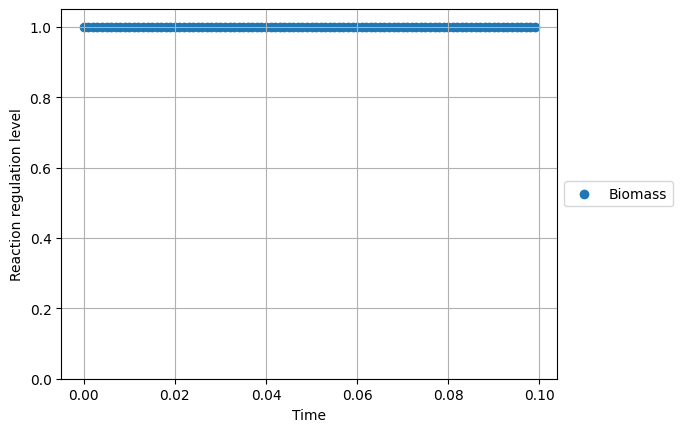

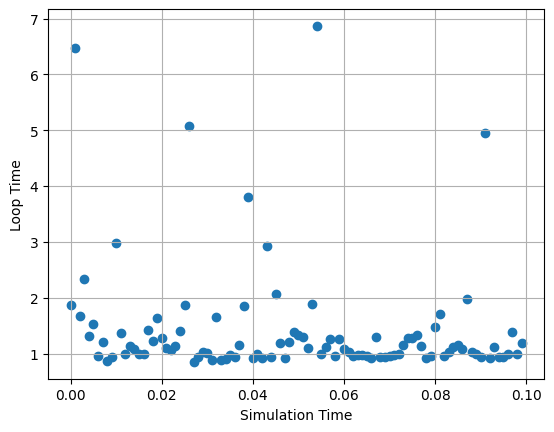

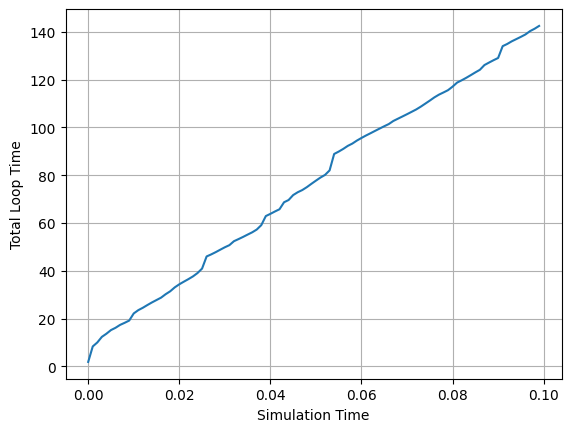

In [3]:
reload(dyn)
plot_dictionary={
    'biomass_metabolite':'B:CYTOSOL',
    'biomass_reaction':'Biomass',
    'time_limit':0,
    'metabolite_subset':[],
    'reaction_subset':[],
    'regulation_subset':[],
    'exchange_metabolite':['x1_e:ENVIRONMENT','x4_e:ENVIRONMENT'],
    'exchange_reaction':['Uptake','Excretion']
}
dyn.PlotFromPickle(control_dictionary,plot_dictionary)

# Small Scale: Internal Regulation Model

In [28]:
# these dictionaries are treated as having global scope
control_dictionary={
    'model_file_dir':'Saved_models', # default 'Saved_models'
    'solution_file_dir':'Saved_solutions', # default 'Saved_solutions'
    'pickle_output':'Internal_dynamics_with_regulation.pkl',
    'parallel_solve':True,# boolean True/False
    'worker_count': 5,  # natural number, 0 or remove for cpu_count
    'delta_concentration':[1e-6], # list positive reals
    'delta_flux':[1], # list positive reals
    'mb':[100], # list positive naturals
    'zeta':[0.005], # list positive reals
    'swarm_size':10, # naturals, default is 2
    'linear_solver': 'ma57',
    'max_cpu_time':800000,
    'max_iter':100000,
    'acceptable_tol':1e-6,
    'solver_tol':1e-7,
    'feasibility_check':False,
    'feasibility_as_input':False,
    'annealing_check':False
#     'hsllib':'/opt/coinhsl/lib/libcoinhsl.dylib'
}

ode_system_dictionary={
    'dt':1e-8,
#     'nmax':4800000,
    'nmax':400,
    'stoichiometry_matrix':[],
    'metabolites_to_fix':['B:CYTOSOL'],
    'jump_tolerance':0.5,
    'stall_on_opt_jump':5,
#     'Opt_frequency':200000
    'Opt_frequency':20
}

environment_dictionary={
    'metabolites':['x1_e:ENVIRONMENT','x4_e:ENVIRONMENT'],
    'transport_reactions':['Uptake','Excretion'],
    'chemostat_type':[['Zero',{'Magnitude':1e-4}],['Zero',{'Magnitude':1e-6}]],
    'initial_environment_concentrations':[1.0e-4,1e-7], # molar
    'bath_volume':1.0,
    'glucose_diffusion_constant':600 # µm^2/sec
}


cell_dictionary={
    'model':'smallModel_lowK.pkl',#'smallModel_highK.pkl',
    'previous_best_model_solution':"",
    'environment_energy_name':'x1_e:ENVIRONMENT',
    'energy_import_reaction_name':'Uptake',
    'environment_compartment_name':'ENVIRONMENT',
#     'adaptation_constant':0.01,
    'initial_cell_density':3.3e-4,
    'birth_rate':1.0,
    'death_rate':0.008,
    'import_energy_metabolites':['x1_e:ENVIRONMENT','x4_e:ENVIRONMENT'],
    'import_energy_reactions':['Uptake','Excretion'],
    'import_energy_michaelis_menten':[0.04*1e-3,0.04*1e-3], # m moles
    
    'vmax':3.033e-12, # mM glucose consumed per hour per 1 micron^3 cell 
    'cell_volume':1e-15, 
    'hyphae_volume':4e3, # microns^3
    'N_avogadro':6.022140857e+23
    
}
  
# run the ThermoOpt method
metaboliteTraceDf,metabolitesOPT,fluxTraceDf,fluxOPT,regulationOPT,timesOPT,cell_density_vec,loopTimes = dyn.RunThermoOpt(control_dictionary,ode_system_dictionary,environment_dictionary,cell_dictionary)

# run the simulation output into a pickle file 'pickle_output'
dyn.SaveSimulationOutput(control_dictionary,metaboliteTraceDf,metabolitesOPT,fluxTraceDf,fluxOPT,regulationOPT,timesOPT,cell_density_vec,loopTimes)

# delete the files created during the simulation 
dyn.CleanThermoOpt(control_dictionary)



Volume of cell: 1e-15
Surface area of cell: 4.835975862049414e-10
Volume of near field element: 9.047786842338608e-07
Volume ratio of Chemostat To Cell: 904778684.2338607
Sim Name: ChemostatModel_t_0.0_swarm_0_100_0.005_1e-06_1 objective: 116.12905305083947 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_1_100_0.005_1e-06_1 objective: 116.12905302268274 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_2_100_0.005_1e-06_1 objective: 220.62495133198448 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_3_100_0.005_1e-06_1 objective: 220.6249513587134 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_4_100_0.005_1e-06_1 objective: 116.12905312522834 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_5_100_0.005_1e-06_1 objective: 220.62495153237833 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_6_100_0.005_1e-06_1 objective: 116.12905306854142 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_7_100_0.005_1e-06_1 objective: 220.6249513239084 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_8_100_0.00

Sim Name: ChemostatModel_t_1.4e-06_swarm_5_100_0.005_1e-06_1 objective: 220.27172467763333 status: ok
Sim Name: ChemostatModel_t_1.4e-06_swarm_6_100_0.005_1e-06_1 objective: 220.27172468556037 status: ok
Sim Name: ChemostatModel_t_1.4e-06_swarm_7_100_0.005_1e-06_1 objective: 116.12891402155593 status: ok
Sim Name: ChemostatModel_t_1.4e-06_swarm_8_100_0.005_1e-06_1 objective: 220.27172469364274 status: ok
Sim Name: ChemostatModel_t_1.4e-06_swarm_9_100_0.005_1e-06_1 objective: 220.27172472243615 status: ok
Loop Time in seconds:  0.8898088932037354
ETA in minutes:  0.19279192686080932
Sim Name: ChemostatModel_t_1.6e-06_swarm_0_100_0.005_1e-06_1 objective: 116.12889408721337 status: ok
Sim Name: ChemostatModel_t_1.6e-06_swarm_1_100_0.005_1e-06_1 objective: 116.12889404727535 status: ok
Sim Name: ChemostatModel_t_1.6e-06_swarm_2_100_0.005_1e-06_1 objective: 116.12889409872517 status: ok
Sim Name: ChemostatModel_t_1.6e-06_swarm_3_100_0.005_1e-06_1 objective: 220.2063728534508 status: ok
Sim 

Sim Name: ChemostatModel_t_3e-06_swarm_0_100_0.005_1e-06_1 objective: 219.72496616702543 status: ok
Sim Name: ChemostatModel_t_3e-06_swarm_1_100_0.005_1e-06_1 objective: 219.72496607210044 status: ok
Sim Name: ChemostatModel_t_3e-06_swarm_2_100_0.005_1e-06_1 objective: 219.72496606417192 status: ok
Sim Name: ChemostatModel_t_3e-06_swarm_3_100_0.005_1e-06_1 objective: 116.1287544011661 status: ok
Sim Name: ChemostatModel_t_3e-06_swarm_4_100_0.005_1e-06_1 objective: 219.7249660641719 status: ok
Sim Name: ChemostatModel_t_3e-06_swarm_5_100_0.005_1e-06_1 objective: 219.72496606417258 status: ok
Sim Name: ChemostatModel_t_3e-06_swarm_6_100_0.005_1e-06_1 objective: 219.72496607239682 status: ok
Sim Name: ChemostatModel_t_3e-06_swarm_7_100_0.005_1e-06_1 objective: 116.12875439709931 status: ok
Sim Name: ChemostatModel_t_3e-06_swarm_8_100_0.005_1e-06_1 objective: 116.12875439709931 status: ok
Sim Name: ChemostatModel_t_3e-06_swarm_9_100_0.005_1e-06_1 objective: 116.1287544011653 status: ok
Loo

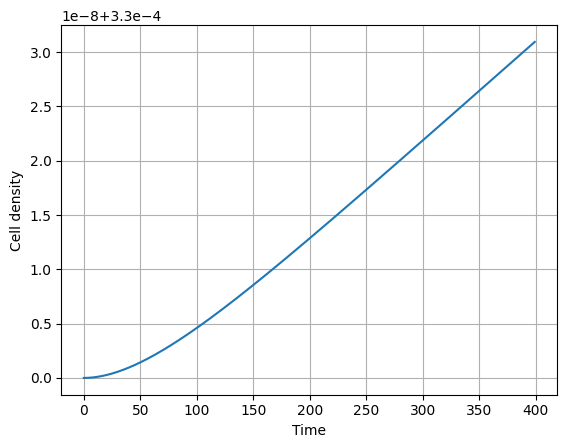

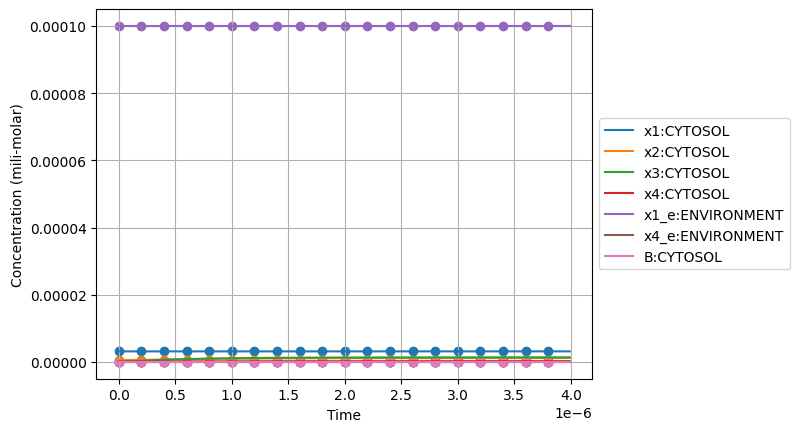

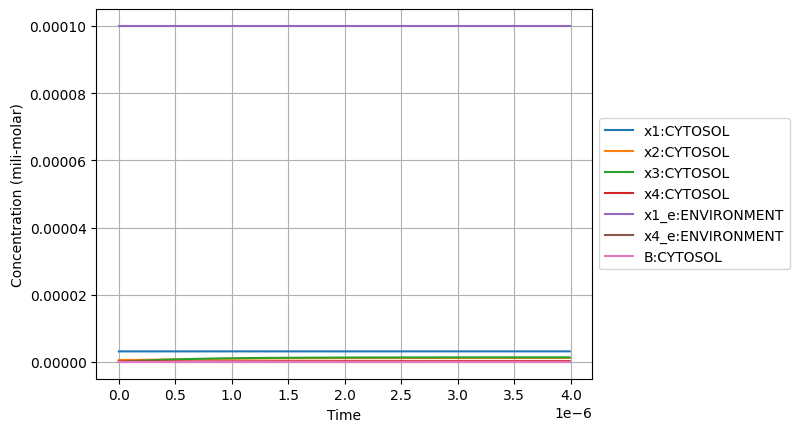

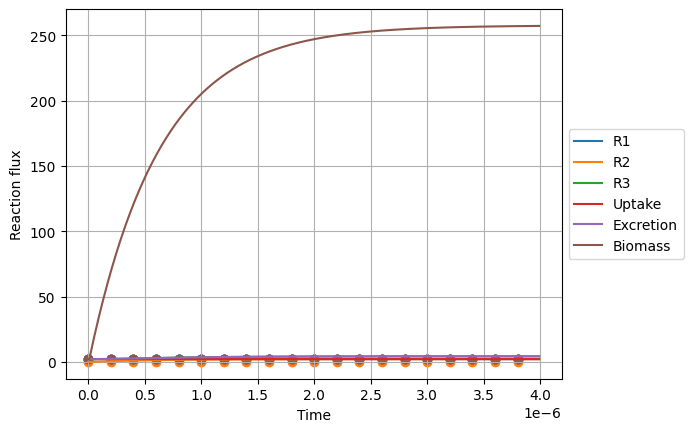

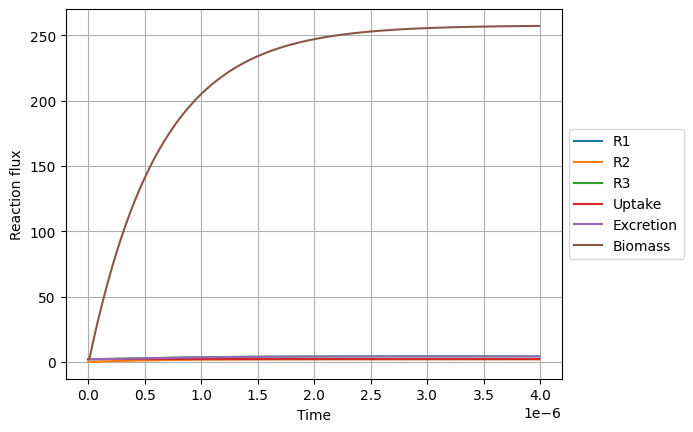

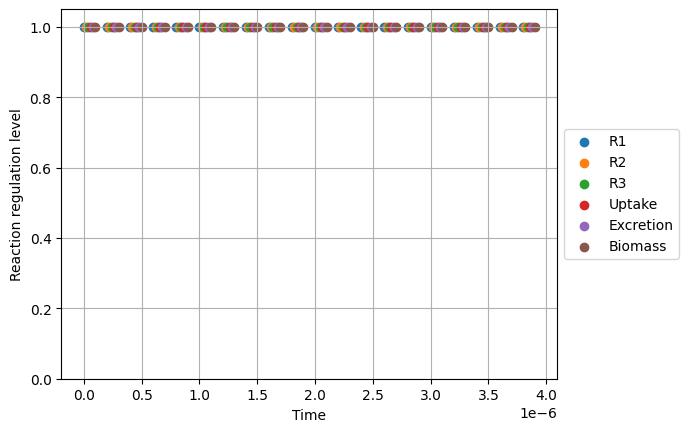

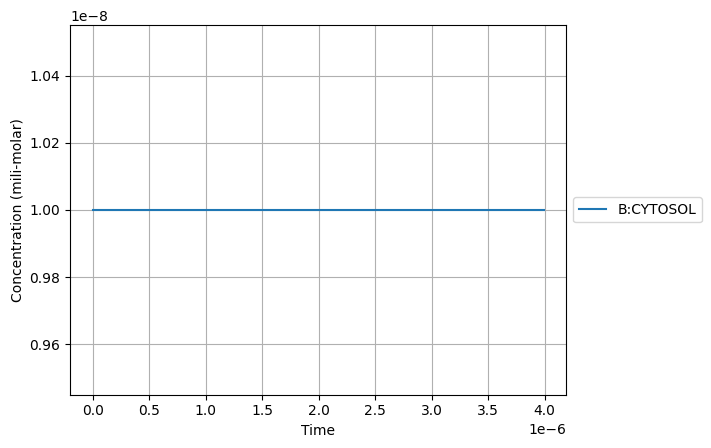

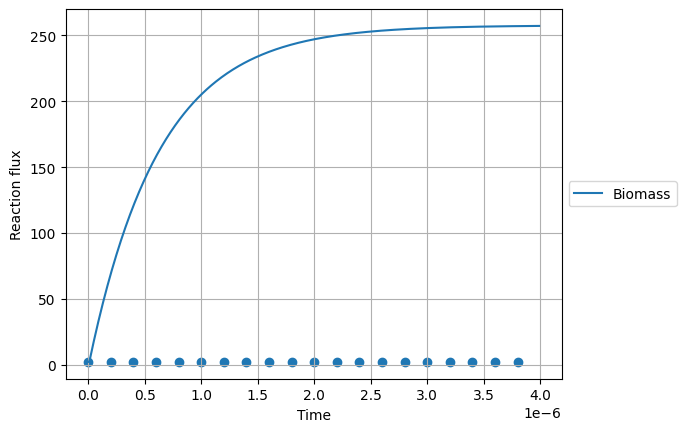

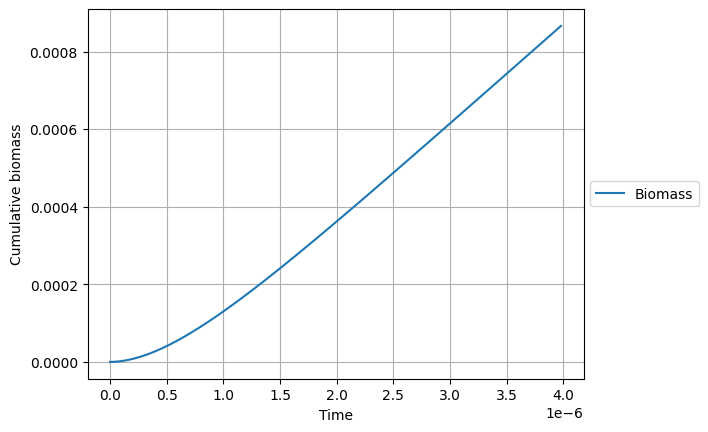

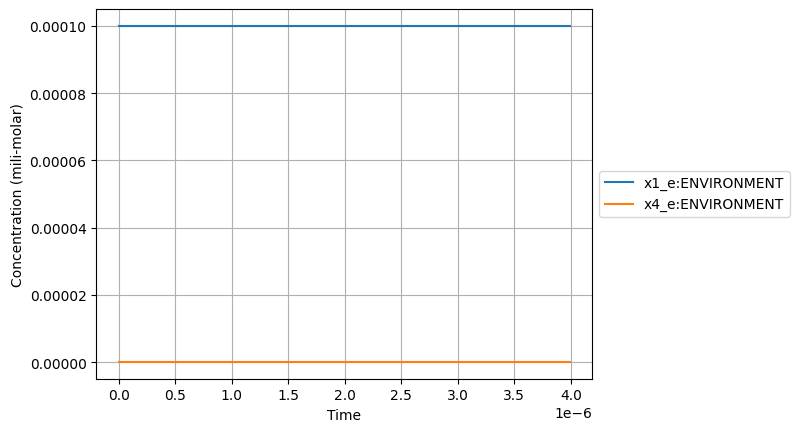

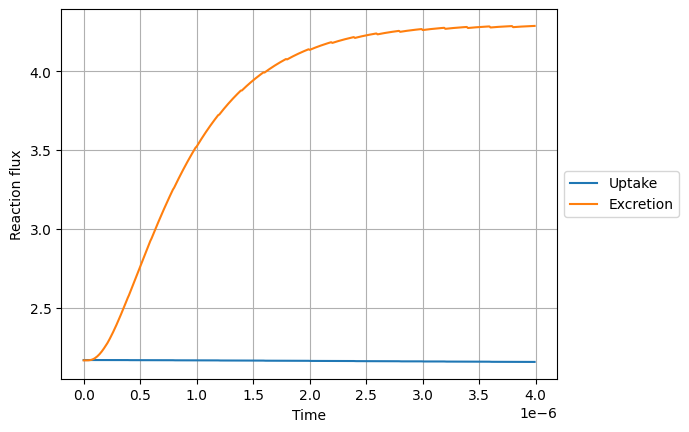

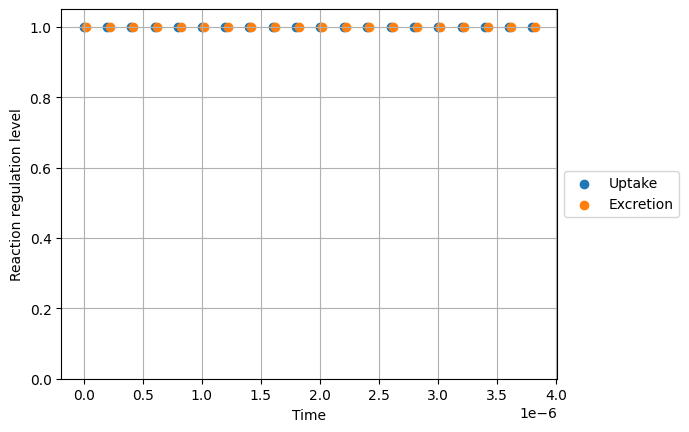

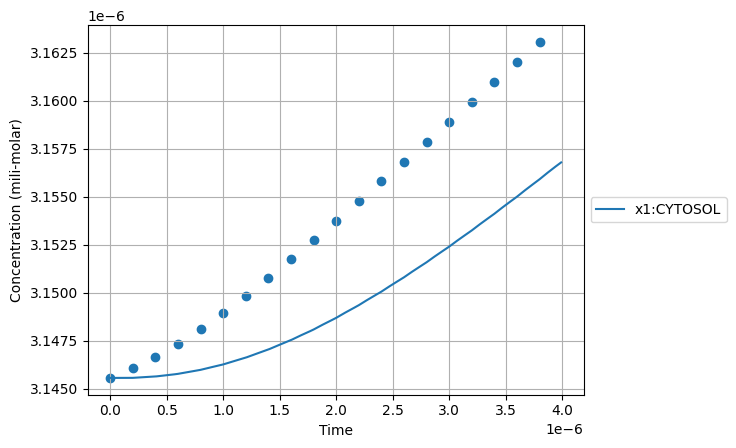

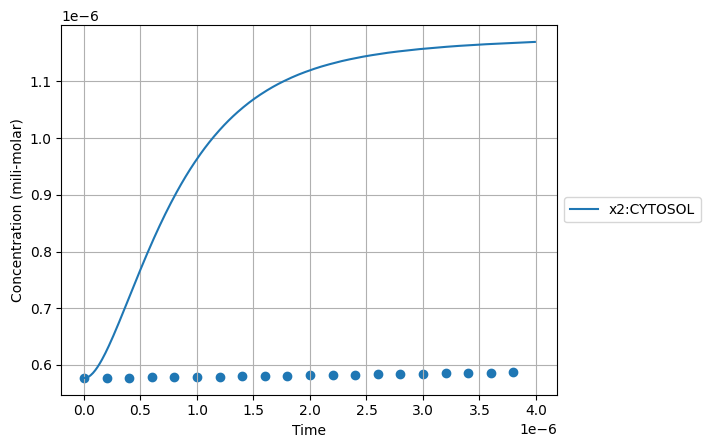

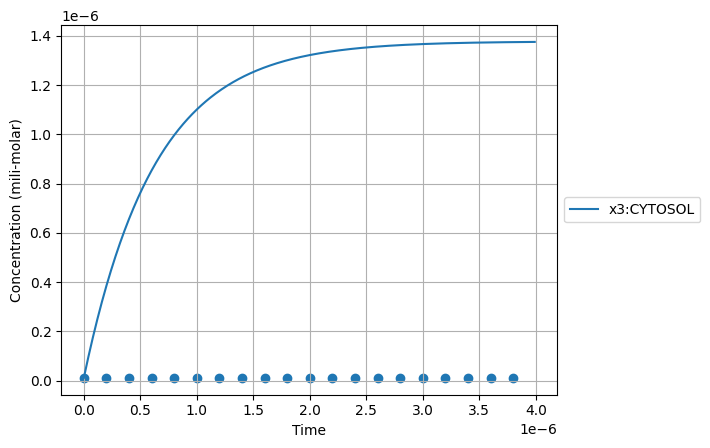

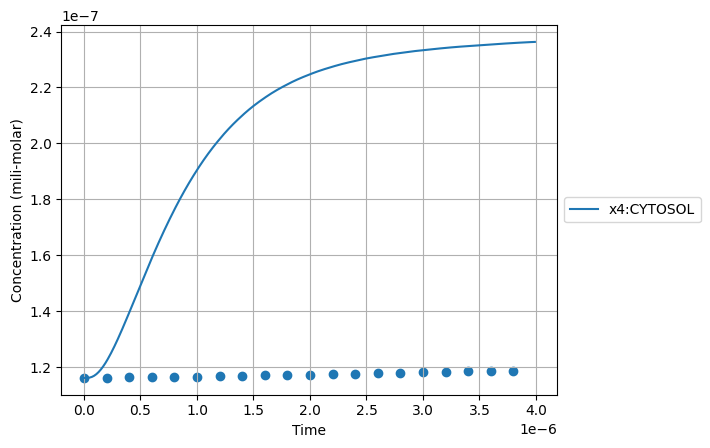

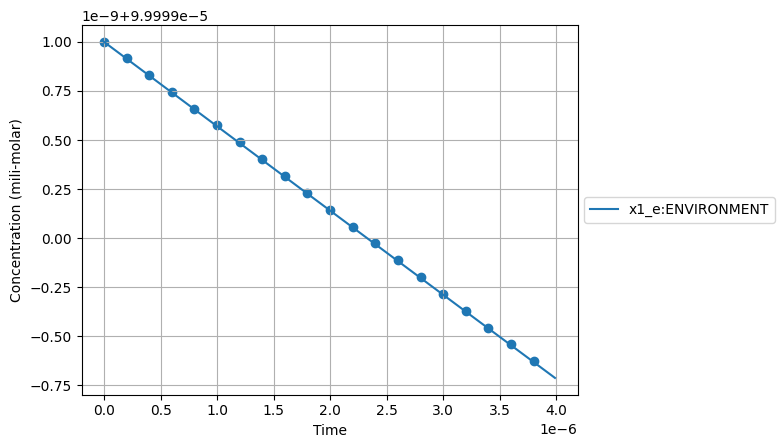

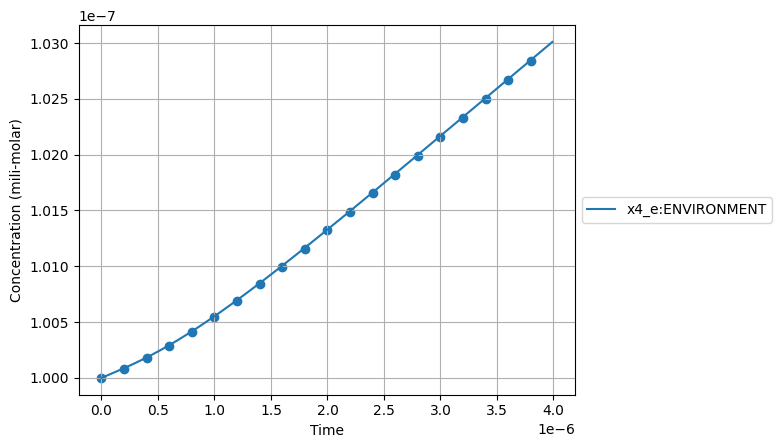

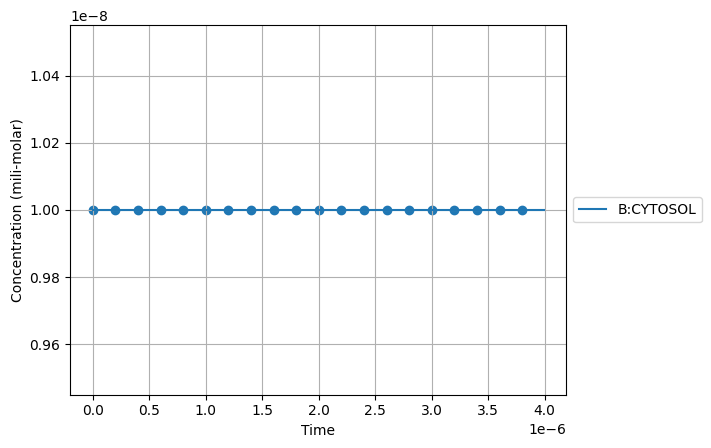

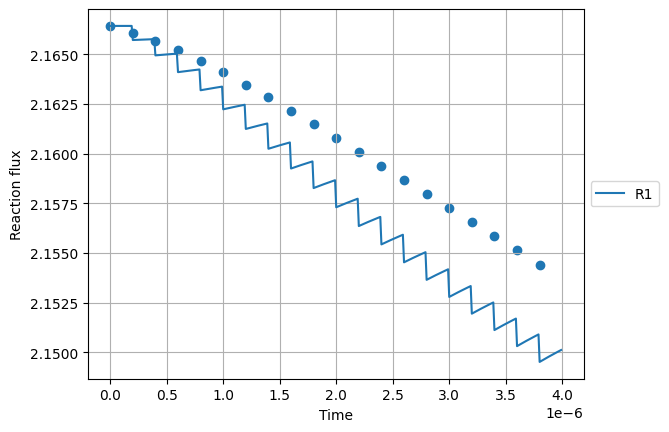

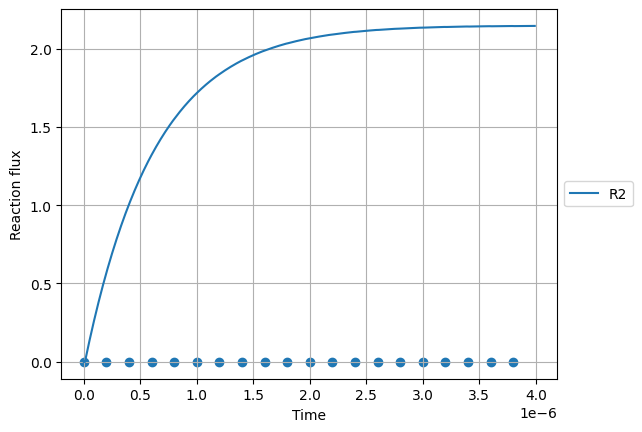

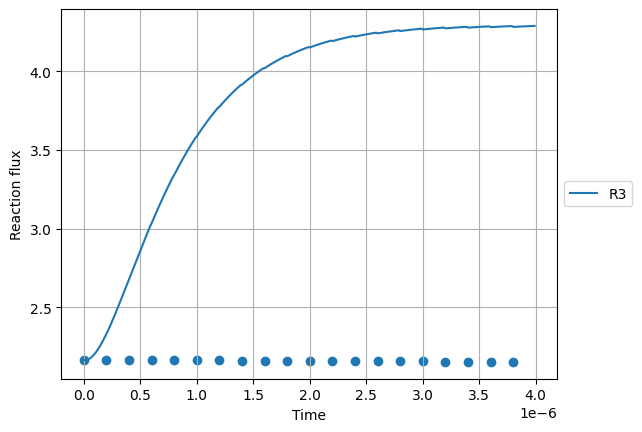

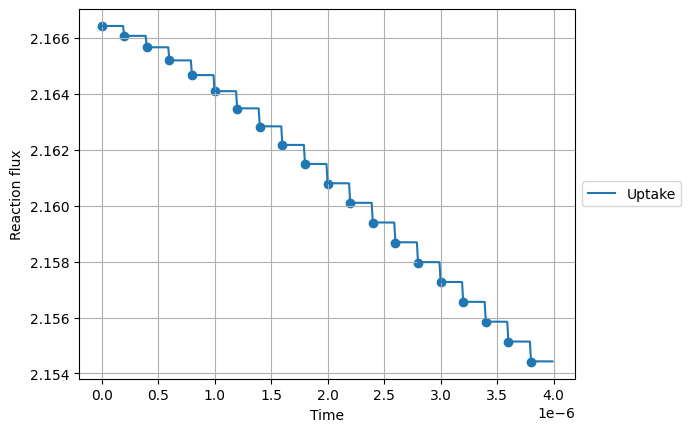

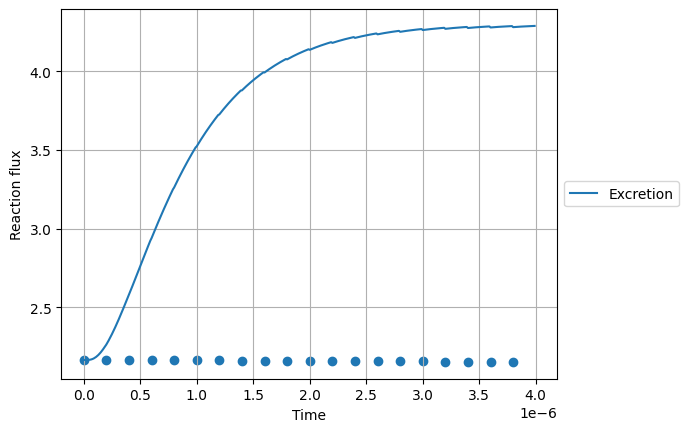

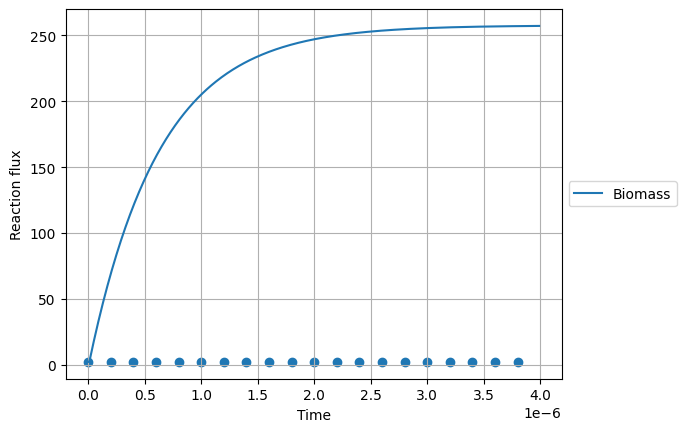

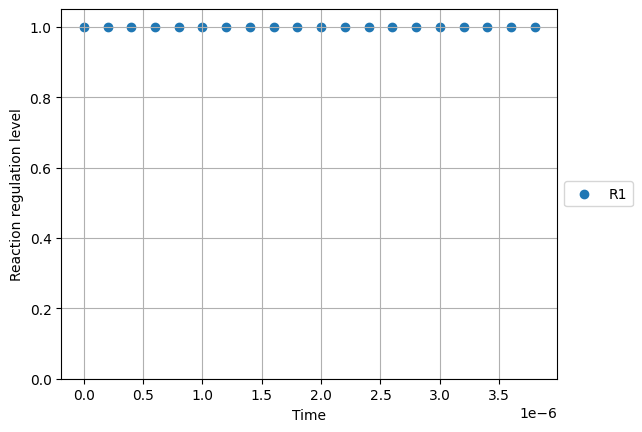

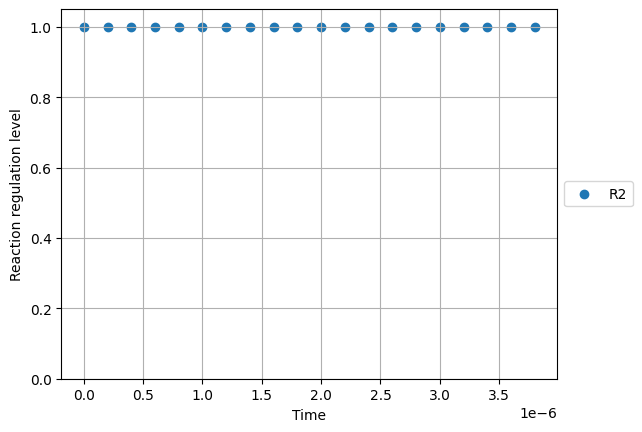

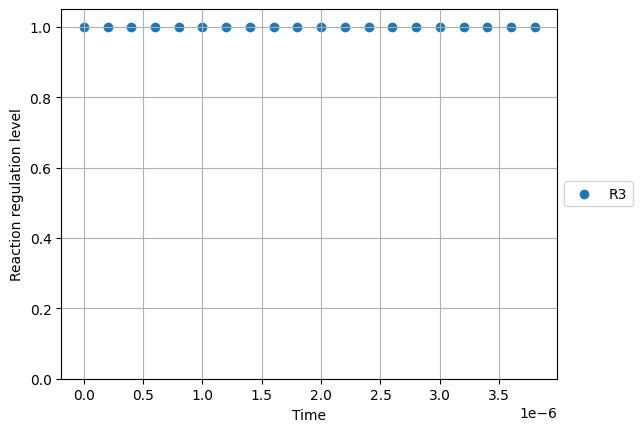

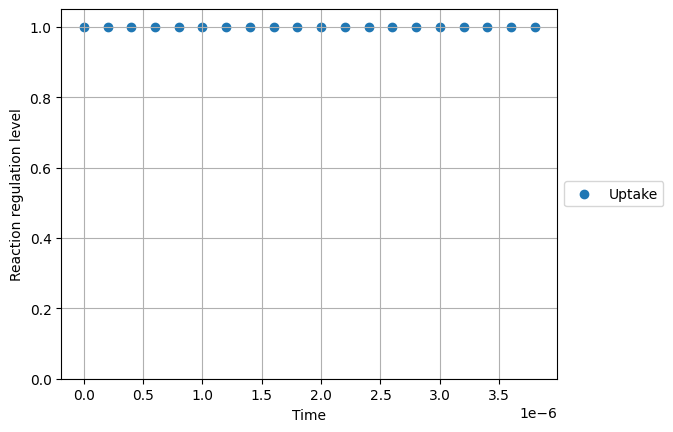

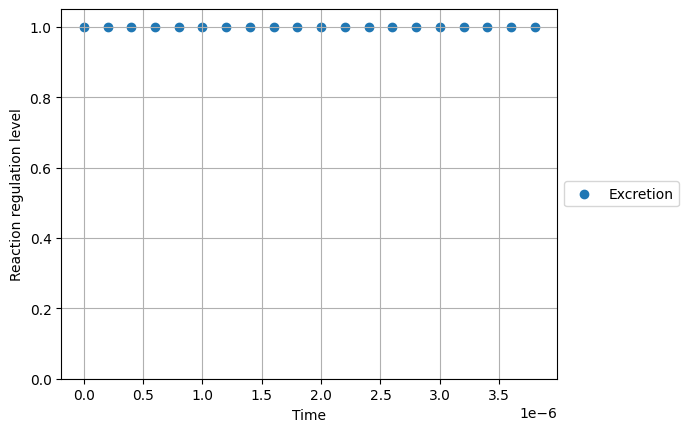

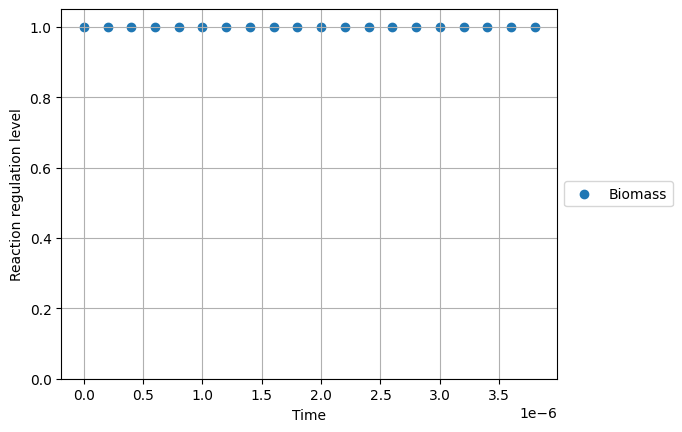

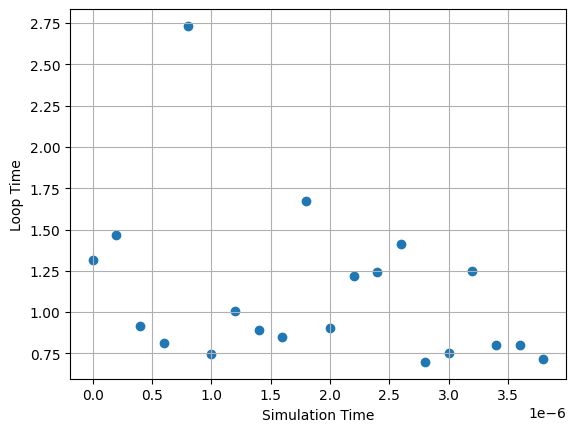

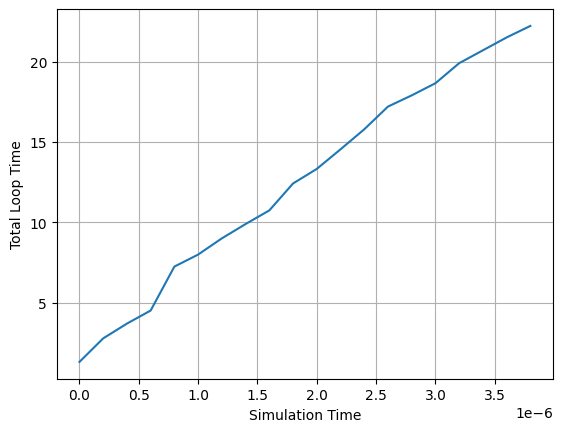

In [29]:
plot_dictionary={
    'biomass_metabolite':'B:CYTOSOL',
    'biomass_reaction':'Biomass',
    'time_limit':0,
    'metabolite_subset':[],
    'reaction_subset':[],
    'regulation_subset':[],
    'exchange_metabolite':['x1_e:ENVIRONMENT','x4_e:ENVIRONMENT'],
    'exchange_reaction':['Uptake','Excretion']
}
dyn.PlotFromPickle(control_dictionary,plot_dictionary)

In [18]:
# these dictionaries are treated as having global scope
control_dictionary={
    'model_file_dir':'Saved_models', # default 'Saved_models'
    'solution_file_dir':'Saved_solutions', # default 'Saved_solutions'
    'pickle_output':'Internal_dynamics_without_regulation.pkl',
    'parallel_solve':True,# boolean True/False
    'worker_count': 5,  # natural number, 0 or remove for cpu_count
    'delta_concentration':[1e-6], # list positive reals
    'delta_flux':[1], # list positive reals
    'mb':[100], # list positive naturals
    'zeta':[0.005], # list positive reals
    'swarm_size':10, # naturals, default is 2
    'linear_solver': 'ma57',
    'max_cpu_time':800000,
    'max_iter':100000,
    'acceptable_tol':1e-6,
    'solver_tol':1e-7,
    'feasibility_check':False,
    'feasibility_as_input':False,
    'annealing_check':False
#     'hsllib':'/opt/coinhsl/lib/libcoinhsl.dylib'
}

ode_system_dictionary={
    'dt':1e-10,
#     'nmax':4800000,
    'nmax':400,
    'stoichiometry_matrix':[],
    'metabolites_to_fix':['B:CYTOSOL'],
    'jump_tolerance':0.5,
    'stall_on_opt_jump':5,
#     'Opt_frequency':200000
    'Opt_frequency':20
}

environment_dictionary={
    'metabolites':['x1_e:ENVIRONMENT','x4_e:ENVIRONMENT'],
    'transport_reactions':['Uptake','Excretion'],
    'chemostat_type':[['Zero',{'Magnitude':1e-4}],['Zero',{'Magnitude':1e-6}]],
    'initial_environment_concentrations':[1.0e-4,1e-7], # molar
    'bath_volume':1.0,
    'glucose_diffusion_constant':600 # µm^2/sec
}


cell_dictionary={
    'model':'smallModel_lowK.pkl',#'smallModel_highK.pkl',
    'previous_best_model_solution':"",
    'environment_energy_name':'x1_e:ENVIRONMENT',
    'energy_import_reaction_name':'Uptake',
    'environment_compartment_name':'ENVIRONMENT',
#     'adaptation_constant':0.01,
    'initial_cell_density':3.3e-4,
    'birth_rate':1.0,
    'death_rate':0.008,
    'import_energy_metabolites':['x1_e:ENVIRONMENT','x4_e:ENVIRONMENT'],
    'import_energy_reactions':['Uptake','Excretion'],
    'import_energy_michaelis_menten':[0.04*1e-3,0.04*1e-3], # m moles
    
    'vmax':3.033e-12, # mM glucose consumed per hour per 1 micron^3 cell 
    'cell_volume':1e-15, 
    'hyphae_volume':4e3, # microns^3
    'N_avogadro':6.022140857e+23
    
}
  
# run the ThermoOpt method
metaboliteTraceDf,metabolitesOPT,fluxTraceDf,fluxOPT,regulationOPT,timesOPT,cell_density_vec,loopTimes = dyn.RunThermoOptNoRegulation(control_dictionary,ode_system_dictionary,environment_dictionary,cell_dictionary)

# run the simulation output into a pickle file 'pickle_output'
dyn.SaveSimulationOutput(control_dictionary,metaboliteTraceDf,metabolitesOPT,fluxTraceDf,fluxOPT,regulationOPT,timesOPT,cell_density_vec,loopTimes)

# delete the files created during the simulation 
dyn.CleanThermoOpt(control_dictionary)



Volume of cell: 1e-15
Surface area of cell: 4.835975862049414e-10
Volume of near field element: 9.047786842338601e-10
Volume ratio of Chemostat To Cell: 904778.6842338601
Sim Name: ChemostatModel_t_0.0_swarm_0_100_0.005_1e-06_1 objective: 220.6249513239171 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_1_100_0.005_1e-06_1 objective: 220.624951323908 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_2_100_0.005_1e-06_1 objective: 116.12905300397432 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_3_100_0.005_1e-06_1 objective: 116.12905303140502 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_4_100_0.005_1e-06_1 objective: 220.62495142860774 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_5_100_0.005_1e-06_1 objective: 220.62495132390836 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_6_100_0.005_1e-06_1 objective: 116.12905301801051 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_7_100_0.005_1e-06_1 objective: 220.6249513587605 status: ok
Sim Name: ChemostatModel_t_0.0_swarm_8_100_0.005_

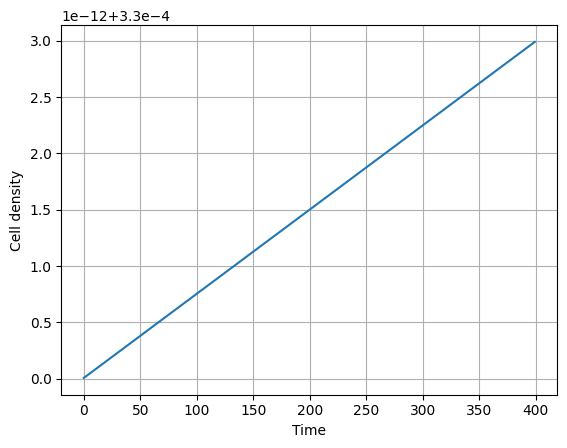

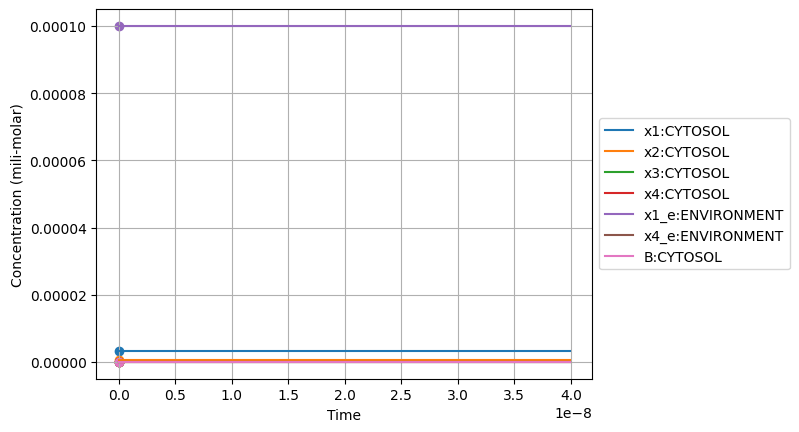

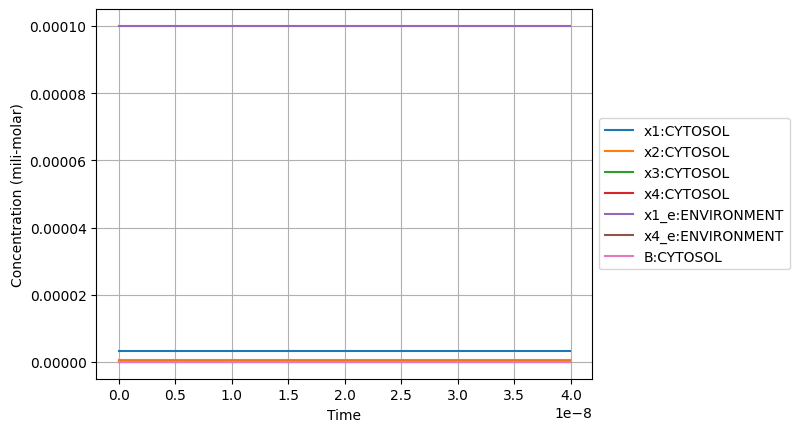

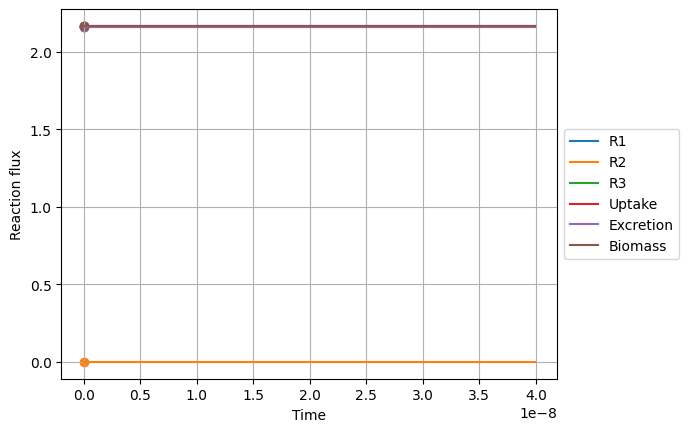

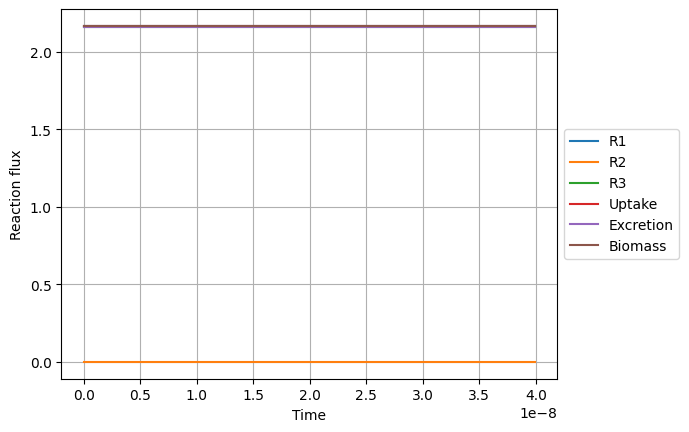

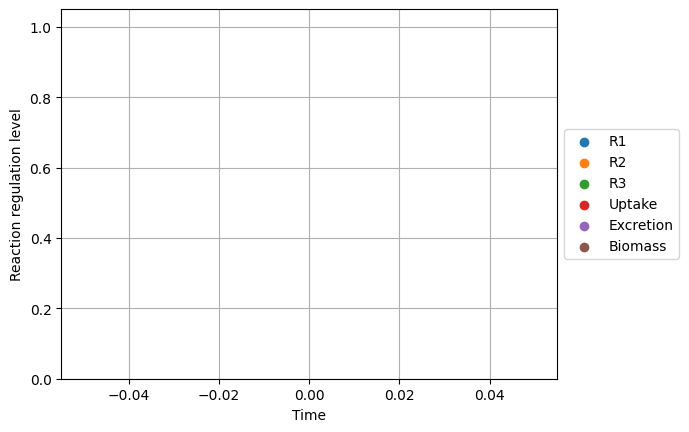

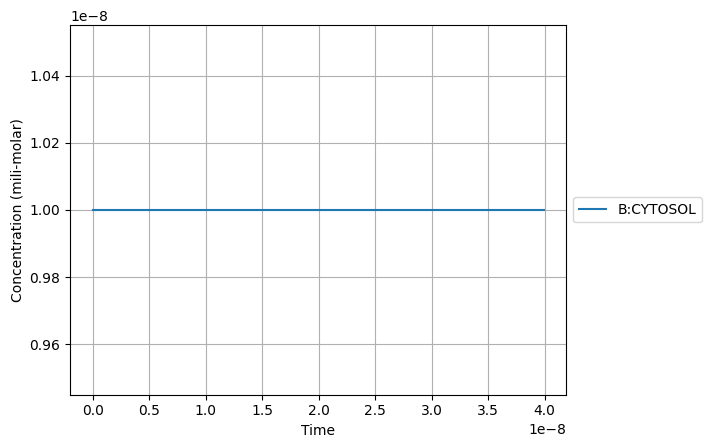

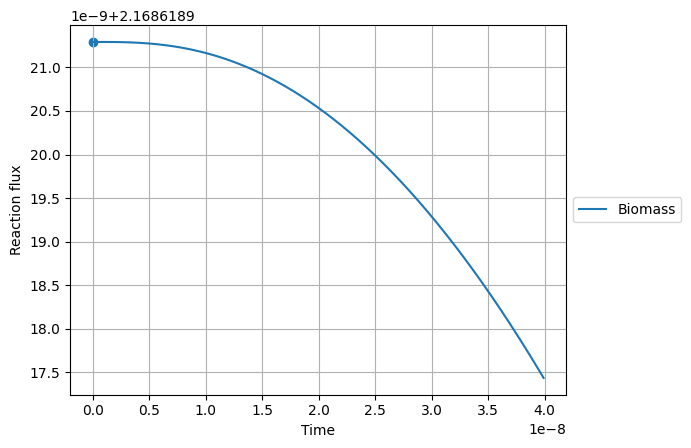

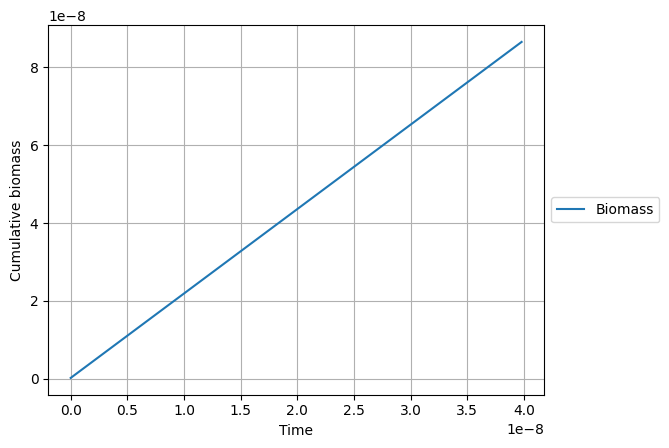

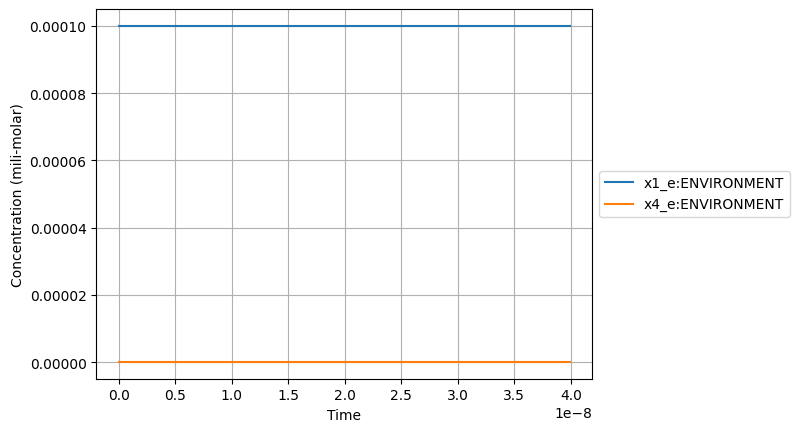

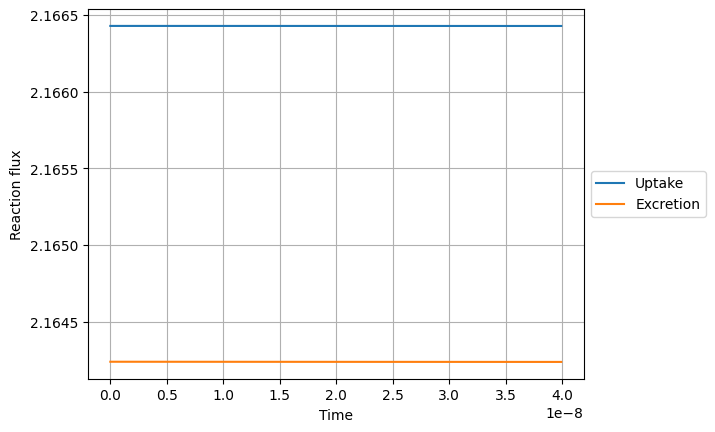

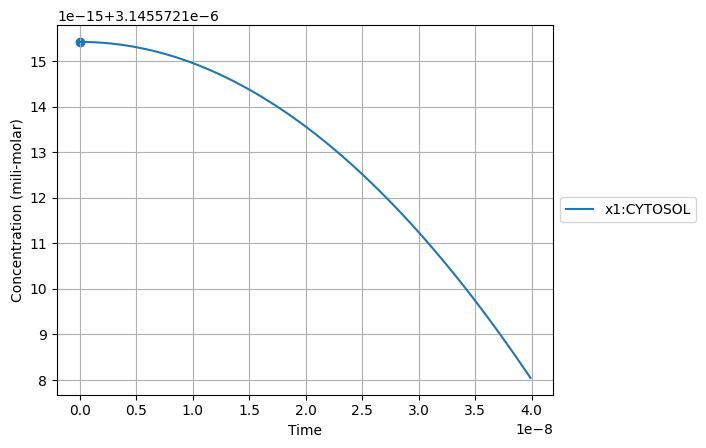

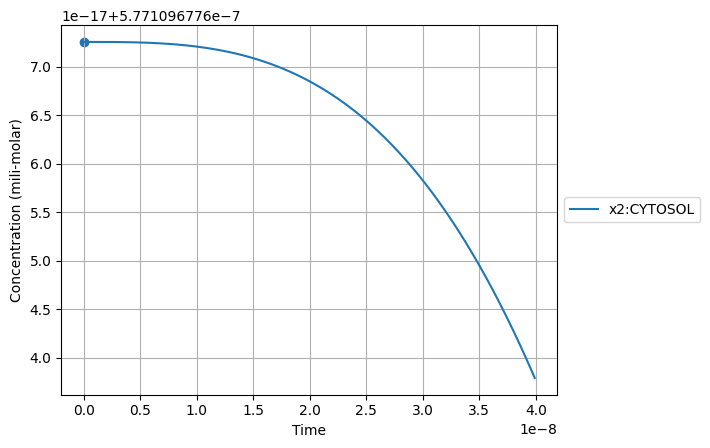

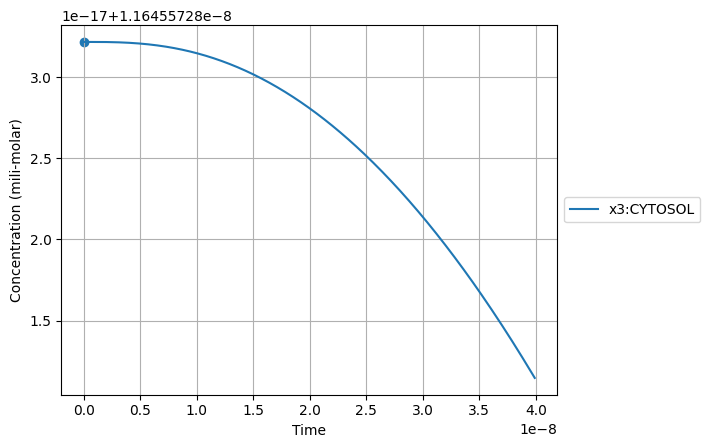

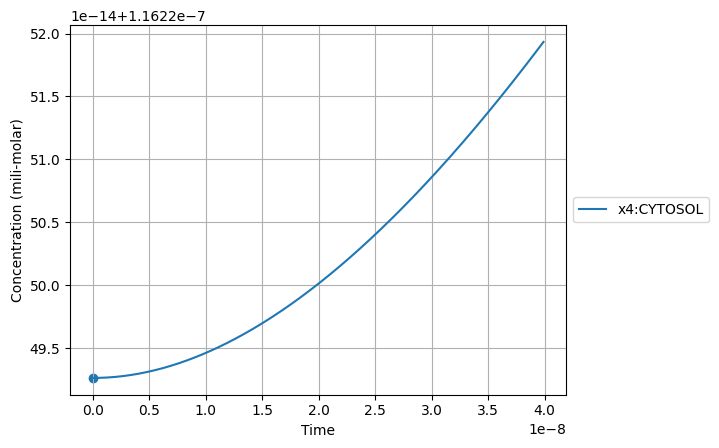

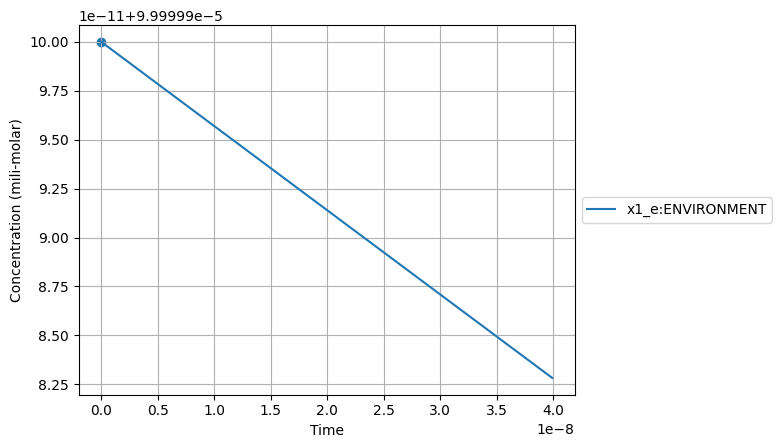

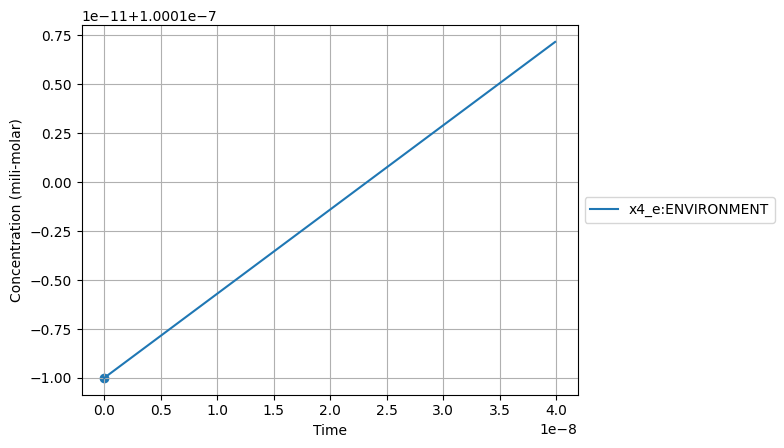

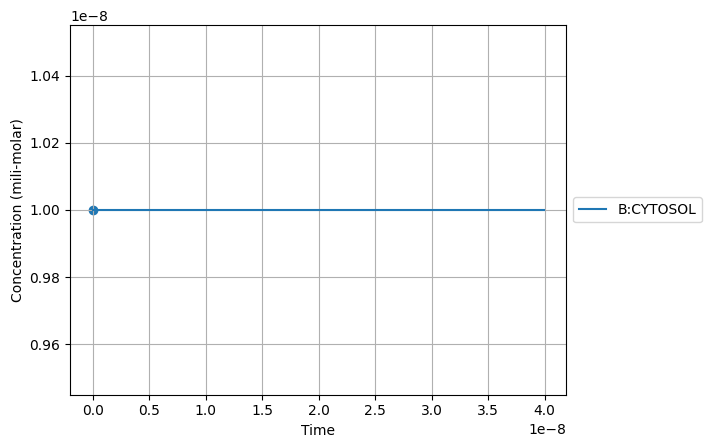

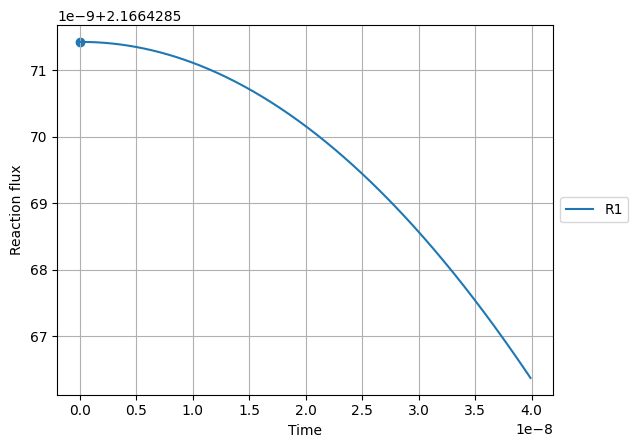

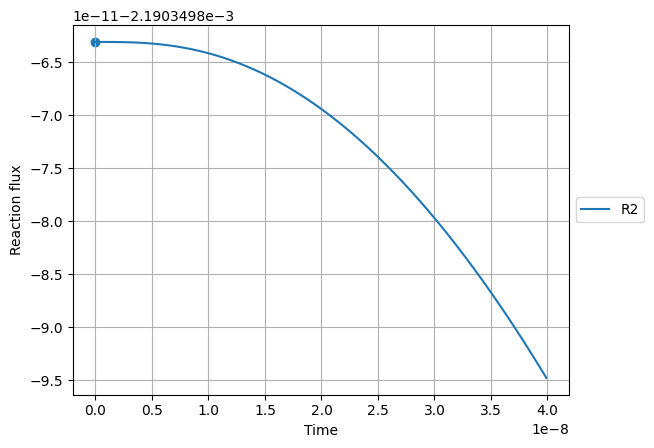

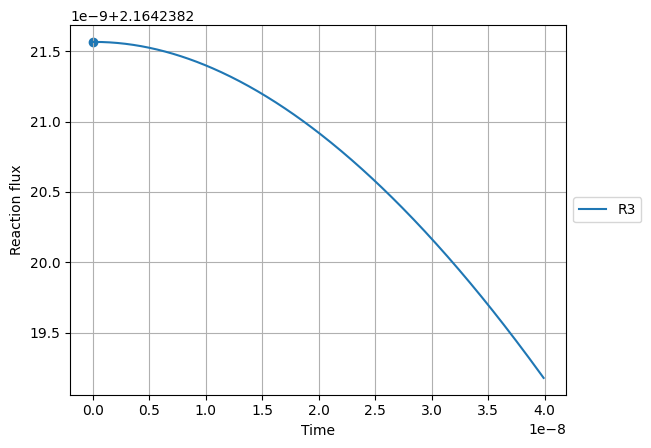

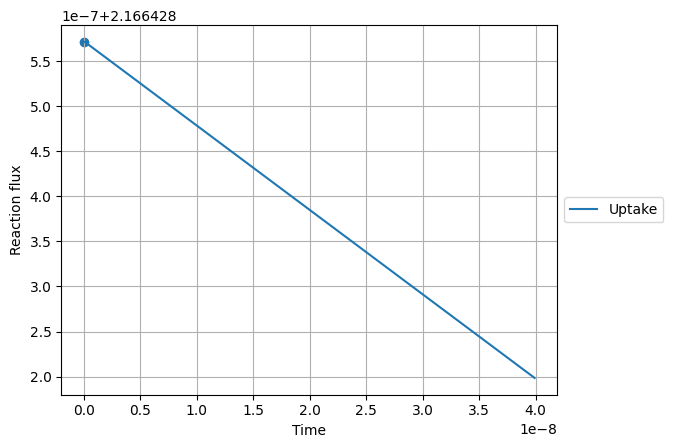

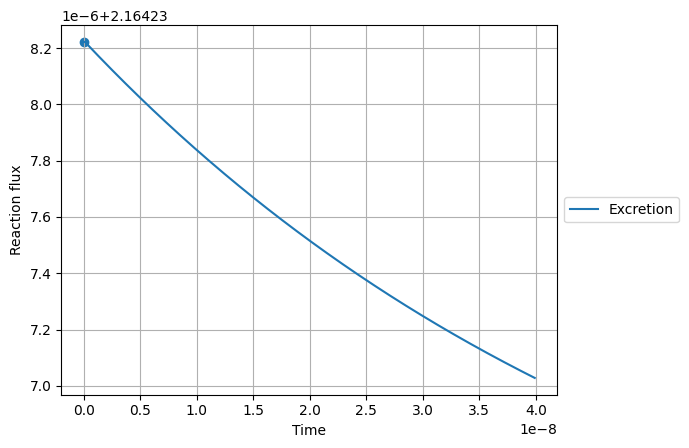

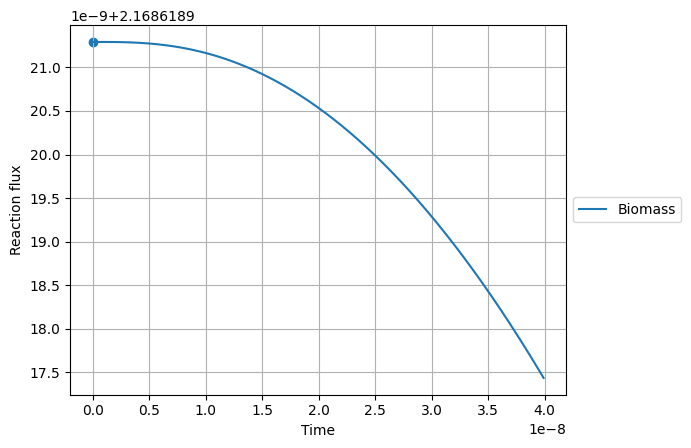

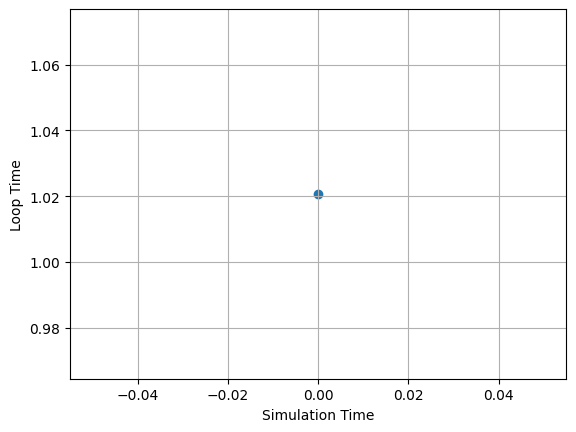

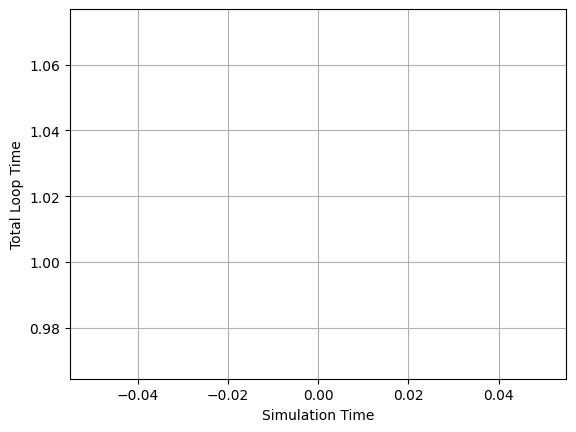

In [19]:
plot_dictionary={
    'biomass_metabolite':'B:CYTOSOL',
    'biomass_reaction':'Biomass',
    'time_limit':0,
    'metabolite_subset':[],
    'reaction_subset':[],
    'regulation_subset':[],
    'exchange_metabolite':['x1_e:ENVIRONMENT','x4_e:ENVIRONMENT'],
    'exchange_reaction':['Uptake','Excretion']
}
dyn.PlotFromPickle(control_dictionary,plot_dictionary)